# Check Python version and upgrading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --upgrade pip

In [3]:
import sys
import os

init_dir = os.getcwd()

In [4]:
# !conda update -n base -c defaults conda -y
# !conda install -y pytorch torchvision -c pytorch

In [5]:
!pip uninstall -y numpy 
!pip install numpy

Found existing installation: numpy 1.21.6
Uninstalling numpy-1.21.6:
  Successfully uninstalled numpy-1.21.6
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0 requires torch==1.12.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.9.3 requires torchvision<0.13.0,>=0.8.1, but you have torchvision 0.13.0 which is incompatible.


# Installations of 3 key libraries: KILT, GENRE and fairseq

In [6]:
#KILT
%rm -rf KILT
!git clone https://github.com/facebookresearch/KILT.git
%cd KILT
!pip install -r requirements.txt
!python setup.py install
sys.path.append(os.getcwd())
%cd ..

#GENRE
%rm -rf GENRE
!git clone https://github.com/facebookresearch/GENRE.git
%cd GENRE
!pip install ./
!python ./setup.py build develop install
!pip install sentencepiece marisa_trie
sys.path.append(os.getcwd())
%cd ..

# fairseq
%rm -rf fairseq
!git clone --branch fixing_prefix_allowed_tokens_fn https://github.com/nicola-decao/fairseq
%cd fairseq
!sed -i -e '26,27d' fairseq/registry.py
!pip install --editable ./
!python setup.py build develop
!python setup.py install
sys.path.append(os.getcwd())
%cd ..

!pip install kilt

#####
%cd fairseq
!pip install --editable ./
%cd ..

Cloning into 'KILT'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 401 (delta 106), reused 91 (delta 91), pack-reused 252
Receiving objects: 100% (401/401), 829.83 KiB | 3.40 MiB/s, done.
Resolving deltas: 100% (224/224), done.
/home/petrakov/mGENRE_MEL/KILT
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
running install
running bdist_egg
running egg_info
creating kilt.egg-info
writing kilt.egg-info/PKG-INFO
writing dependency_links to kilt.egg-info/dependency_links.txt
writing requirements to kilt.egg-info/requires.txt
writing top-level names to kilt.egg-info/top_level.txt
writing manifest file 'kilt.egg-info/SOURCES.txt'
reading manifest file 'kilt.egg-info/SOURCES.txt'
writing manifest file 'kilt.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creat

## import libraries

In [7]:
!pip install gdown

In [8]:
import gdown
import json
import pickle
import torch
import gc
import re
from wikidata.client import Client
import pandas as pd
import numpy as np
from itertools import compress
from datetime import datetime
import matplotlib.pyplot as plt

## Upload data and model (comment cell below if already downloaded)

In [9]:
# # pretrained model
# ! rm -rf fairseq_multilingual_entity_disambiguation*
# ! wget https://dl.fbaipublicfiles.com/GENRE/fairseq_multilingual_entity_disambiguation.tar.gz
# ! tar -xvf fairseq_multilingual_entity_disambiguation.tar.gz

# # data
# ! wget https://dl.fbaipublicfiles.com/GENRE/lang_title2wikidataID-normalized_with_redirect.pkl
# ! wget http://dl.fbaipublicfiles.com/GENRE/titles_lang_all105_marisa_trie_with_redirect.pkl

## Install test data

In [10]:
id_ = "1QpLVXGahVjAoEq8TrE70aKtMLJCNeASh"
gdown.download('https://drive.google.com/uc?id=1QpLVXGahVjAoEq8TrE70aKtMLJCNeASh', output="mentions_test.json", quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1QpLVXGahVjAoEq8TrE70aKtMLJCNeASh
To: /home/petrakov/mGENRE_MEL/mentions_test.json
100%|██████████| 65.1M/65.1M [00:00<00:00, 70.0MB/s]


'mentions_test.json'

In [11]:
with open("mentions_test.json") as f:
    test_set = json.load(f)

In original version there were serious of troubles that's why correct version we add here from external google drive

In [12]:
%%writefile fairseq_model.py
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import copy
import logging
import os
from collections import defaultdict
from typing import Dict, List

import torch
from fairseq import search, utils
from fairseq.models.bart import BARTHubInterface, BARTModel
from omegaconf import open_dict

logger = logging.getLogger(__name__)


class GENREHubInterface(BARTHubInterface):
    def sample(
        self,
        sentences: List[str],
        beam: int = 5,
        verbose: bool = False,
        text_to_id=None,
        marginalize=False,
        marginalize_lenpen=0.5,
        max_len_a=1024,
        max_len_b=1024,
        **kwargs,
    ) -> List[str]:
        if isinstance(sentences, str):
            return self.sample([sentences], beam=beam, verbose=verbose, **kwargs)[0]
        tokenized_sentences = [self.encode(sentence) for sentence in sentences]

        batched_hypos = self.generate(
            tokenized_sentences,
            beam,
            verbose,
            max_len_a=max_len_a,
            max_len_b=max_len_b,
            **kwargs,
        )
        #print("batched_hypos", batched_hypos)
        
        outputs = [
            [
                {"text": self.decode(hypo["tokens"]), "score": hypo["score"]}
                for hypo in hypos
            ]
            for hypos in batched_hypos
        ]
        if text_to_id:
            outputs = [
                [{**hypo, "id": text_to_id(hypo["text"])} for hypo in hypos]
                for hypos in outputs
            ]

            if marginalize:
                for (i, hypos), hypos_tok in zip(enumerate(outputs), batched_hypos):
                    outputs_dict = defaultdict(list)
                    for hypo, hypo_tok in zip(hypos, hypos_tok):
                        outputs_dict[hypo["id"]].append(
                            {**hypo, "len": len(hypo_tok["tokens"])}
                        )

                    outputs[i] = sorted(
                        [
                            {
                                "id": _id,
                                "texts": [hypo["text"] for hypo in hypos],
                                "scores": torch.stack(
                                    [hypo["score"] for hypo in hypos]
                                ),
                                "score": torch.stack(
                                    [
                                        hypo["score"]
                                        * hypo["len"]
                                        / (hypo["len"] ** marginalize_lenpen)
                                        for hypo in hypos
                                    ]
                                ).logsumexp(-1),
                            }
                            for _id, hypos in outputs_dict.items()
                        ],
                        key=lambda x: x["score"],
                        reverse=True,
                    )

        return outputs

    def generate(self, *args, **kwargs) -> List[List[Dict[str, torch.Tensor]]]:
        return super(BARTHubInterface, self).generate(*args, **kwargs)

    def encode(self, sentence) -> torch.LongTensor:
        tokens = super(BARTHubInterface, self).encode(sentence)
        tokens[
            tokens >= len(self.task.target_dictionary)
        ] = self.task.target_dictionary.unk_index
        if tokens[0] != self.task.target_dictionary.bos_index:
            return torch.cat(
                (torch.tensor([self.task.target_dictionary.bos_index]), tokens)
            )
        else:
            return tokens

    
class GENRE(BARTModel):
    @classmethod
    def from_pretrained(
        cls,
        model_name_or_path,
        checkpoint_file="model.pt",
        data_name_or_path=".",
        bpe="gpt2",
        **kwargs,
    ):
        from fairseq import hub_utils

        x = hub_utils.from_pretrained(
            model_name_or_path,
            checkpoint_file,
            data_name_or_path,
            archive_map=cls.hub_models(),
            bpe=bpe,
            load_checkpoint_heads=True,
            **kwargs,
        )
        return GENREHubInterface(x["args"], x["task"], x["models"][0])


class mGENRE(BARTModel):
    @classmethod
    def from_pretrained(
        cls,
        model_name_or_path,
        sentencepiece_model="spm_256000.model",
        checkpoint_file="model.pt",
        data_name_or_path=".",
        bpe="sentencepiece",
        layernorm_embedding=True,
        **kwargs,
    ):
        from fairseq import hub_utils

        x = hub_utils.from_pretrained(
            model_name_or_path,
            checkpoint_file,
            data_name_or_path,
            archive_map=cls.hub_models(),
            bpe=bpe,
            load_checkpoint_heads=True,
            sentencepiece_model=os.path.join(model_name_or_path, sentencepiece_model),
            **kwargs,
        )
        return GENREHubInterface(x["args"], x["task"], x["models"][0])


Writing fairseq_model.py


In [13]:
%mv fairseq_model.py GENRE/genre

In [14]:
%cd fairseq/fairseq/models

/home/petrakov/mGENRE_MEL/fairseq/fairseq/models


In [15]:
%%writefile fairseq_model.py
# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
"""
Base classes for various fairseq models.
"""

import logging
from argparse import Namespace
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from fairseq import utils
from fairseq.data import Dictionary
from fairseq.dataclass.utils import (
    convert_namespace_to_omegaconf,
    gen_parser_from_dataclass,
)
from fairseq.models import FairseqDecoder, FairseqEncoder
from omegaconf import DictConfig
from torch import Tensor


logger = logging.getLogger(__name__)


class BaseFairseqModel(nn.Module):
    """Base class for fairseq models."""

    def __init__(self):
        super().__init__()
        self._is_generation_fast = False

    @classmethod
    def add_args(cls, parser):
        """Add model-specific arguments to the parser."""
        dc = getattr(cls, "__dataclass", None)
        if dc is not None:
            # do not set defaults so that settings defaults from various architectures still works
            gen_parser_from_dataclass(parser, dc(), delete_default=True)

    @classmethod
    def build_model(cls, args, task):
        """Build a new model instance."""
        raise NotImplementedError("Model must implement the build_model method")

    def get_targets(self, sample, net_output):
        """Get targets from either the sample or the net's output."""
        return sample["target"]

    def get_normalized_probs(
        self,
        net_output: Tuple[Tensor, Optional[Dict[str, List[Optional[Tensor]]]]],
        log_probs: bool,
        sample: Optional[Dict[str, Tensor]] = None,
    ):
        """Get normalized probabilities (or log probs) from a net's output."""
        return self.get_normalized_probs_scriptable(net_output, log_probs, sample)

    # TorchScript doesn't support super() method so that the scriptable Subclass
    # can't access the base class model in Torchscript.
    # Current workaround is to add a helper function with different name and
    # call the helper function from scriptable Subclass.
    def get_normalized_probs_scriptable(
        self,
        net_output: Tuple[Tensor, Optional[Dict[str, List[Optional[Tensor]]]]],
        log_probs: bool,
        sample: Optional[Dict[str, Tensor]] = None,
    ):
        """Scriptable helper function for get_normalized_probs in ~BaseFairseqModel"""
        if hasattr(self, "decoder"):
            return self.decoder.get_normalized_probs(net_output, log_probs, sample)
        elif torch.is_tensor(net_output):
            # syntactic sugar for simple models which don't have a decoder
            # (e.g., the classification tutorial)
            logits = net_output.float()
            if log_probs:
                return F.log_softmax(logits, dim=-1)
            else:
                return F.softmax(logits, dim=-1)
        raise NotImplementedError

    def extract_features(self, *args, **kwargs):
        """Similar to *forward* but only return features."""
        return self(*args, **kwargs)

    def max_positions(self):
        """Maximum length supported by the model."""
        return None

    def load_state_dict(
        self,
        state_dict,
        strict=True,
        model_cfg: Optional[DictConfig] = None,
        args: Optional[Namespace] = None,
    ):
        """Copies parameters and buffers from *state_dict* into this module and
        its descendants.

        Overrides the method in :class:`nn.Module`. Compared with that method
        this additionally "upgrades" *state_dicts* from old checkpoints.
        """

        if model_cfg is None and args is not None:
            logger.warn("using 'args' is deprecated, please update your code to use dataclass config")
            model_cfg = convert_namespace_to_omegaconf(args).model

        self.upgrade_state_dict(state_dict)

        from fairseq.checkpoint_utils import prune_state_dict

        new_state_dict = prune_state_dict(state_dict, model_cfg)
        return super().load_state_dict(new_state_dict, strict)

    def upgrade_state_dict(self, state_dict):
        """Upgrade old state dicts to work with newer code."""
        self.upgrade_state_dict_named(state_dict, "")

    def upgrade_state_dict_named(self, state_dict, name):
        """Upgrade old state dicts to work with newer code.

        Args:
            state_dict (dict): state dictionary to upgrade, in place
            name (str): the state dict key corresponding to the current module
        """
        assert state_dict is not None

        def do_upgrade(m, prefix):
            if len(prefix) > 0:
                prefix += "."

            for n, c in m.named_children():
                name = prefix + n
                if hasattr(c, "upgrade_state_dict_named"):
                    c.upgrade_state_dict_named(state_dict, name)
                elif hasattr(c, "upgrade_state_dict"):
                    c.upgrade_state_dict(state_dict)
                do_upgrade(c, name)

        do_upgrade(self, name)

    def set_num_updates(self, num_updates):
        """State from trainer to pass along to model at every update."""

        def _apply(m):
            if hasattr(m, "set_num_updates") and m != self:
                m.set_num_updates(num_updates)

        self.apply(_apply)

    def prepare_for_inference_(self, cfg: DictConfig):
        """Prepare model for inference."""
        kwargs = {}
        kwargs["beamable_mm_beam_size"] = (
            None
            if getattr(cfg.generation, "no_beamable_mm", False)
            else getattr(cfg.generation, "beam", 5)
        )
        kwargs["need_attn"] = getattr(cfg.generation, "print_alignment", False)
        if getattr(cfg.generation, "retain_dropout", False):
            kwargs["retain_dropout"] = cfg.generation.retain_dropout
            kwargs["retain_dropout_modules"] = cfg.generation.retain_dropout_modules
        self.make_generation_fast_(**kwargs)

    def make_generation_fast_(self, **kwargs):
        """
        Legacy entry point to optimize model for faster generation.
        Prefer prepare_for_inference_.
        """
        if self._is_generation_fast:
            return  # only apply once
        self._is_generation_fast = True

        # remove weight norm from all modules in the network
        def apply_remove_weight_norm(module):
            try:
                nn.utils.remove_weight_norm(module)
            except (AttributeError, ValueError):  # this module didn't have weight norm
                return

        self.apply(apply_remove_weight_norm)

        def apply_make_generation_fast_(module, prefix):
            if len(prefix) > 0:
                prefix += "."

            base_func = BaseFairseqModel.make_generation_fast_
            for n, m in module.named_modules():
                if (
                    m != self
                    and hasattr(m, "make_generation_fast_")
                    # don't call this implementation again, e.g., if
                    # children modules also inherit from BaseFairseqModel
                    and m.make_generation_fast_.__func__ is not base_func
                ):
                    name = prefix + n
                    m.make_generation_fast_(name=name, **kwargs)

        apply_make_generation_fast_(self, "")

        def train(mode=True):
            #self.train = train
            self.train()

#     def prepare_for_onnx_export_(self, **kwargs):
#         """Make model exportable via ONNX trace."""
#         seen = set()

#         def apply_prepare_for_onnx_export_(module):
#             if (
#                 module != self
#                 and hasattr(module, "prepare_for_onnx_export_")
#                 and module not in seen
#             ):
#                 seen.add(module)
#                 module.prepare_for_onnx_export_(**kwargs)

#         self.apply(apply_prepare_for_onnx_export_)

    @classmethod
    def from_pretrained(
        cls,
        model_name_or_path,
        checkpoint_file="model.pt",
        data_name_or_path=".",
        **kwargs,
    ):
        """
        Load a :class:`~fairseq.models.FairseqModel` from a pre-trained model
        file. Downloads and caches the pre-trained model file if needed.

        The base implementation returns a
        :class:`~fairseq.hub_utils.GeneratorHubInterface`, which can be used to
        generate translations or sample from language models. The underlying
        :class:`~fairseq.models.FairseqModel` can be accessed via the
        *generator.models* attribute.

        Other models may override this to implement custom hub interfaces.

        Args:
            model_name_or_path (str): either the name of a pre-trained model to
                load or a path/URL to a pre-trained model state dict
            checkpoint_file (str, optional): colon-separated list of checkpoint
                files in the model archive to ensemble (default: 'model.pt')
            data_name_or_path (str, optional): point args.data to the archive
                at the given path/URL. Can start with '.' or './' to reuse the
                model archive path.
        """
        from fairseq import hub_utils

        x = hub_utils.from_pretrained(
            model_name_or_path,
            checkpoint_file,
            data_name_or_path,
            archive_map=cls.hub_models(),
            **kwargs,
        )
        logger.info(x["args"])
        return hub_utils.GeneratorHubInterface(x["args"], x["task"], x["models"])

    @classmethod
    def hub_models(cls):
        return {}


class FairseqEncoderDecoderModel(BaseFairseqModel):
    """Base class for encoder-decoder models.

    Args:
        encoder (FairseqEncoder): the encoder
        decoder (FairseqDecoder): the decoder
    """

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        assert isinstance(self.encoder, FairseqEncoder)
        assert isinstance(self.decoder, FairseqDecoder)

    def forward(self, src_tokens, src_lengths, prev_output_tokens, **kwargs):
        """
        Run the forward pass for an encoder-decoder model.

        First feed a batch of source tokens through the encoder. Then, feed the
        encoder output and previous decoder outputs (i.e., teacher forcing) to
        the decoder to produce the next outputs::

            encoder_out = self.encoder(src_tokens, src_lengths)
            return self.decoder(prev_output_tokens, encoder_out)

        Args:
            src_tokens (LongTensor): tokens in the source language of shape
                `(batch, src_len)`
            src_lengths (LongTensor): source sentence lengths of shape `(batch)`
            prev_output_tokens (LongTensor): previous decoder outputs of shape
                `(batch, tgt_len)`, for teacher forcing

        Returns:
            tuple:
                - the decoder's output of shape `(batch, tgt_len, vocab)`
                - a dictionary with any model-specific outputs
        """
        encoder_out = self.encoder(src_tokens, src_lengths=src_lengths, **kwargs)
        decoder_out = self.decoder(
            prev_output_tokens, encoder_out=encoder_out, **kwargs
        )
        return decoder_out

    def forward_decoder(self, prev_output_tokens, **kwargs):
        return self.decoder(prev_output_tokens, **kwargs)

    def extract_features(self, src_tokens, src_lengths, prev_output_tokens, **kwargs):
        """
        Similar to *forward* but only return features.

        Returns:
            tuple:
                - the decoder's features of shape `(batch, tgt_len, embed_dim)`
                - a dictionary with any model-specific outputs
        """
        encoder_out = self.encoder(src_tokens, src_lengths=src_lengths, **kwargs)
        features = self.decoder.extract_features(
            prev_output_tokens, encoder_out=encoder_out, **kwargs
        )
        return features

    def output_layer(self, features, **kwargs):
        """Project features to the default output size (typically vocabulary size)."""
        return self.decoder.output_layer(features, **kwargs)

    def max_positions(self):
        """Maximum length supported by the model."""
        return (self.encoder.max_positions(), self.decoder.max_positions())

    def max_decoder_positions(self):
        """Maximum length supported by the decoder."""
        return self.decoder.max_positions()


class FairseqModel(FairseqEncoderDecoderModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        utils.deprecation_warning(
            "FairseqModel is deprecated, please use FairseqEncoderDecoderModel "
            "or BaseFairseqModel instead",
            stacklevel=4,
        )


class FairseqMultiModel(BaseFairseqModel):
    """Base class for combining multiple encoder-decoder models."""

    def __init__(self, encoders, decoders):
        super().__init__()
        assert encoders.keys() == decoders.keys()
        self.keys = list(encoders.keys())
        for key in self.keys:
            assert isinstance(encoders[key], FairseqEncoder)
            assert isinstance(decoders[key], FairseqDecoder)

        self.models = nn.ModuleDict(
            {
                key: FairseqEncoderDecoderModel(encoders[key], decoders[key])
                for key in self.keys
            }
        )

    @staticmethod
    def build_shared_embeddings(
        dicts: Dict[str, Dictionary],
        langs: List[str],
        embed_dim: int,
        build_embedding: callable,
        pretrained_embed_path: Optional[str] = None,
    ):
        """
        Helper function to build shared embeddings for a set of languages after
        checking that all dicts corresponding to those languages are equivalent.

        Args:
            dicts: Dict of lang_id to its corresponding Dictionary
            langs: languages that we want to share embeddings for
            embed_dim: embedding dimension
            build_embedding: callable function to actually build the embedding
            pretrained_embed_path: Optional path to load pretrained embeddings
        """
        shared_dict = dicts[langs[0]]
        if any(dicts[lang] != shared_dict for lang in langs):
            raise ValueError(
                "--share-*-embeddings requires a joined dictionary: "
                "--share-encoder-embeddings requires a joined source "
                "dictionary, --share-decoder-embeddings requires a joined "
                "target dictionary, and --share-all-embeddings requires a "
                "joint source + target dictionary."
            )
        return build_embedding(shared_dict, embed_dim, pretrained_embed_path)

    def forward(self, src_tokens, src_lengths, prev_output_tokens, **kwargs):
        raise NotImplementedError

    def max_positions(self):
        """Maximum length supported by the model."""
        return {
            key: (
                self.models[key].encoder.max_positions(),
                self.models[key].decoder.max_positions(),
            )
            for key in self.keys
        }

    def max_decoder_positions(self):
        """Maximum length supported by the decoder."""
        return min(model.decoder.max_positions() for model in self.models.values())

    @property
    def encoder(self):
        return self.models[self.keys[0]].encoder

    @property
    def decoder(self):
        return self.models[self.keys[0]].decoder

    def forward_decoder(self, prev_output_tokens, **kwargs):
        return self.decoder(prev_output_tokens, **kwargs)

    def load_state_dict(
        self,
        state_dict,
        strict=True,
        model_cfg=None,
        args: Optional[Namespace] = None,
    ):
        """Copies parameters and buffers from *state_dict* into this module and
        its descendants.

        Overrides the method in :class:`nn.Module`. Compared with that method
        this additionally "upgrades" *state_dicts* from old checkpoints.
        """

        if model_cfg is None and args is not None:
            logger.warn("using 'args' is deprecated, please update your code to use dataclass config")
            model_cfg = convert_namespace_to_omegaconf(args).model

        self.upgrade_state_dict(state_dict)

        from fairseq.checkpoint_utils import prune_state_dict

        new_state_dict = prune_state_dict(state_dict, model_cfg)
        return super().load_state_dict(new_state_dict, strict)


class FairseqLanguageModel(BaseFairseqModel):
    """Base class for decoder-only models.

    Args:
        decoder (FairseqDecoder): the decoder
    """

    def __init__(self, decoder):
        super().__init__()
        self.decoder = decoder
        assert isinstance(self.decoder, FairseqDecoder)

    def forward(self, src_tokens, **kwargs):
        """
        Run the forward pass for a decoder-only model.

        Feeds a batch of tokens through the decoder to predict the next tokens.

        Args:
            src_tokens (LongTensor): tokens on which to condition the decoder,
                of shape `(batch, tgt_len)`
            src_lengths (LongTensor): source sentence lengths of shape `(batch)`

        Returns:
            tuple:
                - the decoder's output of shape `(batch, seq_len, vocab)`
                - a dictionary with any model-specific outputs
        """
        return self.decoder(src_tokens, **kwargs)

    def forward_decoder(self, prev_output_tokens, **kwargs):
        return self.decoder(prev_output_tokens, **kwargs)

    def extract_features(self, src_tokens, **kwargs):
        """
        Similar to *forward* but only return features.

        Returns:
            tuple:
                - the decoder's features of shape `(batch, seq_len, embed_dim)`
                - a dictionary with any model-specific outputs
        """
        return self.decoder.extract_features(src_tokens, **kwargs)

    def output_layer(self, features, **kwargs):
        """Project features to the default output size (typically vocabulary size)."""
        return self.decoder.output_layer(features, **kwargs)

    def max_positions(self):
        """Maximum length supported by the model."""
        return self.decoder.max_positions()

    def max_decoder_positions(self):
        """Maximum length supported by the decoder."""
        return self.decoder.max_positions()

    @property
    def supported_targets(self):
        return {"future"}


class FairseqEncoderModel(BaseFairseqModel):
    """Base class for encoder-only models.

    Args:
        encoder (FairseqEncoder): the encoder
    """

    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        assert isinstance(self.encoder, FairseqEncoder)

    def forward(self, src_tokens, src_lengths, **kwargs):
        """
        Run the forward pass for a encoder-only model.

        Feeds a batch of tokens through the encoder to generate features.

        Args:
            src_tokens (LongTensor): input tokens of shape `(batch, src_len)`
            src_lengths (LongTensor): source sentence lengths of shape `(batch)`

        Returns:
            the encoder's output, typically of shape `(batch, src_len, features)`
        """
        return self.encoder(src_tokens, src_lengths, **kwargs)

    def get_normalized_probs(self, net_output, log_probs, sample=None):
        """Get normalized probabilities (or log probs) from a net's output."""
        encoder_out = net_output["encoder_out"]
        if torch.is_tensor(encoder_out):
            logits = encoder_out.float()
            if log_probs:
                return F.log_softmax(logits, dim=-1)
            else:
                return F.softmax(logits, dim=-1)
        raise NotImplementedError

    def max_positions(self):
        """Maximum length supported by the model."""
        return self.encoder.max_positions()


Overwriting fairseq_model.py


In [16]:
%cd $init_dir

/home/petrakov/mGENRE_MEL


# Multilingual Autoregressive Entity Linking

![](s.png)

We are starting with importing our model mGENRE and it's important part, it was slightly changed in previous cells in order to reach stable work

In [17]:
from GENRE.genre.trie import Trie, MarisaTrie
from GENRE.genre.fairseq_model import mGENRE

Here we load data that connects titles with wikidata ids and trie that is an important part of the model

In [18]:
with open("lang_title2wikidataID-normalized_with_redirect.pkl", "rb") as f:
    lang_title2wikidataID = pickle.load(f)
  
# with open("titles_lang_all105_trie_with_redirect.pkl", "rb") as f:
#     trie = Trie.load_from_dict(pickle.load(f))

with open("titles_lang_all105_marisa_trie_with_redirect.pkl", "rb") as f:
    trie = pickle.load(f)

### Using GPU leads to faster inference, so if possible it is recommended

Here we chosen 4 because there were lot's of free memory on our own server, you can check the memory available for you using the command below

In [19]:
!nvidia-cdl

Driver version: 470.103.01
------------------- Device 0 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:   159MiB / 11019MiB
Temperature: 29C
Running processes not found

------------------- Device 1 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:     8MiB / 11019MiB
Temperature: 22C
Running processes not found

------------------- Device 2 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:  4077MiB / 11019MiB
Temperature: 26C
Running processes not found

------------------- Device 3 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:  5949MiB / 11019MiB
Temperature: 24C
Running processes not found

------------------- Device 4 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:  9077MiB / 11019MiB
Temperature: 21C
Running processes not found

------------------- Device 5 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:     8MiB / 11019MiB
Temperature: 24C
Running processes not found

-

In [23]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

In [24]:
# generate Wikipedia titles and language IDs
model_mGENRE = mGENRE.from_pretrained("fairseq_multilingual_entity_disambiguation").eval()
model_mGENRE.to(device)

GENREHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(256001, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDro

Example of model result

In [25]:
sentences = ["[START] The founder of the theory of relativity [END] received the Nobel Prize."]
model_mGENRE.sample(
    sentences,
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

[[{'id': 'Q937',
   'texts': ['Albert Einstein >> en'],
   'scores': tensor([-0.7137], device='cuda:5'),
   'score': tensor(-1.5959, device='cuda:5')},
  {'id': 'Q363005',
   'texts': ['John Singleton >> en'],
   'scores': tensor([-0.7909], device='cuda:5'),
   'score': tensor(-1.9374, device='cuda:5')},
  {'id': 'Q7374',
   'texts': ['Alfred Hitchcock >> en'],
   'scores': tensor([-0.8762], device='cuda:5'),
   'score': tensor(-2.3182, device='cuda:5')},
  {'id': 'Q715110',
   'texts': ['Robert Maynard >> en'],
   'scores': tensor([-0.8954], device='cuda:5'),
   'score': tensor(-2.3689, device='cuda:5')},
  {'id': 'Q9353',
   'texts': ['John Locke >> en'],
   'scores': tensor([-1.0060], device='cuda:5'),
   'score': tensor(-2.4641, device='cuda:5')}]]

Results above demonstrate that each *text* has it's own id and via marginalization procedure we have unique score for predicted entity

# Hypothesis of no [START] and [END]

Within this part we check that [START] and [END] tokens are really needed

In [26]:
sentences = ["Who invented radio?"]
model_mGENRE.sample(
    sentences,
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

[[{'id': 'Q1517374',
   'texts': ['History of radio >> en'],
   'scores': tensor([-0.4300], device='cuda:5'),
   'score': tensor(-1.0534, device='cuda:5')},
  {'id': 'Q1516738',
   'texts': ['Invention of radio >> en'],
   'scores': tensor([-0.6202], device='cuda:5'),
   'score': tensor(-1.6408, device='cuda:5')},
  {'id': 'Q16887156',
   'texts': ['List of inventions in the medieval Islamic world >> en',
    'List of inventions in the medieval Islamic world >> ar'],
   'scores': tensor([-0.5023, -1.5995], device='cuda:5'),
   'score': tensor(-1.7181, device='cuda:5')},
  {'id': 'Q4501817',
   'texts': ['Timeline of radio >> en'],
   'scores': tensor([-0.9116], device='cuda:5'),
   'score': tensor(-2.4119, device='cuda:5')}]]

In [21]:
sentences = ["When Second World war started?"]
model_mGENRE.sample(
    sentences,
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

[[{'id': 'Q362',
   'texts': ['World War II >> en', 'Second World War >> en'],
   'scores': tensor([-0.4641, -0.6737], device='cuda:4'),
   'score': tensor(-0.6678, device='cuda:4')},
  {'id': 'Q5370388',
   'texts': ['Military history of the United States during World War II >> en'],
   'scores': tensor([-0.2719], device='cuda:4'),
   'score': tensor(-0.9804, device='cuda:4')},
  {'id': 'Q192781',
   'texts': ['Military history >> en'],
   'scores': tensor([-0.8395], device='cuda:4'),
   'score': tensor(-1.8772, device='cuda:4')},
  {'id': 'Q131110',
   'texts': ['History of the United States >> en'],
   'scores': tensor([-0.7007], device='cuda:4'),
   'score': tensor(-1.9820, device='cuda:4')}]]

#### We can say that entities within simple questions like above correctly determine

# Quantitative assessment of the hypothesis

#### !!!before that you have to clone wikidata-simplequestions github repository (https://github.com/askplatypus/wikidata-simplequestions)

In [78]:
# %cd $init_dir
# %cd ..
# !git clone https://github.com/askplatypus/wikidata-simplequestions


# %cd $init_dir

/home/petrakov
Cloning into 'wikidata-simplequestions'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 130 (delta 9), reused 37 (delta 9), pack-reused 92
Receiving objects: 100% (130/130), 41.95 MiB | 10.00 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Error downloading object: qald-format/annotated_wd_data_test.json (c44a001): Smudge error: Error downloading qald-format/annotated_wd_data_test.json (c44a0018eeadcbad409fec3f0f032dd9f22fcaa3c9e05d06a4640a97b37c3d40): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /home/petrakov/wikidata-simplequestions/.git/lfs/logs/20220713T202858.12718045.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: qald-format/annotated_wd_data_test.json: smudge filter lfs failed
You ca

In [50]:
path_to_train_simple_questions = "/home/petrakov/wikidata-simplequestions/annotated_wd_data_train_answerable.txt"

In [51]:
data = pd.read_table(path_to_train_simple_questions, header=None).rename(columns = {0:"object", 1:"property", 2:"subject", 3:"question"})
data

,object,property,subject,question
0,Q12439,R19,Q6106580,who is a musician born in detroit
1,Q6817891,P364,Q1568,what is the language in which mera shikar was ...
2,Q1297,R276,Q2888523,Whats the name of a battle that happened in ch...
3,Q193592,R413,Q5822614,what player plays the position midfielder?
4,Q6849115,P413,Q336286,what is the position that mike twellman plays
...,...,...,...,...
19476,Q223960,P171,Q128001,what classification does mountain tapir come ...
19477,Q1535153,R136,Q7727315,What's a superhero movie that premiered on too...
19478,Q157443,R136,Q966690,What is the name of a comedy film that is also...
19479,Q16093542,P27,Q145,What is the nationality of anthony bailey


In [25]:
n = 100
start_time = datetime.now()


mGENRE_results = model_mGENRE.sample(
                                    list(data.loc[:n, "question"]),
                                    beam = 3,
                                    prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                        e for e in trie.get(sent.tolist())
                                        if e < len(model_mGENRE.task.target_dictionary)
                                    ],
                                    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                    marginalize=True,
                                    verbose = True
                                )


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


Duration: 0:00:50.320952


In [39]:
y_pred = [i[0]['id'] for i in mGENRE_results]
y_true = list(data.loc[:n, "object"])
result = [x in y_pred for x in y_true] 


### If we take only the most probable score

In [41]:
np.round(sum(result)/len(result), 4)

0.2475

### If we take an account all predicted ids

In [52]:
out = [[i['id'] for i in mGENRE_results[j]] for j in range(len(mGENRE_results))]

In [58]:
res = []
for index, out_list in enumerate(out):
    if y_true[index] in out_list:
        res.append(1)
    else:
        res.append(0)
        
    

In [60]:
np.round(sum(res)/len(res), 4)

0.3168

### If we take on account only those questions where we certain (top 1)

In [30]:
thresholds = [-3, -2, -1.5, -1, -0.75, -0.6, -0.4, -0.2, -0.1]

In [31]:
accuracy_100_top_1 = []
share_of_observations_100_top_1 = []

for threshold in thresholds:
    certain_out = [i[0]['id'] for i in mGENRE_results if i[0]['score'] > threshold]
    indexes = [1 if i[0]['score'] > threshold else 0 for i in mGENRE_results]
    y_true = list(compress(list(data.loc[:n, "object"]), indexes))
    result = [x in certain_out for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 4)*100
    accuracy_100_top_1.append(accuracy)
    share = len(result)/n*100
    share_of_observations_100_top_1.append(share)
    
    print("threshold = ", threshold, "\t",
          "accuracy = ", accuracy, "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ", len(result)/n*100, "%")

threshold =  -3 	 accuracy =  2.8400000000000003 %	 number of observations =  387 	 share of observations =  96.75 %
threshold =  -2 	 accuracy =  3.0700000000000003 %	 number of observations =  326 	 share of observations =  81.5 %
threshold =  -1.5 	 accuracy =  3.35 %	 number of observations =  239 	 share of observations =  59.75 %
threshold =  -1 	 accuracy =  3.36 %	 number of observations =  149 	 share of observations =  37.25 %
threshold =  -0.75 	 accuracy =  1.87 %	 number of observations =  107 	 share of observations =  26.75 %
threshold =  -0.6 	 accuracy =  0.0 %	 number of observations =  78 	 share of observations =  19.5 %
threshold =  -0.4 	 accuracy =  0.0 %	 number of observations =  40 	 share of observations =  10.0 %
threshold =  -0.2 	 accuracy =  0.0 %	 number of observations =  12 	 share of observations =  3.0 %
threshold =  -0.1 	 accuracy =  0.0 %	 number of observations =  5 	 share of observations =  1.25 %


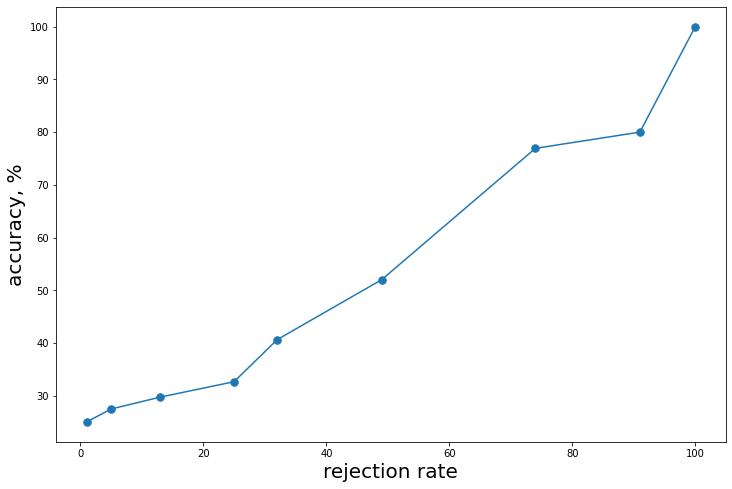

In [147]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.plot(share_of_observations_100_top_1[::-1], accuracy_100_top_1, marker = '.', markersize = 15);

## Add more observations

In [67]:
n = 400
start_time = datetime.now()


mGENRE_results = model_mGENRE.sample(
                                    list(data.sample(n = n, replace = False, random_state=1).loc[:, "question"]),
                                    beam = 3,
                                    prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                        e for e in trie.get(sent.tolist())
                                        if e < len(model_mGENRE.task.target_dictionary)
                                    ],
                                    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                    marginalize=True,
                                    verbose = True
                                )


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


/home/petrakov/success/mGENRE_MEL/fairseq/fairseq/search.py:205: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size


RuntimeError: CUDA out of memory. Tried to allocate 752.00 MiB (GPU 3; 10.76 GiB total capacity; 4.90 GiB already allocated; 615.56 MiB free; 5.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
thresholds = [-10, -3, -2, -1.5, -1, -0.75, -0.6, -0.4, -0.2, -0.1]
accuracy_400_top_1 = []
share_of_observations_400_top_1 = []

for threshold in thresholds:
    certain_out = [i[0]['id'] for i in mGENRE_results if i[0]['score'] > threshold]
    indexes = [1 if i[0]['score'] > threshold else 0 for i in mGENRE_results]
    y_true = list(compress(list(data.loc[list(data.sample(n = n, replace = False, random_state=1).index), "object"]), indexes))
    result = [x in certain_out for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 2)*100
    accuracy_400_top_1.append(accuracy)
    share = np.round(len(result)/n*100, 2)
    share_of_observations_400_top_1.append(share)
    
    print("threshold = ", threshold, "\t",
          "accuracy = ", accuracy, "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ", share, "%")

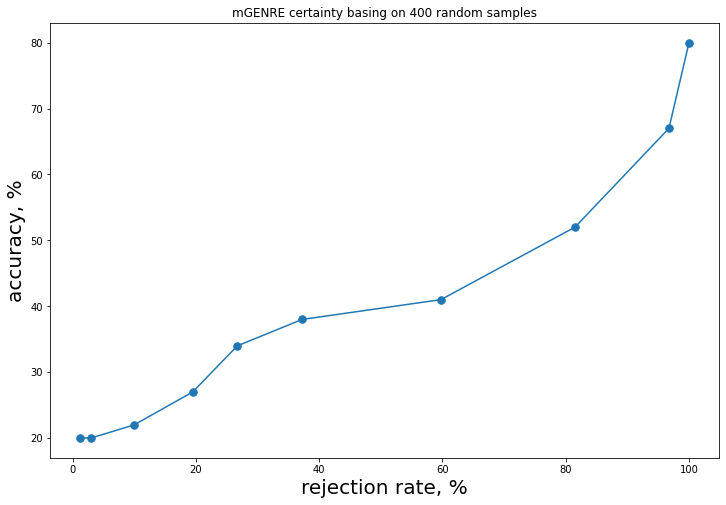

In [25]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.title("mGENRE certainty basing on 400 random samples")
plt.plot(share_of_observations_400_top_1[::-1], accuracy_400_top_1, marker = '.', markersize = 15);

### Batch approach to add observations

In [72]:
n = 400
start_time = datetime.now()

divider = 80

mGENRE_results = []
for i in range(divider):

    mGENRE_results_i = model_mGENRE.sample(
                                        list(data.sample(n = 5, replace = False, random_state=i).loc[:, "question"]),
                                        beam = 3,
                                        prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                            e for e in trie.get(sent.tolist())
                                            if e < len(model_mGENRE.task.target_dictionary)
                                        ],
                                        text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                        marginalize=True,
                                        verbose = True
                                    )
    mGENRE_results.append(mGENRE_results_i)
    print("part ", i, " done!")


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


part  0  done!
part  1  done!
part  2  done!
part  3  done!
part  4  done!
part  5  done!
part  6  done!
part  7  done!
part  8  done!
part  9  done!
part  10  done!
part  11  done!
part  12  done!
part  13  done!
part  14  done!
part  15  done!
part  16  done!
part  17  done!
part  18  done!
part  19  done!
part  20  done!
part  21  done!
part  22  done!
part  23  done!
part  24  done!
part  25  done!
part  26  done!
part  27  done!
part  28  done!
part  29  done!
part  30  done!
part  31  done!
part  32  done!
part  33  done!
part  34  done!
part  35  done!
part  36  done!
part  37  done!
part  38  done!
part  39  done!
part  40  done!
part  41  done!
part  42  done!
part  43  done!
part  44  done!
part  45  done!
part  46  done!
part  47  done!
part  48  done!
part  49  done!
part  50  done!
part  51  done!
part  52  done!
part  53  done!
part  54  done!
part  55  done!
part  56  done!
part  57  done!
part  58  done!
part  59  done!
part  60  done!
part  61  done!
part  62  done!
pa

In [83]:
mGENRE_results = sum(mGENRE_results, [])

In [88]:
objects = []
for i in range(divider): 
    objects.append(list(data.sample(n = 5, replace = False, random_state=i).loc[:, "object"]))

In [93]:
objects = sum(objects, [])

In [94]:
thresholds = [-10, -3, -2, -1.5, -1, -0.75, -0.6, -0.4, -0.2, -0.1]
accuracy_400_top_1 = []
share_of_observations_400_top_1 = []

for threshold in thresholds:
    certain_out = [i[0]['id'] for i in mGENRE_results if i[0]['score'] > threshold]
    indexes = [1 if i[0]['score'] > threshold else 0 for i in mGENRE_results]
    y_true = list(compress(objects, indexes))
    result = [x in certain_out for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 2)*100
    accuracy_400_top_1.append(accuracy)
    share = np.round(len(result)/n*100, 2)
    share_of_observations_400_top_1.append(share)
    
    print("threshold = ", threshold, "\t",
          "accuracy = ", accuracy, "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ", share, "%")


threshold =  -10 	 accuracy =  23.0 %	 number of observations =  400 	 share of observations =  100.0 %
threshold =  -3 	 accuracy =  24.0 %	 number of observations =  383 	 share of observations =  95.75 %
threshold =  -2 	 accuracy =  27.0 %	 number of observations =  331 	 share of observations =  82.75 %
threshold =  -1.5 	 accuracy =  31.0 %	 number of observations =  249 	 share of observations =  62.25 %
threshold =  -1 	 accuracy =  39.0 %	 number of observations =  141 	 share of observations =  35.25 %
threshold =  -0.75 	 accuracy =  43.0 %	 number of observations =  95 	 share of observations =  23.75 %
threshold =  -0.6 	 accuracy =  45.0 %	 number of observations =  76 	 share of observations =  19.0 %
threshold =  -0.4 	 accuracy =  61.0 %	 number of observations =  46 	 share of observations =  11.5 %
threshold =  -0.2 	 accuracy =  68.0 %	 number of observations =  19 	 share of observations =  4.75 %
threshold =  -0.1 	 accuracy =  67.0 %	 number of observations =  6 

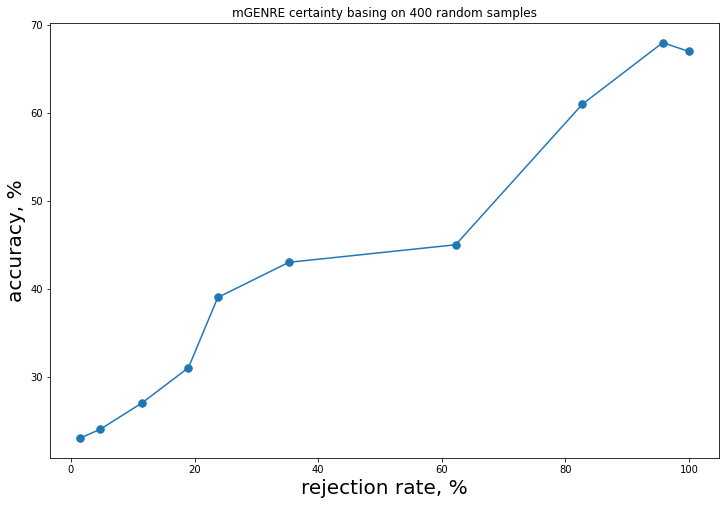

In [95]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.title("mGENRE certainty basing on 400 random samples")
plt.plot(share_of_observations_400_top_1[::-1], accuracy_400_top_1, marker = '.', markersize = 15);

# MC Dropout

In [28]:
from GENRE.genre.fairseq_model import mGENRE

In [29]:
%cat fairseq/fairseq/models/fairseq_model.py

# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
"""
Base classes for various fairseq models.
"""

import logging
from argparse import Namespace
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from fairseq import utils
from fairseq.data import Dictionary
from fairseq.dataclass.utils import (
    convert_namespace_to_omegaconf,
    gen_parser_from_dataclass,
)
from fairseq.models import FairseqDecoder, FairseqEncoder
from omegaconf import DictConfig
from torch import Tensor


logger = logging.getLogger(__name__)


class BaseFairseqModel(nn.Module):
    """Base class for fairseq models."""

    def __init__(self):
        super().__init__()
        self._is_generation_fast = False

    @classmethod
    def add_args(cls, parser):
        """Add model-specific arguments to the parser."""
        dc

In [30]:
gc.collect()
torch.cuda.empty_cache()

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
%cd $init_dir/GENRE/genre

/home/petrakov/mGENRE_MEL/GENRE/genre


In [33]:
%%writefile fairseq_model.py


#Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import copy
import logging
import os
from collections import defaultdict
from typing import Dict, List

import random
import numpy as np
import torch
from fairseq import search, utils
from fairseq.models.bart import BARTHubInterface, BARTModel
from omegaconf import open_dict

logger = logging.getLogger(__name__)




class GENREHubInterface(BARTHubInterface):
    def set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def sample(
        self,
        sentences: List[str],
        beam: int = 5,
        verbose: bool = False,
        text_to_id=None,
        marginalize=False,
        marginalize_lenpen=0.5,
        max_len_a=1024,
        max_len_b=1024,
        seed=13,
        **kwargs,
    ) -> List[str]:
        
        
        if isinstance(sentences, str):
            return self.sample([sentences], beam=beam, verbose=verbose, **kwargs)[0]
        tokenized_sentences = [self.encode(sentence) for sentence in sentences]
        
        self.set_seed(seed)
        
        batched_hypos = self.generate(
            tokenized_sentences,
            beam,
            verbose,
            max_len_a=max_len_a,
            max_len_b=max_len_b,
            **kwargs,
        )
    
        
        outputs = [
            [
                {"text": self.decode(hypo["tokens"]), "score": hypo["score"]}
                for hypo in hypos
            ]
            for hypos in batched_hypos
        ]
        if text_to_id:
            outputs = [
                [{**hypo, "id": text_to_id(hypo["text"])} for hypo in hypos]
                for hypos in outputs
            ]

            if marginalize:
                for (i, hypos), hypos_tok in zip(enumerate(outputs), batched_hypos):
                    outputs_dict = defaultdict(list)
                    for hypo, hypo_tok in zip(hypos, hypos_tok):
                        outputs_dict[hypo["id"]].append(
                            {**hypo, "len": len(hypo_tok["tokens"])}
                        )

                    outputs[i] = sorted(
                        [
                            {
                                "id": _id,
                                "texts": [hypo["text"] for hypo in hypos],
                                "scores": torch.stack(
                                    [hypo["score"] for hypo in hypos]
                                ),
                                "score": torch.stack(
                                    [
                                        hypo["score"]
                                        * hypo["len"]
                                        / (hypo["len"] ** marginalize_lenpen)
                                        for hypo in hypos
                                    ]
                                ).logsumexp(-1),
                            }
                            for _id, hypos in outputs_dict.items()
                        ],
                        key=lambda x: x["score"],
                        reverse=True,
                    )

        return outputs

    def generate(self, *args, **kwargs) -> List[List[Dict[str, torch.Tensor]]]:
        return super(BARTHubInterface, self).generate(*args, **kwargs)

    def encode(self, sentence) -> torch.LongTensor:
        tokens = super(BARTHubInterface, self).encode(sentence)
        tokens[
            tokens >= len(self.task.target_dictionary)
        ] = self.task.target_dictionary.unk_index
        if tokens[0] != self.task.target_dictionary.bos_index:
            return torch.cat(
                (torch.tensor([self.task.target_dictionary.bos_index]), tokens)
            )
        else:
            return tokens

    
class GENRE(BARTModel):
    @classmethod
    def from_pretrained(
        cls,
        model_name_or_path,
        checkpoint_file="model.pt",
        data_name_or_path=".",
        bpe="gpt2",
        **kwargs,
    ):
        from fairseq import hub_utils

        x = hub_utils.from_pretrained(
            model_name_or_path,
            checkpoint_file,
            data_name_or_path,
            archive_map=cls.hub_models(),
            bpe=bpe,
            load_checkpoint_heads=True,
            **kwargs,
        )
        return GENREHubInterface(x["args"], x["task"], x["models"][0])


class mGENRE(BARTModel):
    @classmethod
    def from_pretrained(
        cls,
        model_name_or_path,
        sentencepiece_model="spm_256000.model",
        checkpoint_file="model.pt",
        data_name_or_path=".",
        bpe="sentencepiece",
        layernorm_embedding=True,
        **kwargs,
    ):
        from fairseq import hub_utils

        x = hub_utils.from_pretrained(
            model_name_or_path,
            checkpoint_file,
            data_name_or_path,
            archive_map=cls.hub_models(),
            bpe=bpe,
            load_checkpoint_heads=True,
            sentencepiece_model=os.path.join(model_name_or_path, sentencepiece_model),
            **kwargs,
        )
        
        return GENREHubInterface(x["args"], x["task"], x["models"][0])


Overwriting fairseq_model.py


In [34]:
%cd $init_dir

/home/petrakov/mGENRE_MEL


[autoreload of GENRE.genre.fairseq_model failed: Traceback (most recent call last):
  File "/home/petrakov/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/petrakov/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/petrakov/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/petrakov/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/petrakov/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/home/petrakov/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    upd

In [35]:
%cd $init_dir/fairseq/fairseq

/home/petrakov/mGENRE_MEL/fairseq/fairseq


In [36]:
%cat checkpoint_utils.py

# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import ast
import collections
import contextlib
import logging
import os
import re
import traceback
from collections import OrderedDict
from typing import Any, Dict, Optional, Union

import torch
from fairseq.dataclass.configs import CheckpointConfig, FairseqConfig
from fairseq.dataclass.utils import (
    convert_namespace_to_omegaconf,
    overwrite_args_by_name,
)
from fairseq.file_io import PathManager
from fairseq.models import FairseqDecoder, FairseqEncoder
from omegaconf import Container, DictConfig, open_dict, OmegaConf


logger = logging.getLogger(__name__)


def save_checkpoint(cfg: CheckpointConfig, trainer, epoch_itr, val_loss):
    from fairseq import meters

    # only one worker should attempt to create the required dir
    if cfg.distributed_rank == 0:
        os.makedirs(cfg.save_dir, exist_ok=

In [37]:
%%writefile checkpoint_utils.py
# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import ast
import collections
import contextlib
import logging
import os
import re
import traceback
from collections import OrderedDict
from typing import Any, Dict, Optional, Union

import torch
from fairseq.dataclass.configs import CheckpointConfig, FairseqConfig
from fairseq.dataclass.utils import (
    convert_namespace_to_omegaconf,
    overwrite_args_by_name,
)
from fairseq.file_io import PathManager
from fairseq.models import FairseqDecoder, FairseqEncoder
from omegaconf import Container, DictConfig, open_dict, OmegaConf


logger = logging.getLogger(__name__)


def save_checkpoint(cfg: CheckpointConfig, trainer, epoch_itr, val_loss):
    from fairseq import meters

    # only one worker should attempt to create the required dir
    if cfg.distributed_rank == 0:
        os.makedirs(cfg.save_dir, exist_ok=True)

    prev_best = getattr(save_checkpoint, "best", val_loss)
    if val_loss is not None:
        best_function = max if cfg.maximize_best_checkpoint_metric else min
        save_checkpoint.best = best_function(val_loss, prev_best)

    if cfg.no_save:
        return

    trainer.consolidate_optimizer()

    if not trainer.is_data_parallel_master:
        return

    write_timer = meters.StopwatchMeter()
    write_timer.start()

    epoch = epoch_itr.epoch
    end_of_epoch = epoch_itr.end_of_epoch()
    updates = trainer.get_num_updates()

    logger.info(f"Preparing to save checkpoint for epoch {epoch} @ {updates} updates")

    def is_better(a, b):
        return a >= b if cfg.maximize_best_checkpoint_metric else a <= b

    suffix = cfg.checkpoint_suffix or ""
    checkpoint_conds = collections.OrderedDict()
    checkpoint_conds["checkpoint{}{}.pt".format(epoch, suffix)] = (
        end_of_epoch and not cfg.no_epoch_checkpoints and epoch % cfg.save_interval == 0
    )
    checkpoint_conds["checkpoint_{}_{}{}.pt".format(epoch, updates, suffix)] = (
        not end_of_epoch
        and cfg.save_interval_updates > 0
        and updates % cfg.save_interval_updates == 0
    )
    checkpoint_conds["checkpoint_best{}.pt".format(suffix)] = val_loss is not None and (
        not hasattr(save_checkpoint, "best")
        or is_better(val_loss, save_checkpoint.best)
    )
    if val_loss is not None and cfg.keep_best_checkpoints > 0:
        checkpoint_conds[
            "checkpoint.best_{}_{:.2f}.pt".format(cfg.best_checkpoint_metric, val_loss)
        ] = not hasattr(save_checkpoint, "best") or is_better(
            val_loss, save_checkpoint.best
        )
    checkpoint_conds[
        "checkpoint_last{}.pt".format(suffix)
    ] = not cfg.no_last_checkpoints

    extra_state = {"train_iterator": epoch_itr.state_dict(), "val_loss": val_loss}
    if hasattr(save_checkpoint, "best"):
        extra_state.update({"best": save_checkpoint.best})

    checkpoints = [
        os.path.join(cfg.save_dir, fn) for fn, cond in checkpoint_conds.items() if cond
    ]
    if len(checkpoints) > 0:
        trainer.save_checkpoint(checkpoints[0], extra_state)
        for cp in checkpoints[1:]:
            if cfg.write_checkpoints_asynchronously:
                # TODO[ioPath]: Need to implement a delayed asynchronous
                # file copying/moving feature.
                logger.warning(
                    f"ioPath is not copying {checkpoints[0]} to {cp} "
                    "since async write mode is on."
                )
            else:
                assert PathManager.copy(
                    checkpoints[0], cp, overwrite=True
                ), f"Failed to copy {checkpoints[0]} to {cp}"

        write_timer.stop()
        logger.info(
            "Saved checkpoint {} (epoch {} @ {} updates, score {}) (writing took {} seconds)".format(
                checkpoints[0], epoch, updates, val_loss, write_timer.sum
            )
        )

    if not end_of_epoch and cfg.keep_interval_updates > 0:
        # remove old checkpoints; checkpoints are sorted in descending order
        checkpoints = checkpoint_paths(
            cfg.save_dir, pattern=r"checkpoint_\d+_(\d+)\.pt"
        )
        for old_chk in checkpoints[cfg.keep_interval_updates :]:
            if os.path.lexists(old_chk):
                os.remove(old_chk)

    if cfg.keep_last_epochs > 0:
        # remove old epoch checkpoints; checkpoints are sorted in descending order
        checkpoints = checkpoint_paths(cfg.save_dir, pattern=r"checkpoint(\d+)\.pt")
        for old_chk in checkpoints[cfg.keep_last_epochs :]:
            if os.path.lexists(old_chk):
                os.remove(old_chk)

    if cfg.keep_best_checkpoints > 0:
        # only keep the best N checkpoints according to validation metric
        checkpoints = checkpoint_paths(
            cfg.save_dir,
            pattern=r"checkpoint\.best_{}_(\d+\.?\d*)\.pt".format(
                cfg.best_checkpoint_metric
            ),
        )
        if not cfg.maximize_best_checkpoint_metric:
            checkpoints = checkpoints[::-1]
        for old_chk in checkpoints[cfg.keep_best_checkpoints :]:
            if os.path.lexists(old_chk):
                os.remove(old_chk)


def load_checkpoint(cfg: CheckpointConfig, trainer, **passthrough_args):
    """
    Load a checkpoint and restore the training iterator.

    *passthrough_args* will be passed through to
    ``trainer.get_train_iterator``.
    """

    reset_optimizer = cfg.reset_optimizer
    reset_lr_scheduler = cfg.reset_lr_scheduler
    optimizer_overrides = ast.literal_eval(cfg.optimizer_overrides)
    reset_meters = cfg.reset_meters
    reset_dataloader = cfg.reset_dataloader

    if cfg.finetune_from_model is not None and (
        reset_optimizer or reset_lr_scheduler or reset_meters or reset_dataloader
    ):
        raise ValueError(
            "--finetune-from-model can not be set together with either --reset-optimizer"
            " or reset_lr_scheduler or reset_meters or reset_dataloader"
        )

    suffix = cfg.checkpoint_suffix
    if (
        cfg.restore_file == "checkpoint_last.pt"
    ):  # default value of restore_file is 'checkpoint_last.pt'
        checkpoint_path = os.path.join(
            cfg.save_dir, "checkpoint_last{}.pt".format(suffix)
        )
        first_launch = not PathManager.exists(checkpoint_path)
        if cfg.finetune_from_model is not None and first_launch:
            # if there is no last checkpoint to restore, start the finetune from pretrained model
            # else just use usual logic to load checkpoint, e.g. restart from last checkpoint and etc.
            if PathManager.exists(cfg.finetune_from_model):
                checkpoint_path = cfg.finetune_from_model
                reset_optimizer = True
                reset_lr_scheduler = True
                reset_meters = True
                reset_dataloader = True
                logger.info(
                    f"loading pretrained model from {checkpoint_path}: "
                    "optimizer, lr scheduler, meters, dataloader will be reset"
                )
            else:
                raise ValueError(
                    f"--funetune-from-model {cfg.finetune_from_model} does not exist"
                )
    elif cfg.model_parallel_size > 1:
        checkpoint_path = cfg.restore_file.replace(".pt", suffix + ".pt")
    else:
        checkpoint_path = cfg.restore_file

    if cfg.restore_file != "checkpoint_last.pt" and cfg.finetune_from_model:
        raise ValueError(
            "--finetune-from-model and --restore-file (non-default value) "
            "can not be specified together: " + str(cfg)
        )

    extra_state = trainer.load_checkpoint(
        checkpoint_path,
        reset_optimizer,
        reset_lr_scheduler,
        optimizer_overrides,
        reset_meters=reset_meters,
    )

    if (
        extra_state is not None
        and "best" in extra_state
        and not reset_optimizer
        and not reset_meters
    ):
        save_checkpoint.best = extra_state["best"]

    if extra_state is not None and not reset_dataloader:
        # restore iterator from checkpoint
        itr_state = extra_state["train_iterator"]
        epoch_itr = trainer.get_train_iterator(
            epoch=itr_state["epoch"], load_dataset=True, **passthrough_args
        )
        epoch_itr.load_state_dict(itr_state)
    else:
        epoch_itr = trainer.get_train_iterator(
            epoch=1, load_dataset=True, **passthrough_args
        )

    trainer.lr_step(epoch_itr.epoch)

    return extra_state, epoch_itr


def load_checkpoint_to_cpu(path, arg_overrides=None, load_on_all_ranks=False):
    """Loads a checkpoint to CPU (with upgrading for backward compatibility).

    If doing single-GPU training or if the checkpoint is only being loaded by at
    most one process on each node (current default behavior is for only rank 0
    to read the checkpoint from disk), load_on_all_ranks should be False to
    avoid errors from torch.distributed not having been initialized or
    torch.distributed.barrier() hanging.

    If all processes on each node may be loading the checkpoint
    simultaneously, load_on_all_ranks should be set to True to avoid I/O
    conflicts.

    There's currently no support for > 1 but < all processes loading the
    checkpoint on each node.
    """
    local_path = PathManager.get_local_path(path)
    # The locally cached file returned by get_local_path() may be stale for
    # remote files that are periodically updated/overwritten (ex:
    # checkpoint_last.pt) - so we remove the local copy, sync across processes
    # (if needed), and then download a fresh copy.
    if local_path != path and PathManager.path_requires_pathmanager(path):
        try:
            os.remove(local_path)
        except FileNotFoundError:
            # With potentially multiple processes removing the same file, the
            # file being missing is benign (missing_ok isn't available until
            # Python 3.8).
            pass
        if load_on_all_ranks:
            torch.distributed.barrier()
        local_path = PathManager.get_local_path(path)

    with open(local_path, "rb") as f:
        state = torch.load(f, map_location=torch.device("cpu"))

    if "args" in state and state["args"] is not None and arg_overrides is not None:
        args = state["args"]
        for arg_name, arg_val in arg_overrides.items():
            setattr(args, arg_name, arg_val)

    if "cfg" in state and state["cfg"] is not None:

        # hack to be able to set Namespace in dict config. this should be removed when we update to newer
        # omegaconf version that supports object flags, or when we migrate all existing models
        from omegaconf import _utils

        old_primitive = _utils.is_primitive_type
        _utils.is_primitive_type = lambda _: True

        state["cfg"] = OmegaConf.create(state["cfg"])

        _utils.is_primitive_type = old_primitive
        OmegaConf.set_struct(state["cfg"], True)

        if arg_overrides is not None:
            overwrite_args_by_name(state["cfg"], arg_overrides)

    state = _upgrade_state_dict(state)
    return state


def load_model_ensemble(
    filenames,
    arg_overrides: Optional[Dict[str, Any]] = None,
    task=None,
    strict=True,
    suffix="",
    num_shards=1,
    state=None,
):
    """Loads an ensemble of models.

    Args:
        filenames (List[str]): checkpoint files to load
        arg_overrides (Dict[str,Any], optional): override model args that
            were used during model training
        task (fairseq.tasks.FairseqTask, optional): task to use for loading
    """
    assert not (
        strict and num_shards > 1
    ), "Cannot load state dict with strict=True and checkpoint shards > 1"
    ensemble, args, _task = load_model_ensemble_and_task(
        filenames,
        arg_overrides,
        task,
        strict,
        suffix,
        num_shards,
        state,
    )
    return ensemble, args


def load_model_ensemble_and_task(
    filenames,
    arg_overrides: Optional[Dict[str, Any]] = None,
    task=None,
    strict=True,
    suffix="",
    num_shards=1,
    state=None,
):
    assert state is None or len(filenames) == 1

    from fairseq import tasks

    assert not (
        strict and num_shards > 1
    ), "Cannot load state dict with strict=True and checkpoint shards > 1"
    ensemble = []
    cfg = None
    for filename in filenames:
        orig_filename = filename
        assert num_shards > 0
        for shard_idx in range(num_shards):
            if num_shards == 1:
                filename = filename.replace(".pt", suffix + ".pt")
            else:
                filename = orig_filename[:-3] + f"_part{shard_idx}.pt"

            if not PathManager.exists(filename):
                raise IOError("Model file not found: {}".format(filename))
            if state is None:
                state = load_checkpoint_to_cpu(filename, arg_overrides)
            if "args" in state and state["args"] is not None:
                cfg = convert_namespace_to_omegaconf(state["args"])
            elif "cfg" in state and state["cfg"] is not None:
                cfg = state["cfg"]
            else:
                raise RuntimeError(
                    f"Neither args nor cfg exist in state keys = {state.keys()}"
                )

            if task is None:
                task = tasks.setup_task(cfg.task)

            if "task_state" in state:
                task.load_state_dict(state["task_state"])

            # build model for ensemble
            model = task.build_model(cfg.model)

            model.load_state_dict(state["model"], strict=strict, model_cfg=cfg.model)

            # reset state so it gets loaded for the next model in ensemble
            state = None

        ensemble.append(model.train())
    return ensemble, cfg, task


def checkpoint_paths(path, pattern=r"checkpoint(\d+)\.pt"):
    """Retrieves all checkpoints found in `path` directory.

    Checkpoints are identified by matching filename to the specified pattern. If
    the pattern contains groups, the result will be sorted by the first group in
    descending order.
    """
    pt_regexp = re.compile(pattern)
    files = os.listdir(path)

    entries = []
    for i, f in enumerate(files):
        m = pt_regexp.fullmatch(f)
        if m is not None:
            idx = float(m.group(1)) if len(m.groups()) > 0 else i
            entries.append((idx, m.group(0)))
    return [os.path.join(path, x[1]) for x in sorted(entries, reverse=True)]


def torch_persistent_save(cfg: CheckpointConfig, obj, filename):
    if cfg.write_checkpoints_asynchronously:
        with PathManager.opena(filename, "wb") as f:
            _torch_persistent_save(obj, f)
    else:
        if PathManager.supports_rename(filename):
            # do atomic save
            with PathManager.open(filename + ".tmp", "wb") as f:
                _torch_persistent_save(obj, f)
            PathManager.rename(filename + ".tmp", filename)
        else:
            # fallback to non-atomic save
            with PathManager.open(filename, "wb") as f:
                _torch_persistent_save(obj, f)


def _torch_persistent_save(obj, f):
    if isinstance(f, str):
        with PathManager.open(f, "wb") as h:
            torch_persistent_save(obj, h)
        return
    for i in range(3):
        try:
            return torch.save(obj, f)
        except Exception:
            if i == 2:
                logger.error(traceback.format_exc())


def save_state(
    filename,
    cfg: FairseqConfig,
    model_state_dict,
    criterion,
    optimizer,
    lr_scheduler,
    num_updates,
    optim_history=None,
    extra_state=None,
    task=None,
    **kwargs,
):
    from fairseq import utils

    if optim_history is None:
        optim_history = []
    if extra_state is None:
        extra_state = {}
    state_dict = {
        "cfg": OmegaConf.to_container(cfg) if OmegaConf.is_config(cfg) else cfg,
        "args": kwargs.get("args", None),
        "model": model_state_dict or {},
        "optimizer_history": optim_history
        + [
            {
                "criterion_name": criterion.__class__.__name__,
                "optimizer_name": optimizer.__class__.__name__,
                "lr_scheduler_state": lr_scheduler.state_dict(),
                "num_updates": num_updates,
            }
        ],
        "extra_state": extra_state,
        "task_state": task.state_dict() if task is not None else {},
    }
    if utils.has_parameters(criterion):
        state_dict["criterion"] = criterion.state_dict()

    if cfg is None:
        cfg = state_dict["args"]
        assert cfg is not None, "must provide cfg or args"

    if isinstance(cfg, DictConfig):
        no_save_optimizer_state = cfg.checkpoint.no_save_optimizer_state
    else:
        no_save_optimizer_state = cfg.no_save_optimizer_state
    if not no_save_optimizer_state:
        state_dict["last_optimizer_state"] = optimizer.state_dict()

    # keep everything on CPU
    state_dict = utils.move_to_cpu(state_dict)

    torch_persistent_save(cfg.checkpoint, state_dict, filename)


def _upgrade_state_dict(state):
    """Helper for upgrading old model checkpoints."""
    from fairseq import models, registry, tasks

    # add optimizer_history
    if "optimizer_history" not in state:
        state["optimizer_history"] = [
            {"criterion_name": "CrossEntropyCriterion", "best_loss": state["best_loss"]}
        ]
        state["last_optimizer_state"] = state["optimizer"]
        del state["optimizer"]
        del state["best_loss"]
    # move extra_state into sub-dictionary
    if "epoch" in state and "extra_state" not in state:
        state["extra_state"] = {
            "epoch": state["epoch"],
            "batch_offset": state["batch_offset"],
            "val_loss": state["val_loss"],
        }
        del state["epoch"]
        del state["batch_offset"]
        del state["val_loss"]
    # reduce optimizer history's memory usage (only keep the last state)
    if "optimizer" in state["optimizer_history"][-1]:
        state["last_optimizer_state"] = state["optimizer_history"][-1]["optimizer"]
        for optim_hist in state["optimizer_history"]:
            del optim_hist["optimizer"]
    # record the optimizer class name
    if "optimizer_name" not in state["optimizer_history"][-1]:
        state["optimizer_history"][-1]["optimizer_name"] = "FairseqNAG"
    # move best_loss into lr_scheduler_state
    if "lr_scheduler_state" not in state["optimizer_history"][-1]:
        state["optimizer_history"][-1]["lr_scheduler_state"] = {
            "best": state["optimizer_history"][-1]["best_loss"]
        }
        del state["optimizer_history"][-1]["best_loss"]
    # keep track of number of updates
    if "num_updates" not in state["optimizer_history"][-1]:
        state["optimizer_history"][-1]["num_updates"] = 0
    # old model checkpoints may not have separate source/target positions
    if hasattr(state["args"], "max_positions") and not hasattr(
        state["args"], "max_source_positions"
    ):
        state["args"].max_source_positions = state["args"].max_positions
        state["args"].max_target_positions = state["args"].max_positions
    # use stateful training data iterator
    if "train_iterator" not in state["extra_state"]:
        state["extra_state"]["train_iterator"] = {
            "epoch": state["extra_state"]["epoch"],
            "iterations_in_epoch": state["extra_state"].get("batch_offset", 0),
        }

    # backward compatibility, cfg updates
    if "args" in state and state["args"] is not None:
        # default to translation task
        if not hasattr(state["args"], "task"):
            state["args"].task = "translation"
        # --raw-text and --lazy-load are deprecated
        if getattr(state["args"], "raw_text", False):
            state["args"].dataset_impl = "raw"
        elif getattr(state["args"], "lazy_load", False):
            state["args"].dataset_impl = "lazy"
        # epochs start at 1
        if state["extra_state"]["train_iterator"] is not None:
            state["extra_state"]["train_iterator"]["epoch"] = max(
                state["extra_state"]["train_iterator"].get("epoch", 1), 1
            )
        # --remove-bpe ==> --postprocess
        if hasattr(state["args"], "remove_bpe"):
            state["args"].post_process = state["args"].remove_bpe
        # --min-lr ==> --stop-min-lr
        if hasattr(state["args"], "min_lr"):
            state["args"].stop_min_lr = state["args"].min_lr
            del state["args"].min_lr
        # binary_cross_entropy => wav2vec criterion
        if (
            hasattr(state["args"], "criterion")
            and state["args"].criterion == "binary_cross_entropy"
        ):
            state["args"].criterion = "wav2vec"
        # speech_pretraining => audio pretraining
        if (
            hasattr(state["args"], "task")
            and state["args"].task == "speech_pretraining"
        ):
            state["args"].task = "audio_pretraining"
        # audio_cpc => wav2vec
        if hasattr(state["args"], "arch") and state["args"].arch == "audio_cpc":
            state["args"].arch = "wav2vec"
        # convert legacy float learning rate to List[float]
        if hasattr(state["args"], "lr") and isinstance(state["args"].lr, float):
            state["args"].lr = [state["args"].lr]
        # convert task data arg to a string instead of List[string]
        if (
            hasattr(state["args"], "data")
            and isinstance(state["args"].data, list)
            and len(state["args"].data) > 0
        ):
            state["args"].data = state["args"].data[0]

        state["cfg"] = convert_namespace_to_omegaconf(state["args"])

    if "cfg" in state and state["cfg"] is not None:
        cfg = state["cfg"]
        with open_dict(cfg):
            # any upgrades for Hydra-based configs
            if (
                "task" in cfg
                and "eval_wer_config" in cfg.task
                and isinstance(cfg.task.eval_wer_config.print_alignment, bool)
            ):
                cfg.task.eval_wer_config.print_alignment = "hard"
            if "generation" in cfg and isinstance(cfg.generation.print_alignment, bool):
                cfg.generation.print_alignment = "hard"
            if (
                "model" in cfg
                and "w2v_args" in cfg.model
                and cfg.model.w2v_args is not None
                and (
                    hasattr(cfg.model.w2v_args, "task") or "task" in cfg.model.w2v_args
                )
                and isinstance(
                    cfg.model.w2v_args.task.eval_wer_config.print_alignment, bool
                )
            ):
                cfg.model.w2v_args.task.eval_wer_config.print_alignment = "hard"

    return state


def prune_state_dict(state_dict, model_cfg: Optional[DictConfig]):
    """Prune the given state_dict if desired for LayerDrop
    (https://arxiv.org/abs/1909.11556).

    Training with LayerDrop allows models to be robust to pruning at inference
    time. This function prunes state_dict to allow smaller models to be loaded
    from a larger model and re-maps the existing state_dict for this to occur.

    It's called by functions that load models from checkpoints and does not
    need to be called directly.
    """
    arch = None
    if model_cfg is not None:
        arch = (
            model_cfg._name
            if isinstance(model_cfg, DictConfig)
            else getattr(model_cfg, "arch", None)
        )

    if not model_cfg or arch is None or arch == "ptt_transformer":
        # args should not be none, but don't crash if it is.
        return state_dict

    encoder_layers_to_keep = getattr(model_cfg, "encoder_layers_to_keep", None)
    decoder_layers_to_keep = getattr(model_cfg, "decoder_layers_to_keep", None)

    if not encoder_layers_to_keep and not decoder_layers_to_keep:
        return state_dict

    # apply pruning
    logger.info(
        "Pruning model to specified layer configuration - this works best if the model was trained with LayerDrop"
    )

    def create_pruning_pass(layers_to_keep, layer_name):
        keep_layers = sorted(
            int(layer_string) for layer_string in layers_to_keep.split(",")
        )
        mapping_dict = {}
        for i in range(len(keep_layers)):
            mapping_dict[str(keep_layers[i])] = str(i)

        regex = re.compile(r"^{layer}.*\.layers\.(\d+)".format(layer=layer_name))
        return {"substitution_regex": regex, "mapping_dict": mapping_dict}

    pruning_passes = []
    if encoder_layers_to_keep:
        pruning_passes.append(create_pruning_pass(encoder_layers_to_keep, "encoder"))
    if decoder_layers_to_keep:
        pruning_passes.append(create_pruning_pass(decoder_layers_to_keep, "decoder"))

    new_state_dict = {}
    for layer_name in state_dict.keys():
        match = re.search(r"\.layers\.(\d+)\.", layer_name)
        # if layer has no number in it, it is a supporting layer, such as an
        # embedding
        if not match:
            new_state_dict[layer_name] = state_dict[layer_name]
            continue

        # otherwise, layer should be pruned.
        original_layer_number = match.group(1)
        # figure out which mapping dict to replace from
        for pruning_pass in pruning_passes:
            if original_layer_number in pruning_pass["mapping_dict"] and pruning_pass[
                "substitution_regex"
            ].search(layer_name):
                new_layer_number = pruning_pass["mapping_dict"][original_layer_number]
                substitution_match = pruning_pass["substitution_regex"].search(
                    layer_name
                )
                new_state_key = (
                    layer_name[: substitution_match.start(1)]
                    + new_layer_number
                    + layer_name[substitution_match.end(1) :]
                )
                new_state_dict[new_state_key] = state_dict[layer_name]

    # Since layers are now pruned, *_layers_to_keep are no longer needed.
    # This is more of "It would make it work fix" rather than a proper fix.
    if isinstance(model_cfg, DictConfig):
        context = open_dict(model_cfg)
    else:
        context = contextlib.ExitStack()
    with context:
        if hasattr(model_cfg, "encoder_layers_to_keep"):
            model_cfg.encoder_layers_to_keep = None
        if hasattr(model_cfg, "decoder_layers_to_keep"):
            model_cfg.decoder_layers_to_keep = None

    return new_state_dict


def load_pretrained_component_from_model(
    component: Union[FairseqEncoder, FairseqDecoder], checkpoint: str
):
    """
    Load a pretrained FairseqEncoder or FairseqDecoder from checkpoint into the
    provided `component` object. If state_dict fails to load, there may be a
    mismatch in the architecture of the corresponding `component` found in the
    `checkpoint` file.
    """
    if not PathManager.exists(checkpoint):
        raise IOError("Model file not found: {}".format(checkpoint))
    state = load_checkpoint_to_cpu(checkpoint)
    if isinstance(component, FairseqEncoder):
        component_type = "encoder"
    elif isinstance(component, FairseqDecoder):
        component_type = "decoder"
    else:
        raise ValueError(
            "component to load must be either a FairseqEncoder or "
            "FairseqDecoder. Loading other component types are not supported."
        )
    component_state_dict = OrderedDict()
    for key in state["model"].keys():
        if key.startswith(component_type):
            # encoder.input_layers.0.0.weight --> input_layers.0.0.weight
            component_subkey = key[len(component_type) + 1 :]
            component_state_dict[component_subkey] = state["model"][key]
    component.load_state_dict(component_state_dict, strict=True)
    return component


def verify_checkpoint_directory(save_dir: str) -> None:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    temp_file_path = os.path.join(save_dir, "dummy")
    try:
        with open(temp_file_path, "w"):
            pass
    except OSError as e:
        logger.warning(
            "Unable to access checkpoint save directory: {}".format(save_dir)
        )
        raise e
    else:
        os.remove(temp_file_path)


Overwriting checkpoint_utils.py


In [38]:
%cd $init_dir

/home/petrakov/mGENRE_MEL


In [39]:
%%writefile sequence_generator.py
# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import math
from typing import Dict, List, Optional

import torch
import torch.nn as nn
from fairseq import search, utils
from fairseq.data import data_utils
from fairseq.models import FairseqIncrementalDecoder
from torch import Tensor
from fairseq.ngram_repeat_block import NGramRepeatBlock


class SequenceGenerator(nn.Module):
    def __init__(
        self,
        models,
        tgt_dict,
        beam_size=1,
        max_len_a=0,
        max_len_b=200,
        min_len=1,
        normalize_scores=True,
        len_penalty=1.0,
        unk_penalty=0.0,
        temperature=1.0,
        match_source_len=False,
        no_repeat_ngram_size=0,
        search_strategy=None,
        eos=None,
        symbols_to_strip_from_output=None,
        lm_model=None,
        lm_weight=1.0,
    ):
        """Generates translations of a given source sentence.

        Args:
            models (List[~fairseq.models.FairseqModel]): ensemble of models,
                currently support fairseq.models.TransformerModel for scripting
            beam_size (int, optional): beam width (default: 1)
            max_len_a/b (int, optional): generate sequences of maximum length
                ax + b, where x is the source length
            min_len (int, optional): the minimum length of the generated output
                (not including end-of-sentence)
            normalize_scores (bool, optional): normalize scores by the length
                of the output (default: True)
            len_penalty (float, optional): length penalty, where <1.0 favors
                shorter, >1.0 favors longer sentences (default: 1.0)
            unk_penalty (float, optional): unknown word penalty, where <0
                produces more unks, >0 produces fewer (default: 0.0)
            temperature (float, optional): temperature, where values
                >1.0 produce more uniform samples and values <1.0 produce
                sharper samples (default: 1.0)
            match_source_len (bool, optional): outputs should match the source
                length (default: False)
        """
        super().__init__()
        if isinstance(models, EnsembleModel):
            self.model = models
        else:
            self.model = EnsembleModel(models)
        self.tgt_dict = tgt_dict
        self.pad = tgt_dict.pad()
        self.unk = tgt_dict.unk()
        self.eos = tgt_dict.eos() if eos is None else eos
        self.symbols_to_strip_from_output = (
            symbols_to_strip_from_output.union({self.eos})
            if symbols_to_strip_from_output is not None
            else {self.eos}
        )
        self.vocab_size = len(tgt_dict)
        self.beam_size = beam_size
        # the max beam size is the dictionary size - 1, since we never select pad
        self.beam_size = min(beam_size, self.vocab_size - 1)
        self.max_len_a = max_len_a
        self.max_len_b = max_len_b
        self.min_len = min_len

        self.normalize_scores = normalize_scores
        self.len_penalty = len_penalty
        self.unk_penalty = unk_penalty
        self.temperature = temperature
        self.match_source_len = match_source_len

        if no_repeat_ngram_size > 0:
            self.repeat_ngram_blocker = NGramRepeatBlock(no_repeat_ngram_size)
        else:
            self.repeat_ngram_blocker = None

        assert temperature > 0, "--temperature must be greater than 0"

        self.search = (
            search.BeamSearch(tgt_dict) if search_strategy is None else search_strategy
        )
        # We only need to set src_lengths in LengthConstrainedBeamSearch.
        # As a module attribute, setting it would break in multithread
        # settings when the model is shared.
        self.should_set_src_lengths = (
            hasattr(self.search, "needs_src_lengths") and self.search.needs_src_lengths
        )

        self.model.train()

        self.lm_model = lm_model
        self.lm_weight = lm_weight
        if self.lm_model is not None:
            self.lm_model.train()

    def cuda(self):
        self.model.cuda()
        return self

    @torch.no_grad()
    def forward(
        self,
        sample: Dict[str, Dict[str, Tensor]],
        prefix_tokens: Optional[Tensor] = None,
        bos_token: Optional[int] = None,
    ):
        """Generate a batch of translations.

        Args:
            sample (dict): batch
            prefix_tokens (torch.LongTensor, optional): force decoder to begin
                with these tokens
            bos_token (int, optional): beginning of sentence token
                (default: self.eos)
        """
        return self._generate(sample, prefix_tokens, bos_token=bos_token)

    # TODO(myleott): unused, deprecate after pytorch-translate migration
    def generate_batched_itr(self, data_itr, beam_size=None, cuda=False, timer=None):
        """Iterate over a batched dataset and yield individual translations.
        Args:
            cuda (bool, optional): use GPU for generation
            timer (StopwatchMeter, optional): time generations
        """
        for sample in data_itr:
            s = utils.move_to_cuda(sample) if cuda else sample
            if "net_input" not in s:
                continue
            input = s["net_input"]
            # model.forward normally channels prev_output_tokens into the decoder
            # separately, but SequenceGenerator directly calls model.encoder
            encoder_input = {
                k: v for k, v in input.items() if k != "prev_output_tokens"
            }
            if timer is not None:
                timer.start()
            with torch.no_grad():
                hypos = self.generate(encoder_input)
            if timer is not None:
                timer.stop(sum(len(h[0]["tokens"]) for h in hypos))
            for i, id in enumerate(s["id"].data):
                # remove padding
                src = utils.strip_pad(input["src_tokens"].data[i, :], self.pad)
                ref = (
                    utils.strip_pad(s["target"].data[i, :], self.pad)
                    if s["target"] is not None
                    else None
                )
                yield id, src, ref, hypos[i]

    @torch.no_grad()
    def generate(self, models, sample: Dict[str, Dict[str, Tensor]], **kwargs):
        """Generate translations. Match the api of other fairseq generators.

        Args:
            models (List[~fairseq.models.FairseqModel]): ensemble of models
            sample (dict): batch
            prefix_tokens (torch.LongTensor, optional): force decoder to begin
                with these tokens
            constraints (torch.LongTensor, optional): force decoder to include
                the list of constraints
            bos_token (int, optional): beginning of sentence token
                (default: self.eos)
        """
        return self._generate(sample, **kwargs)

    def _generate(
        self,
        sample: Dict[str, Dict[str, Tensor]],
        prefix_tokens: Optional[Tensor] = None,
        constraints: Optional[Tensor] = None,
        bos_token: Optional[int] = None,
    ):
        incremental_states = torch.jit.annotate(
            List[Dict[str, Dict[str, Optional[Tensor]]]],
            [
                torch.jit.annotate(Dict[str, Dict[str, Optional[Tensor]]], {})
                for i in range(self.model.models_size)
            ],
        )
        net_input = sample["net_input"]

        if "src_tokens" in net_input:
            src_tokens = net_input["src_tokens"]
            # length of the source text being the character length except EndOfSentence and pad
            src_lengths = (
                (src_tokens.ne(self.eos) & src_tokens.ne(self.pad)).long().sum(dim=1)
            )
        elif "source" in net_input:
            src_tokens = net_input["source"]
            src_lengths = (
                net_input["padding_mask"].size(-1) - net_input["padding_mask"].sum(-1)
                if net_input["padding_mask"] is not None
                else torch.tensor(src_tokens.size(-1)).to(src_tokens)
            )
        else:
            raise Exception("expected src_tokens or source in net input")

        # bsz: total number of sentences in beam
        # Note that src_tokens may have more than 2 dimensions (i.e. audio features)
        bsz, src_len = src_tokens.size()[:2]
        beam_size = self.beam_size

        if constraints is not None and not self.search.supports_constraints:
            raise NotImplementedError(
                "Target-side constraints were provided, but search method doesn't support them"
            )

        # Initialize constraints, when active
        self.search.init_constraints(constraints, beam_size)

        max_len: int = -1
        if self.match_source_len:
            max_len = src_lengths.max().item()
        else:
            max_len = min(
                int(self.max_len_a * src_len + self.max_len_b),
                # exclude the EOS marker
                self.model.max_decoder_positions() - 1,
            )
        assert (
            self.min_len <= max_len
        ), "min_len cannot be larger than max_len, please adjust these!"
        # compute the encoder output for each beam
        encoder_outs = self.model.forward_encoder(net_input)

        # placeholder of indices for bsz * beam_size to hold tokens and accumulative scores
        new_order = torch.arange(bsz).view(-1, 1).repeat(1, beam_size).view(-1)
        new_order = new_order.to(src_tokens.device).long()
        encoder_outs = self.model.reorder_encoder_out(encoder_outs, new_order)
        # ensure encoder_outs is a List.
        assert encoder_outs is not None

        # initialize buffers
        scores = (
            torch.zeros(bsz * beam_size, max_len + 1).to(src_tokens).float()
        )  # +1 for eos; pad is never chosen for scoring
        tokens = (
            torch.zeros(bsz * beam_size, max_len + 2)
            .to(src_tokens)
            .long()
            .fill_(self.pad)
        )  # +2 for eos and pad
        tokens[:, 0] = self.eos if bos_token is None else bos_token
        attn: Optional[Tensor] = None

        # A list that indicates candidates that should be ignored.
        # For example, suppose we're sampling and have already finalized 2/5
        # samples. Then cands_to_ignore would mark 2 positions as being ignored,
        # so that we only finalize the remaining 3 samples.
        cands_to_ignore = (
            torch.zeros(bsz, beam_size).to(src_tokens).eq(-1)
        )  # forward and backward-compatible False mask

        # list of completed sentences
        finalized = torch.jit.annotate(
            List[List[Dict[str, Tensor]]],
            [torch.jit.annotate(List[Dict[str, Tensor]], []) for i in range(bsz)],
        )  # contains lists of dictionaries of infomation about the hypothesis being finalized at each step

        finished = [
            False for i in range(bsz)
        ]  # a boolean array indicating if the sentence at the index is finished or not
        num_remaining_sent = bsz  # number of sentences remaining

        # number of candidate hypos per step
        cand_size = 2 * beam_size  # 2 x beam size in case half are EOS

        # offset arrays for converting between different indexing schemes
        bbsz_offsets = (
            (torch.arange(0, bsz) * beam_size)
            .unsqueeze(1)
            .type_as(tokens)
            .to(src_tokens.device)
        )
        cand_offsets = torch.arange(0, cand_size).type_as(tokens).to(src_tokens.device)

        reorder_state: Optional[Tensor] = None
        batch_idxs: Optional[Tensor] = None

        original_batch_idxs: Optional[Tensor] = None
        if "id" in sample and isinstance(sample["id"], Tensor):
            original_batch_idxs = sample["id"]
        else:
            original_batch_idxs = torch.arange(0, bsz).type_as(tokens)

        for step in range(max_len + 1):  # one extra step for EOS marker
            # reorder decoder internal states based on the prev choice of beams
            if reorder_state is not None:
                if batch_idxs is not None:
                    # update beam indices to take into account removed sentences
                    corr = batch_idxs - torch.arange(batch_idxs.numel()).type_as(
                        batch_idxs
                    )
                    reorder_state.view(-1, beam_size).add_(
                        corr.unsqueeze(-1) * beam_size
                    )
                    original_batch_idxs = original_batch_idxs[batch_idxs]
                self.model.reorder_incremental_state(incremental_states, reorder_state)
                encoder_outs = self.model.reorder_encoder_out(
                    encoder_outs, reorder_state
                )

            lprobs, avg_attn_scores = self.model.forward_decoder(
                tokens[:, : step + 1],
                encoder_outs,
                incremental_states,
                self.temperature,
            )

            if self.lm_model is not None:
                lm_out = self.lm_model(tokens[:, : step + 1])
                probs = self.lm_model.get_normalized_probs(
                    lm_out, log_probs=True, sample=None
                )
                probs = probs[:, -1, :] * self.lm_weight
                lprobs += probs

            lprobs[lprobs != lprobs] = torch.tensor(-math.inf).to(lprobs)

            lprobs[:, self.pad] = -math.inf  # never select pad
            lprobs[:, self.unk] -= self.unk_penalty  # apply unk penalty

            # handle max length constraint
            if step >= max_len:
                lprobs[:, : self.eos] = -math.inf
                lprobs[:, self.eos + 1 :] = -math.inf

            # handle prefix tokens (possibly with different lengths)
            if (
                prefix_tokens is not None
                and step < prefix_tokens.size(1)
                and step < max_len
            ):
                lprobs, tokens, scores = self._prefix_tokens(
                    step, lprobs, scores, tokens, prefix_tokens, beam_size
                )
            elif step < self.min_len:
                # minimum length constraint (does not apply if using prefix_tokens)
                lprobs[:, self.eos] = -math.inf

            # Record attention scores, only support avg_attn_scores is a Tensor
            if avg_attn_scores is not None:
                if attn is None:
                    attn = torch.empty(
                        bsz * beam_size, avg_attn_scores.size(1), max_len + 2
                    ).to(scores)
                attn[:, :, step + 1].copy_(avg_attn_scores)

            scores = scores.type_as(lprobs)
            eos_bbsz_idx = torch.empty(0).to(
                tokens
            )  # indices of hypothesis ending with eos (finished sentences)
            eos_scores = torch.empty(0).to(
                scores
            )  # scores of hypothesis ending with eos (finished sentences)

            if self.should_set_src_lengths:
                self.search.set_src_lengths(src_lengths)

            if self.repeat_ngram_blocker is not None:
                lprobs = self.repeat_ngram_blocker(tokens, lprobs, bsz, beam_size, step)

            # Shape: (batch, cand_size)
            cand_scores, cand_indices, cand_beams = self.search.step(
                step,
                lprobs.view(bsz, -1, self.vocab_size),
                scores.view(bsz, beam_size, -1)[:, :, :step],
                tokens[:, : step + 1],
                original_batch_idxs,
            )

            # cand_bbsz_idx contains beam indices for the top candidate
            # hypotheses, with a range of values: [0, bsz*beam_size),
            # and dimensions: [bsz, cand_size]
            cand_bbsz_idx = cand_beams.add(bbsz_offsets)

            # finalize hypotheses that end in eos
            # Shape of eos_mask: (batch size, beam size)
            eos_mask = cand_indices.eq(self.eos) & cand_scores.ne(-math.inf)
            eos_mask[:, :beam_size][cands_to_ignore] = torch.tensor(0).to(eos_mask)

            # only consider eos when it's among the top beam_size indices
            # Now we know what beam item(s) to finish
            # Shape: 1d list of absolute-numbered
            eos_bbsz_idx = torch.masked_select(
                cand_bbsz_idx[:, :beam_size], mask=eos_mask[:, :beam_size]
            )

            finalized_sents: List[int] = []
            if eos_bbsz_idx.numel() > 0:
                eos_scores = torch.masked_select(
                    cand_scores[:, :beam_size], mask=eos_mask[:, :beam_size]
                )

                finalized_sents = self.finalize_hypos(
                    step,
                    eos_bbsz_idx,
                    eos_scores,
                    tokens,
                    scores,
                    finalized,
                    finished,
                    beam_size,
                    attn,
                    src_lengths,
                    max_len,
                )
                num_remaining_sent -= len(finalized_sents)

            assert num_remaining_sent >= 0
            if num_remaining_sent == 0:
                break
            if self.search.stop_on_max_len and step >= max_len:
                break
            assert step < max_len, f"{step} < {max_len}"

            # Remove finalized sentences (ones for which {beam_size}
            # finished hypotheses have been generated) from the batch.
            if len(finalized_sents) > 0:
                new_bsz = bsz - len(finalized_sents)

                # construct batch_idxs which holds indices of batches to keep for the next pass
                batch_mask = torch.ones(
                    bsz, dtype=torch.bool, device=cand_indices.device
                )
                batch_mask[finalized_sents] = False
                # TODO replace `nonzero(as_tuple=False)` after TorchScript supports it
                batch_idxs = torch.arange(
                    bsz, device=cand_indices.device
                ).masked_select(batch_mask)

                # Choose the subset of the hypothesized constraints that will continue
                self.search.prune_sentences(batch_idxs)

                eos_mask = eos_mask[batch_idxs]
                cand_beams = cand_beams[batch_idxs]
                bbsz_offsets.resize_(new_bsz, 1)
                cand_bbsz_idx = cand_beams.add(bbsz_offsets)
                cand_scores = cand_scores[batch_idxs]
                cand_indices = cand_indices[batch_idxs]

                if prefix_tokens is not None:
                    prefix_tokens = prefix_tokens[batch_idxs]
                src_lengths = src_lengths[batch_idxs]
                cands_to_ignore = cands_to_ignore[batch_idxs]

                scores = scores.view(bsz, -1)[batch_idxs].view(new_bsz * beam_size, -1)
                tokens = tokens.view(bsz, -1)[batch_idxs].view(new_bsz * beam_size, -1)
                if attn is not None:
                    attn = attn.view(bsz, -1)[batch_idxs].view(
                        new_bsz * beam_size, attn.size(1), -1
                    )
                bsz = new_bsz
            else:
                batch_idxs = None

            # Set active_mask so that values > cand_size indicate eos hypos
            # and values < cand_size indicate candidate active hypos.
            # After, the min values per row are the top candidate active hypos

            # Rewrite the operator since the element wise or is not supported in torchscript.

            eos_mask[:, :beam_size] = ~((~cands_to_ignore) & (~eos_mask[:, :beam_size]))
            active_mask = torch.add(
                eos_mask.type_as(cand_offsets) * cand_size,
                cand_offsets[: eos_mask.size(1)],
            )

            # get the top beam_size active hypotheses, which are just
            # the hypos with the smallest values in active_mask.
            # {active_hypos} indicates which {beam_size} hypotheses
            # from the list of {2 * beam_size} candidates were
            # selected. Shapes: (batch size, beam size)
            new_cands_to_ignore, active_hypos = torch.topk(
                active_mask, k=beam_size, dim=1, largest=False
            )

            # update cands_to_ignore to ignore any finalized hypos.
            cands_to_ignore = new_cands_to_ignore.ge(cand_size)[:, :beam_size]
            # Make sure there is at least one active item for each sentence in the batch.
            assert (~cands_to_ignore).any(dim=1).all()

            # update cands_to_ignore to ignore any finalized hypos

            # {active_bbsz_idx} denotes which beam number is continued for each new hypothesis (a beam
            # can be selected more than once).
            active_bbsz_idx = torch.gather(cand_bbsz_idx, dim=1, index=active_hypos)
            active_scores = torch.gather(cand_scores, dim=1, index=active_hypos)

            active_bbsz_idx = active_bbsz_idx.view(-1)
            active_scores = active_scores.view(-1)

            # copy tokens and scores for active hypotheses

            # Set the tokens for each beam (can select the same row more than once)
            tokens[:, : step + 1] = torch.index_select(
                tokens[:, : step + 1], dim=0, index=active_bbsz_idx
            )
            # Select the next token for each of them
            tokens.view(bsz, beam_size, -1)[:, :, step + 1] = torch.gather(
                cand_indices, dim=1, index=active_hypos
            )
            if step > 0:
                scores[:, :step] = torch.index_select(
                    scores[:, :step], dim=0, index=active_bbsz_idx
                )
            scores.view(bsz, beam_size, -1)[:, :, step] = torch.gather(
                cand_scores, dim=1, index=active_hypos
            )

            # Update constraints based on which candidates were selected for the next beam
            self.search.update_constraints(active_hypos)

            # copy attention for active hypotheses
            if attn is not None:
                attn[:, :, : step + 2] = torch.index_select(
                    attn[:, :, : step + 2], dim=0, index=active_bbsz_idx
                )

            # reorder incremental state in decoder
            reorder_state = active_bbsz_idx

        # sort by score descending
        for sent in range(len(finalized)):
            scores = torch.tensor(
                [float(elem["score"].item()) for elem in finalized[sent]]
            )
            _, sorted_scores_indices = torch.sort(scores, descending=True)
            finalized[sent] = [finalized[sent][ssi] for ssi in sorted_scores_indices]
            finalized[sent] = torch.jit.annotate(
                List[Dict[str, Tensor]], finalized[sent]
            )
        return finalized

    def _prefix_tokens(
        self, step: int, lprobs, scores, tokens, prefix_tokens, beam_size: int
    ):
        """Handle prefix tokens"""
        prefix_toks = prefix_tokens[:, step].unsqueeze(-1).repeat(1, beam_size).view(-1)
        prefix_lprobs = lprobs.gather(-1, prefix_toks.unsqueeze(-1))
        prefix_mask = prefix_toks.ne(self.pad)
        lprobs[prefix_mask] = torch.tensor(-math.inf).to(lprobs)
        lprobs[prefix_mask] = lprobs[prefix_mask].scatter(
            -1, prefix_toks[prefix_mask].unsqueeze(-1), prefix_lprobs[prefix_mask]
        )
        # if prefix includes eos, then we should make sure tokens and
        # scores are the same across all beams
        eos_mask = prefix_toks.eq(self.eos)
        if eos_mask.any():
            # validate that the first beam matches the prefix
            first_beam = tokens[eos_mask].view(-1, beam_size, tokens.size(-1))[
                :, 0, 1 : step + 1
            ]
            eos_mask_batch_dim = eos_mask.view(-1, beam_size)[:, 0]
            target_prefix = prefix_tokens[eos_mask_batch_dim][:, :step]
            assert (first_beam == target_prefix).all()

            # copy tokens, scores and lprobs from the first beam to all beams
            tokens = self.replicate_first_beam(tokens, eos_mask_batch_dim, beam_size)
            scores = self.replicate_first_beam(scores, eos_mask_batch_dim, beam_size)
            lprobs = self.replicate_first_beam(lprobs, eos_mask_batch_dim, beam_size)
        return lprobs, tokens, scores

    def replicate_first_beam(self, tensor, mask, beam_size: int):
        tensor = tensor.view(-1, beam_size, tensor.size(-1))
        tensor[mask] = tensor[mask][:, :1, :]
        return tensor.view(-1, tensor.size(-1))

    def finalize_hypos(
        self,
        step: int,
        bbsz_idx,
        eos_scores,
        tokens,
        scores,
        finalized: List[List[Dict[str, Tensor]]],
        finished: List[bool],
        beam_size: int,
        attn: Optional[Tensor],
        src_lengths,
        max_len: int,
    ):
        """Finalize hypothesis, store finalized information in `finalized`, and change `finished` accordingly.
        A sentence is finalized when {beam_size} finished items have been collected for it.

        Returns number of sentences (not beam items) being finalized.
        These will be removed from the batch and not processed further.
        Args:
            bbsz_idx (Tensor):
        """
        assert bbsz_idx.numel() == eos_scores.numel()

        # clone relevant token and attention tensors.
        # tokens is (batch * beam, max_len). So the index_select
        # gets the newly EOS rows, then selects cols 1..{step + 2}
        tokens_clone = tokens.index_select(0, bbsz_idx)[
            :, 1 : step + 2
        ]  # skip the first index, which is EOS

        tokens_clone[:, step] = self.eos
        attn_clone = (
            attn.index_select(0, bbsz_idx)[:, :, 1 : step + 2]
            if attn is not None
            else None
        )

        # compute scores per token position
        pos_scores = scores.index_select(0, bbsz_idx)[:, : step + 1]
        pos_scores[:, step] = eos_scores
        # convert from cumulative to per-position scores
        pos_scores[:, 1:] = pos_scores[:, 1:] - pos_scores[:, :-1]

        # normalize sentence-level scores
        if self.normalize_scores:
            eos_scores /= (step + 1) ** self.len_penalty

        # cum_unfin records which sentences in the batch are finished.
        # It helps match indexing between (a) the original sentences
        # in the batch and (b) the current, possibly-reduced set of
        # sentences.
        cum_unfin: List[int] = []
        prev = 0
        for f in finished:
            if f:
                prev += 1
            else:
                cum_unfin.append(prev)

        # The keys here are of the form "{sent}_{unfin_idx}", where
        # "unfin_idx" is the index in the current (possibly reduced)
        # list of sentences, and "sent" is the index in the original,
        # unreduced batch
        # set() is not supported in script export
        sents_seen: Dict[str, Optional[Tensor]] = {}

        # For every finished beam item
        for i in range(bbsz_idx.size()[0]):
            idx = bbsz_idx[i]
            score = eos_scores[i]
            # sentence index in the current (possibly reduced) batch
            unfin_idx = idx // beam_size
            # sentence index in the original (unreduced) batch
            sent = unfin_idx + cum_unfin[unfin_idx]
            # Cannot create dict for key type '(int, int)' in torchscript.
            # The workaround is to cast int to string
            seen = str(sent.item()) + "_" + str(unfin_idx.item())
            if seen not in sents_seen:
                sents_seen[seen] = None

            if self.match_source_len and step > src_lengths[unfin_idx]:
                score = torch.tensor(-math.inf).to(score)

            # An input sentence (among those in a batch) is finished when
            # beam_size hypotheses have been collected for it
            if len(finalized[sent]) < beam_size:
                if attn_clone is not None:
                    # remove padding tokens from attn scores
                    hypo_attn = attn_clone[i]
                else:
                    hypo_attn = torch.empty(0)

                finalized[sent].append(
                    {
                        "tokens": tokens_clone[i],
                        "score": score,
                        "attention": hypo_attn,  # src_len x tgt_len
                        "alignment": torch.empty(0),
                        "positional_scores": pos_scores[i],
                    }
                )

        newly_finished: List[int] = []

        for seen in sents_seen.keys():
            # check termination conditions for this sentence
            sent: int = int(float(seen.split("_")[0]))
            unfin_idx: int = int(float(seen.split("_")[1]))

            if not finished[sent] and self.is_finished(
                step, unfin_idx, max_len, len(finalized[sent]), beam_size
            ):
                finished[sent] = True
                newly_finished.append(unfin_idx)

        return newly_finished

    def is_finished(
        self,
        step: int,
        unfin_idx: int,
        max_len: int,
        finalized_sent_len: int,
        beam_size: int,
    ):
        """
        Check whether decoding for a sentence is finished, which
        occurs when the list of finalized sentences has reached the
        beam size, or when we reach the maximum length.
        """
        assert finalized_sent_len <= beam_size
        if finalized_sent_len == beam_size or step == max_len:
            return True
        return False


class EnsembleModel(nn.Module):
    """A wrapper around an ensemble of models."""

    def __init__(self, models):
        super().__init__()
        self.models_size = len(models)
        # method '__len__' is not supported in ModuleList for torch script
        self.single_model = models[0]
        self.models = nn.ModuleList(models)

        self.has_incremental: bool = False
        if all(
            hasattr(m, "decoder") and isinstance(m.decoder, FairseqIncrementalDecoder)
            for m in models
        ):
            self.has_incremental = True

    def forward(self):
        pass

    def has_encoder(self):
        return hasattr(self.single_model, "encoder")

    def has_incremental_states(self):
        return self.has_incremental

    def max_decoder_positions(self):
        return min([m.max_decoder_positions() for m in self.models])

    @torch.jit.export
    def forward_encoder(self, net_input: Dict[str, Tensor]):
        if not self.has_encoder():
            return None
        return [model.encoder.forward_torchscript(net_input) for model in self.models]

    @torch.jit.export
    def forward_decoder(
        self,
        tokens,
        encoder_outs: List[Dict[str, List[Tensor]]],
        incremental_states: List[Dict[str, Dict[str, Optional[Tensor]]]],
        temperature: float = 1.0,
    ):
        log_probs = []
        avg_attn: Optional[Tensor] = None
        encoder_out: Optional[Dict[str, List[Tensor]]] = None
        for i, model in enumerate(self.models):
            if self.has_encoder():
                encoder_out = encoder_outs[i]
            # decode each model
            if self.has_incremental_states():
                decoder_out = model.decoder.forward(
                    tokens,
                    encoder_out=encoder_out,
                    incremental_state=incremental_states[i],
                )
            else:
                decoder_out = model.decoder.forward(tokens, encoder_out=encoder_out)

            attn: Optional[Tensor] = None
            decoder_len = len(decoder_out)
            if decoder_len > 1 and decoder_out[1] is not None:
                if isinstance(decoder_out[1], Tensor):
                    attn = decoder_out[1]
                else:
                    attn_holder = decoder_out[1]["attn"]
                    if isinstance(attn_holder, Tensor):
                        attn = attn_holder
                    elif attn_holder is not None:
                        attn = attn_holder[0]
                if attn is not None:
                    attn = attn[:, -1, :]

            decoder_out_tuple = (
                decoder_out[0][:, -1:, :].div_(temperature),
                None if decoder_len <= 1 else decoder_out[1],
            )

            probs = model.get_normalized_probs(
                decoder_out_tuple, log_probs=True, sample=None
            )
            probs = probs[:, -1, :]
            if self.models_size == 1:
                return probs, attn

            log_probs.append(probs)
            if attn is not None:
                if avg_attn is None:
                    avg_attn = attn
                else:
                    avg_attn.add_(attn)

        avg_probs = torch.logsumexp(torch.stack(log_probs, dim=0), dim=0) - math.log(
            self.models_size
        )

        if avg_attn is not None:
            avg_attn.div_(self.models_size)
        return avg_probs, avg_attn

    @torch.jit.export
    def reorder_encoder_out(
        self, encoder_outs: Optional[List[Dict[str, List[Tensor]]]], new_order
    ):
        """
        Reorder encoder output according to *new_order*.

        Args:
            encoder_out: output from the ``forward()`` method
            new_order (LongTensor): desired order

        Returns:
            *encoder_out* rearranged according to *new_order*
        """
        new_outs: List[Dict[str, List[Tensor]]] = []
        if not self.has_encoder():
            return new_outs
        for i, model in enumerate(self.models):
            assert encoder_outs is not None
            new_outs.append(
                model.encoder.reorder_encoder_out(encoder_outs[i], new_order)
            )
        return new_outs

    @torch.jit.export
    def reorder_incremental_state(
        self,
        incremental_states: List[Dict[str, Dict[str, Optional[Tensor]]]],
        new_order,
    ):
        if not self.has_incremental_states():
            return
        for i, model in enumerate(self.models):
            model.decoder.reorder_incremental_state_scripting(
                incremental_states[i], new_order
            )


class SequenceGeneratorWithAlignment(SequenceGenerator):
    def __init__(
        self, models, tgt_dict, left_pad_target=False, print_alignment="hard", **kwargs
    ):
        """Generates translations of a given source sentence.

        Produces alignments following "Jointly Learning to Align and
        Translate with Transformer Models" (Garg et al., EMNLP 2019).

        Args:
            left_pad_target (bool, optional): Whether or not the
                hypothesis should be left padded or not when they are
                teacher forced for generating alignments.
        """
        super().__init__(EnsembleModelWithAlignment(models), tgt_dict, **kwargs)
        self.left_pad_target = left_pad_target

        if print_alignment == "hard":
            self.extract_alignment = utils.extract_hard_alignment
        elif print_alignment == "soft":
            self.extract_alignment = utils.extract_soft_alignment

    @torch.no_grad()
    def generate(self, models, sample, **kwargs):
        finalized = super()._generate(sample, **kwargs)

        src_tokens = sample["net_input"]["src_tokens"]
        bsz = src_tokens.shape[0]
        beam_size = self.beam_size
        (
            src_tokens,
            src_lengths,
            prev_output_tokens,
            tgt_tokens,
        ) = self._prepare_batch_for_alignment(sample, finalized)
        if any(getattr(m, "full_context_alignment", False) for m in self.model.models):
            attn = self.model.forward_align(src_tokens, src_lengths, prev_output_tokens)
        else:
            attn = [
                finalized[i // beam_size][i % beam_size]["attention"].transpose(1, 0)
                for i in range(bsz * beam_size)
            ]

        if src_tokens.device != "cpu":
            src_tokens = src_tokens.to("cpu")
            tgt_tokens = tgt_tokens.to("cpu")
            attn = [i.to("cpu") for i in attn]

        # Process the attn matrix to extract hard alignments.
        for i in range(bsz * beam_size):
            alignment = self.extract_alignment(
                attn[i], src_tokens[i], tgt_tokens[i], self.pad, self.eos
            )
            finalized[i // beam_size][i % beam_size]["alignment"] = alignment
        return finalized

    def _prepare_batch_for_alignment(self, sample, hypothesis):
        src_tokens = sample["net_input"]["src_tokens"]
        bsz = src_tokens.shape[0]
        src_tokens = (
            src_tokens[:, None, :]
            .expand(-1, self.beam_size, -1)
            .contiguous()
            .view(bsz * self.beam_size, -1)
        )
        src_lengths = sample["net_input"]["src_lengths"]
        src_lengths = (
            src_lengths[:, None]
            .expand(-1, self.beam_size)
            .contiguous()
            .view(bsz * self.beam_size)
        )
        prev_output_tokens = data_utils.collate_tokens(
            [beam["tokens"] for example in hypothesis for beam in example],
            self.pad,
            self.eos,
            self.left_pad_target,
            move_eos_to_beginning=True,
        )
        tgt_tokens = data_utils.collate_tokens(
            [beam["tokens"] for example in hypothesis for beam in example],
            self.pad,
            self.eos,
            self.left_pad_target,
            move_eos_to_beginning=False,
        )
        return src_tokens, src_lengths, prev_output_tokens, tgt_tokens


class EnsembleModelWithAlignment(EnsembleModel):
    """A wrapper around an ensemble of models."""

    def __init__(self, models):
        super().__init__(models)

    def forward_align(self, src_tokens, src_lengths, prev_output_tokens):
        avg_attn = None
        for model in self.models:
            decoder_out = model(src_tokens, src_lengths, prev_output_tokens)
            attn = decoder_out[1]["attn"][0]
            if avg_attn is None:
                avg_attn = attn
            else:
                avg_attn.add_(attn)
        if len(self.models) > 1:
            avg_attn.div_(len(self.models))
        return avg_attn


Writing sequence_generator.py


In [40]:
%mv sequence_generator.py /home/petrakov/mGENRE_MEL/fairseq/fairseq

In [43]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

In [44]:
from GENRE.genre.trie import Trie, MarisaTrie
from GENRE.genre.fairseq_model import mGENRE

In [45]:
# generate Wikipedia titles and language IDs
model_mGENRE_mcdropout = mGENRE.from_pretrained("fairseq_multilingual_entity_disambiguation",
                                                dropout = 0.1, attention_dropout = 0.1)

#model_mGENRE_mcdropout.to(device)

In [46]:
model_mGENRE_mcdropout.train()

GENREHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(256001, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDro

In [47]:
import random
for i in range(3):
    random.seed(i)
    torch.manual_seed(i)
    np.random.seed(i)
    print(model_mGENRE_mcdropout.sample(["[START] Caesar [END] is well known Roman imperor"],
                                  beam = 3,
                                  prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                      e for e in trie.get(sent.tolist())
                                      if e < len(model_mGENRE_mcdropout.task.target_dictionary)
                                  ],
                                  text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                  marginalize=True,
                                  verbose = True,
                                  seed = i))
    print("\n")




[[{'id': 'Q1048', 'texts': ['Julius Caesar >> en', 'Caesar >> en'], 'scores': tensor([-0.2018, -0.9764]), 'score': tensor(-0.2502)}, {'id': 'Q188751', 'texts': ['Caesar (title) >> en'], 'scores': tensor([-0.3158]), 'score': tensor(-0.8354)}]]


[[{'id': 'Q1048', 'texts': ['Julius Caesar >> en', 'Caesar >> en'], 'scores': tensor([-0.3122, -0.5796]), 'score': tensor(-0.2092)}, {'id': 'Q188751', 'texts': ['Caesar (title) >> en'], 'scores': tensor([-0.4082]), 'score': tensor(-1.0799)}]]


[[{'id': 'Q1048', 'texts': ['Julius Caesar >> en', 'Caesar >> en'], 'scores': tensor([-0.3461, -0.4608]), 'score': tensor(-0.1519)}, {'id': 'Q188751', 'texts': ['Caesar (title) >> en'], 'scores': tensor([-0.3920]), 'score': tensor(-1.0372)}]]




In [206]:
import random

all_results = []


for i in range(3):
    random.seed(i)
    torch.manual_seed(i)
    np.random.seed(i)
    all_results.append(model_mGENRE_mcdropout.sample(["[START] Caesar [END] is well known Roman imperor"],
                                  beam = 10,
                                  prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                      e for e in trie.get(sent.tolist())
                                      if e < len(model_mGENRE_mcdropout.task.target_dictionary)
                                  ],
                                  text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                  marginalize=True,
                                  verbose = True,
                                  seed = i))
    print("\n")




In [48]:
model_mGENRE_mcdropout.models[0].training

True

In [47]:
#probs = np.exp([i['score'] for i in all_results[0][0]])/(np.sum(np.exp([i['score'] for i in all_results[0][0]])))

In [223]:
import scipy.stats

In [225]:
scipy.stats.entropy(probs)

1.420323

In [226]:
# entropy formula
#(-1)*np.sum(probs * np.log(probs))

1.4203228950500488

# Uncertainty using entropy

In [62]:
n = 40


df = data.sample(n = n, replace = False, random_state=1)
df

,object,property,subject,question
3899,Q81520,R162,Q1198273,What is a movie pierce brosnan produced?
16574,Q1955547,P136,Q11399,What kind of music is featured on ten new songs
5542,Q437267,R58,Q7764575,which episode was written by chris carter (scr...
14297,Q140003,P31,Q3863,What kind of celestial object is 1495 helsinki?
741,Q5107639,P21,Q6581097,what is chris offutt's gender
14778,Q49085,R172,Q1366768,Who is an african american character actor and...
19337,Q36180,R106,Q7611841,Name a professional writer
12346,Q1290008,P27,Q183,Which country is marcel landers from?
11977,Q2086913,R421,Q79497,what is an example of a city that can be found...
1124,Q81224,P364,Q1860,In what language was inside man filmed?


In [63]:
import scipy.stats

In [64]:
model_mGENRE_mcdropout_result = model_mGENRE_mcdropout.sample(list(df['question']),
                                                              beam = 5,
                                                              prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                                                  e for e in trie.get(sent.tolist())
                                                                  if e < len(model_mGENRE_mcdropout.task.target_dictionary)
                                                              ],
                                                              text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                                              marginalize=True,
                                                              verbose = True,
                                                              seed = 1)

In [65]:
a = list(np.array([np.array([i['score']for i in model_mGENRE_mcdropout_result[j]]) for j in range(len(model_mGENRE_mcdropout_result))]))
probs_for_examples = [i.tolist() for i in a]
quants = [thresh/9 for thresh in range(1, 10)]
entropies = [scipy.stats.entropy(i) for i in probs_for_examples]
thresholds = [np.quantile([scipy.stats.entropy(i) for i in probs_for_examples], q) for q in quants]


In [68]:
predictions = [i[0]['id'] for i in model_mGENRE_mcdropout_result]
accuracy_entropy_40 = []
share_of_observations_entropy_40 = []

for threshold in thresholds[:]:
    
    
    list_a = list(range(40))
    fil = entropies < threshold
    
    
    y_pred = list(compress(predictions, fil))
    y_true = list(df.reset_index().iloc[list(compress(list_a, fil)),:]["object"])
    
    result = [x in y_pred for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 4)*100
    accuracy_entropy_40.append(accuracy)
    share = np.round(len(result)/n*100, 4)
    share_of_observations_entropy_40.append(share)
    
    print("threshold = ", format(threshold, '.2f'), "\t",
          "accuracy = ", format(accuracy, '.2f'), "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ",  format(share, '.2f'), "%")

threshold =  0.77 	 accuracy =  80.00 %	 number of observations =  5 	 share of observations =  12.50 %
threshold =  1.08 	 accuracy =  66.67 %	 number of observations =  9 	 share of observations =  22.50 %
threshold =  1.27 	 accuracy =  46.15 %	 number of observations =  13 	 share of observations =  32.50 %
threshold =  1.34 	 accuracy =  38.89 %	 number of observations =  18 	 share of observations =  45.00 %
threshold =  1.48 	 accuracy =  31.82 %	 number of observations =  22 	 share of observations =  55.00 %
threshold =  1.57 	 accuracy =  30.77 %	 number of observations =  26 	 share of observations =  65.00 %
threshold =  1.58 	 accuracy =  25.81 %	 number of observations =  31 	 share of observations =  77.50 %
threshold =  1.60 	 accuracy =  25.71 %	 number of observations =  35 	 share of observations =  87.50 %
threshold =  1.61 	 accuracy =  25.64 %	 number of observations =  39 	 share of observations =  97.50 %


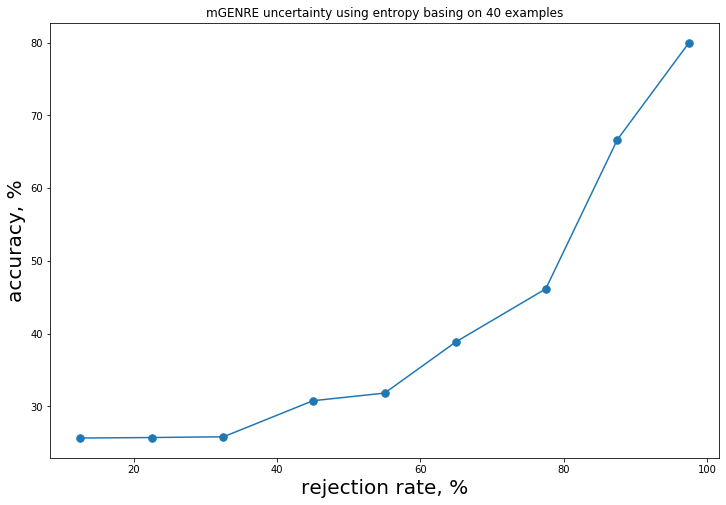

In [69]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.title("mGENRE uncertainty using entropy basing on 40 examples")
plt.plot(share_of_observations_entropy_40[::-1], accuracy_entropy_40, marker = '.', markersize = 15);

# Experiment on 1000 data

In [343]:
n = 1000
start_time = datetime.now()

divider = 20

mGENRE_results_entropy = []
for i in range(divider):
    random.seed(i)
    torch.manual_seed(i)
    np.random.seed(i)
    mGENRE_results_entropy.append(model_mGENRE_mcdropout.sample(list(data.sample(n = 50, replace = False, random_state=i).loc[:, "question"]),
                                  beam = 10,
                                  prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                      e for e in trie.get(sent.tolist())
                                      if e < len(model_mGENRE_mcdropout.task.target_dictionary)
                                  ],
                                  text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                  marginalize=True,
                                  verbose = True,
                                  seed = i))
    print("\n")
    print("part ", i, " done!")


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))




part  0  done!


part  1  done!


part  2  done!


part  3  done!


part  4  done!


part  5  done!


part  6  done!


part  7  done!


part  8  done!


part  9  done!


part  10  done!


part  11  done!


part  12  done!


part  13  done!


part  14  done!


part  15  done!


part  16  done!


part  17  done!


part  18  done!


part  19  done!
Duration: 0:46:13.297494


In [350]:
objects_1000_entropy = []
for i in range(divider): 
    objects_1000_entropy.append(list(data.sample(n = 50, replace = False, random_state=i).loc[:, "object"]))

In [354]:
objects_1000_entropy = sum(objects_1000_entropy, [])

In [364]:
mGENRE_results_entropy = sum(mGENRE_results_entropy, [])

In [366]:
a = list(np.array([np.array([i['score']for i in mGENRE_results_entropy[j]]) for j in range(len(mGENRE_results_entropy))]))
probs_for_examples = [i.tolist() for i in a]
quants = [thresh/9 for thresh in range(1, 10)]
entropies = [scipy.stats.entropy(i) for i in probs_for_examples]
thresholds = [np.quantile([scipy.stats.entropy(i) for i in probs_for_examples], q) for q in quants]


In [368]:
predictions = [i[0]['id'] for i in mGENRE_results_entropy]
accuracy_entropy_1000 = []
share_of_observations_entropy_1000 = []

for threshold in thresholds[:]:
    
    
    list_a = list(range(1000))
    fil = entropies < threshold
    
    
    y_pred = list(compress(predictions, fil))
    y_true = list(compress(objects_1000_entropy, fil))
    
    result = [x in y_pred for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 4)*100
    accuracy_entropy_1000.append(accuracy)
    share = np.round(len(result)/n*100, 4)
    share_of_observations_entropy_1000.append(share)
    
    print("threshold = ", format(threshold, '.2f'), "\t",
          "accuracy = ", format(accuracy, '.2f'), "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ",  format(share, '.2f'), "%")

threshold =  1.92 	 accuracy =  50.45 %	 number of observations =  111 	 share of observations =  11.10 %
threshold =  2.05 	 accuracy =  41.44 %	 number of observations =  222 	 share of observations =  22.20 %
threshold =  2.14 	 accuracy =  37.54 %	 number of observations =  333 	 share of observations =  33.30 %
threshold =  2.17 	 accuracy =  34.23 %	 number of observations =  444 	 share of observations =  44.40 %
threshold =  2.23 	 accuracy =  30.27 %	 number of observations =  555 	 share of observations =  55.50 %
threshold =  2.27 	 accuracy =  28.68 %	 number of observations =  666 	 share of observations =  66.60 %
threshold =  2.28 	 accuracy =  26.00 %	 number of observations =  777 	 share of observations =  77.70 %
threshold =  2.29 	 accuracy =  23.99 %	 number of observations =  888 	 share of observations =  88.80 %
threshold =  2.30 	 accuracy =  21.82 %	 number of observations =  999 	 share of observations =  99.90 %


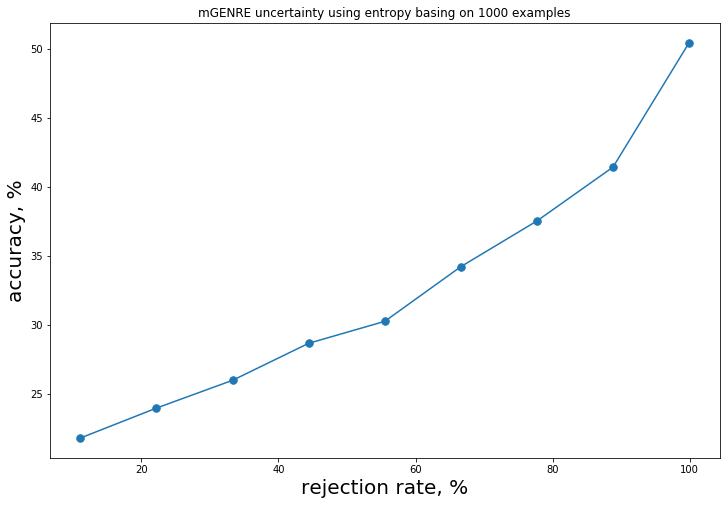

In [371]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.title("mGENRE uncertainty using entropy basing on 1000 examples")
plt.plot(share_of_observations_entropy_1000[::-1], accuracy_entropy_1000, marker = '.', markersize = 15);

## Add NER

In [89]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

class NER:
    def __init__(self, 
                 #text, 
                 model = "Babelscape/wikineural-multilingual-ner",
                 tokenizer = "Babelscape/wikineural-multilingual-ner"):
        
        #self.text = text
        self.model = model
        self.tokenizer = tokenizer
    
    def set_pipeline(self):   
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer)
        self.model = AutoModelForTokenClassification.from_pretrained(self.model)
        self.nlp = pipeline("ner",
                            model = self.model,
                            tokenizer = self.tokenizer)
        
    def receive_text(self, text):
        self.text = text
    
    def receive_words(self):
        self.text = re.sub('[!@#$?,]', '', self.text)
        out = re.split(r' ', self.text)
        return out
    
    
    def receive_enitity(self):
        ner_results = self.nlp(self.text)
        final = []
        result = [i["word"] for i in ner_results]
        print(result)
        for elem in result:    
            if (elem[:2] == "##") & (len(final) > 0):
                final[-1] = final[-1] + elem[2:]
            elif (elem[:2] == "##") & (len(final) == 0):
                final.append(elem[2:])
            else:
                final.append(elem)
        return final
    
    def text_with_marked_entities(self):
        output = ""
        entities = self.receive_enitity()
        list_of_words = self.receive_words()
        for word in list_of_words:
            if word not in entities:
                output = output + word + " "
            else:
                output = output + "[START] " + word +  " [END] "
        output = re.sub("\[END\] \[START\] ", "", output)
        output += "?"
        return output
    
    
        
    
    
  

In [81]:
data.head(20)

,object,property,subject,question
0,Q12439,R19,Q6106580,who is a musician born in detroit
1,Q6817891,P364,Q1568,what is the language in which mera shikar was ...
2,Q1297,R276,Q2888523,Whats the name of a battle that happened in ch...
3,Q193592,R413,Q5822614,what player plays the position midfielder?
4,Q6849115,P413,Q336286,what is the position that mike twellman plays
5,Q842256,R136,Q5962341,list some musical films
6,Q7273,P27,Q30,what is ellen swallow richards's nationality?
7,Q247643,P364,Q1860,What language is the show elementary broadcast...
8,Q6135854,P21,Q6581097,what is the gender of james hendry?
9,Q2405480,R106,Q231891,who was a voice actor?


In [76]:
changed_texts = []
question = data.loc[19480, "question"]
    
print("Initial question: \n", question)

# load text
ner.receive_text(text = question)

# receive text with marked entities
new_text = ner.text_with_marked_entities()
changed_texts.append(new_text)

In [79]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_mGENRE.to(device)

GENREHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(256001, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDro

In [84]:
list(data.loc[12:15, "question"])

['Name an album by serge gainsbourg',
 'what is a book by laura ingalls wilder ',
 'Who was the cinematographer for the film endless love?',
 'what is a documentary film about the media']

In [85]:
res = model_mGENRE.sample(
                    list(data.loc[12:15, "question"]),
                    beam = 3,
                    prefix_allowed_tokens_fn=lambda batch_id, sent: [
                        e for e in trie.get(sent.tolist())
                        if e < len(model_mGENRE.task.target_dictionary)
                    ],
                    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                    marginalize=True,
                    verbose = True
                )

In [97]:
res

[[{'id': 'Q1698',
   'texts': ['Serge Gainsbourg >> en',
    'Serge Gainsbourg >> fr',
    'Serge Gainsbourg >> nl'],
   'scores': tensor([-0.0887, -0.8734, -1.0391], device='cuda:0'),
   'score': tensor(-0.0471, device='cuda:0')}],
 [{'id': 'Q7738003',
   'texts': ['The Great Wilderness >> en'],
   'scores': tensor([-1.0489], device='cuda:0'),
   'score': tensor(-2.9667, device='cuda:0')},
  {'id': 'Q7774934',
   'texts': ['The Wilderness >> en'],
   'scores': tensor([-1.2900], device='cuda:0'),
   'score': tensor(-3.4131, device='cuda:0')},
  {'id': 'Q3518720',
   'texts': ['The Wilderness of the Beastlands >> en'],
   'scores': tensor([-2.5591], device='cuda:0'),
   'score': tensor(-8.4874, device='cuda:0')}],
 [{'id': 'Q316',
   'texts': ['Love >> en'],
   'scores': tensor([-1.1282], device='cuda:0'),
   'score': tensor(-2.2564, device='cuda:0')},
  {'id': 'Q7112632',
   'texts': ['List of film-related topics >> en'],
   'scores': tensor([-1.2069], device='cuda:0'),
   'score': ten

0. NERs - Stanza (this is Stanford NLP), DeepPavlov, lowercase problem


1. (OBJECT) QA with mGENRE without NER (like experimantal point)
1) take text
2) text to mGENRE
3) compare answer with object

2. (SUBJECT) Entity linking using mGENRE with NER (expected behaviour of mGENRE)
1) take text -> NER
2) text after NER -> mGENRE (expect that model will find subjects)   
3) compare subjects with true subjects in data

3. (SUBJECT) Entity linking using mGENRE without NER (expected behaviour of mGENRE)
1) take text -> mGENRE (expect that model will find subjects)
2) compare subjects with true subjects in data


4. (SUBJECT) entity linking using mGENRE with syntactinc parsing 
(субъект ищет субъект = подлежащее и/или предикат = глагол),в старт и енд выделяем субъект = подлежащее
(https://github.com/vladislavneon/kbqa-tools/blob/master/rubq-baseline/entity_recognition.py)
1) take text -> syntactinc parser
2) text after syntactinc parser -> mGENRE (expect that model will find subjects)   
3) compare subjects with true subjects in data

In [91]:
from tqdm import tqdm

In [92]:
# initialize class
method = "Babelscape/wikineural-multilingual-ner"

ner = NER(model = method,
          tokenizer = method)

# establish pipeline
ner.set_pipeline()


# NER
changed_texts = []
for question in tqdm(list(data.loc[12:15, "question"])):
    
    print("Initial question: \n", question)
    
    # load text
    ner.receive_text(text = question)
    
    # receive text with marked entities
    new_text = ner.text_with_marked_entities()
    print("new_text new_text: \n", new_text)
    changed_texts.append(new_text)

100%|██████████| 4/4 [00:00<00:00, 47.88it/s]

Initial question: 
 Name an album by serge gainsbourg
['ser', 'gains', '##bourg']
new_text new_text: 
 Name an album by serge [START] gainsbourg [END] ?
Initial question: 
 what is a book by laura ingalls wilder 
[]
new_text new_text: 
 what is a book by laura ingalls wilder  ?
Initial question: 
 Who was the cinematographer for the film endless love?
[]
new_text new_text: 
 Who was the cinematographer for the film endless love ?
Initial question: 
 what is a documentary film about the media
[]
new_text new_text: 
 what is a documentary film about the media ?


In [94]:
changed_texts

['Name an album by serge [START] gainsbourg [END] ?',
 'what is a book by laura ingalls wilder  ?',
 'Who was the cinematographer for the film endless love ?',
 'what is a documentary film about the media ?']

In [95]:
res_subject = model_mGENRE.sample(
                    changed_texts,
                    beam = 3,
                    prefix_allowed_tokens_fn=lambda batch_id, sent: [
                        e for e in trie.get(sent.tolist())
                        if e < len(model_mGENRE.task.target_dictionary)
                    ],
                    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                    marginalize=True,
                    verbose = True
                )

In [96]:
res_subject

[[{'id': 'Q1698',
   'texts': ['Serge Gainsbourg >> en', 'Serge Gainsbourg >> fr'],
   'scores': tensor([-0.3615, -1.0019], device='cuda:0'),
   'score': tensor(-0.7877, device='cuda:0')},
  {'id': 'Q1491304',
   'texts': ['Gainsbourg >> en'],
   'scores': tensor([-0.4464], device='cuda:0'),
   'score': tensor(-1.0935, device='cuda:0')}],
 [{'id': 'Q237514',
   'texts': ['Laura Ingalls Wilder >> en',
    'Laura Ingalls Wilder >> pl',
    'Laura Ingalls Wilder >> nl'],
   'scores': tensor([-0.1329, -0.6799, -0.7369], device='cuda:0'),
   'score': tensor(-0.0438, device='cuda:0')}],
 [{'id': 'Q388408',
   'texts': ['Endless Love (1981 film) >> en'],
   'scores': tensor([-0.5663], device='cuda:0'),
   'score': tensor(-1.7907, device='cuda:0')},
  {'id': 'Q7732098',
   'texts': ['The End of Love >> en'],
   'scores': tensor([-0.8899], device='cuda:0'),
   'score': tensor(-2.3545, device='cuda:0')},
  {'id': 'Q989611',
   'texts': ['Endless Love (1981 song) >> en'],
   'scores': tensor([-1.

In [49]:
from tqdm import tqdm

In [52]:
divider = 20
questions_1000 = []
for i in range(divider): 
    questions_1000.append(list(data.sample(n = 50, replace = False, random_state=i).loc[:, "question"]))

In [53]:
questions_1000 = sum(questions_1000, [])

In [54]:
# initialize class
method = "Babelscape/wikineural-multilingual-ner"

ner = NER(model = method,
          tokenizer = method)

# establish pipeline
ner.set_pipeline()


# NER
changed_texts = []
for question in tqdm(questions_1000):
    
    print("Initial question: \n", question)
    
    # load text
    ner.receive_text(text = question)
    
    # receive text with marked entities
    new_text = ner.text_with_marked_entities()
    changed_texts.append(new_text)
#     print("NER over initial question: \n", new_text)
    
#     print("\n")
#     print("#"*100)

  0%|          | 5/1000 [00:00<00:24, 41.30it/s]

Initial question: 
 Where is mónika veres from
['món']
Initial question: 
 where did franco angrisano die
['franco']
Initial question: 
 What actor was born in lodz
[]
Initial question: 
 what position does lee goodwin play in soccer
['soccer']
Initial question: 
 What was the nationality of vincent riotta
[]
Initial question: 
 which film is joie lee a story contributor for
[]
Initial question: 
 Where in europe was victim five filmed
['euro', '##pe']
Initial question: 
 which ethnicity is aloyisus leon higginbotham, jr.


  2%|▏         | 15/1000 [00:00<00:23, 41.65it/s]

['al', '##oy']
Initial question: 
 Who is the artist from the artwork flagellation of christ
[]
Initial question: 
 What college basketball coach was born in ellwood city?
['ell', '##wood']
Initial question: 
 who is a writer of a movie called white mischief
['white']
Initial question: 
 Name a character of the male gender
[]
Initial question: 
 What is virjibhai thummar's nationality?
['vir']
Initial question: 
 Who is a notable goalkeeper
[]
Initial question: 
 What genre of film is you only loved me twice?
[]
Initial question: 
 what is richard low's gender
[]
Initial question: 
 what type of movie is the border?
[]
Initial question: 
 Which gender is lily broberg


  2%|▎         | 25/1000 [00:00<00:22, 42.42it/s]

['li']
Initial question: 
 what is karl paryla's gender?
['kar']
Initial question: 
 What kind of film is public telephone?
[]
Initial question: 
 what kind of music is on sheila e.?
['she', '##ila']
Initial question: 
 where did fridolin von senger und etterlin die?
['fri', '##dol']
Initial question: 
 who was born in the location of mexico city?
['me', '##xico']
Initial question: 
 dino de laurentiis  produced what film
['din', '##o', 'de', 'lau', '##rent', '##iis']
Initial question: 
 where in germany was emil rameau's place of death?
['german']
Initial question: 
 Which country is julian richings from
['juli', '##an']
Initial question: 
 What kind of celestial object is zeta canis minoris


  4%|▎         | 35/1000 [00:00<00:22, 42.45it/s]

['ze', '##ta']
Initial question: 
 what is daniel altman's gender
['dan']
Initial question: 
 Which city and state was dennis johnson born in
['denn']
Initial question: 
 what country gives nationality to ibrahim mahlab
[]
Initial question: 
 Who produced my wifes relations
[]
Initial question: 
 Who was the author of the fireclown?
[]
Initial question: 
 what is an episode written by michelle ashford
['mich', '##elle', 'ash', '##ford']
Initial question: 
 what kind of film is drop squad
[]
Initial question: 
 where is the movie even pigeons go to heaven from 
[]
Initial question: 
 where was peter woodthorpe born


  4%|▍         | 40/1000 [00:00<00:21, 43.95it/s]

['pet']
Initial question: 
 where does dorothy garlock hold a passport 
['dor']
Initial question: 
 who was from henan
['hen']
Initial question: 
 what is the title of an administrative division in the united kingdom
[]
Initial question: 
 where in the world was jeannette batti born
['je', '##tte']
Initial question: 
 which city did francis warrington gillet die
['franc']
Initial question: 
 What is the name of an album from arcade fire
[]
Initial question: 
 What is lee nerison's place of birth?
['le', '##e', 'ner', '##ison']
Initial question: 
 Where was mike todorovich born


  5%|▌         | 50/1000 [00:01<00:23, 40.10it/s]

['mi', 'todo', '##rov', '##ich']
Initial question: 
 Which style of architecture is the wayne morse farm
['way', '##ne']
Initial question: 
 What is the nationality of doc cheatham?
['doc']
Initial question: 
 what's the default language of scenes from a mall
[]
Initial question: 
 who was born in cambodia?
['cam', '##bod', '##ia']
Initial question: 
 Which religion does jimmy delshad identify with 
['jim']
Initial question: 
 Name a person born in geseke.
['ge', '##sek', '##e']
Initial question: 
 What is a movie pierce brosnan produced?
[]
Initial question: 
 What kind of music is featured on ten new songs
[]
Initial question: 
 which episode was written by chris carter (screenwriter)


  6%|▌         | 60/1000 [00:01<00:21, 43.18it/s]

['ch']
Initial question: 
 What kind of celestial object is 1495 helsinki?
['hel', '##sin', '##ki']
Initial question: 
 what is chris offutt's gender 
['ch', 'off', '##utt']
Initial question: 
 Who is an african american character actor and retired professional wrestler? 
['af', '##rica', '##n', 'american']
Initial question: 
 Name a professional writer
[]
Initial question: 
 Which country is marcel landers from?
[]
Initial question: 
 what is an example of a city that can be found in  north american central time zone
['american']
Initial question: 
 In what language was inside man filmed?
[]
Initial question: 
 what genre is serpico in?
[]
Initial question: 
 What type of music is bobby kildea known for
['bob', '##by', 'ki', '##lde', '##a']
Initial question: 
 what was earle birney's birth place


  7%|▋         | 72/1000 [00:01<00:18, 49.98it/s]

['##ney']
Initial question: 
 who created the album the traveling wilburys collection
['wil', '##bury']
Initial question: 
 What kind of music does roman holiday record?
['roman']
Initial question: 
 What game play mode is the computer video game Yoshis Safari?
['Yo', '##shi', '##s', 'Safari']
Initial question: 
 Where exactly was marian goliński born
['mari', '##an', 'goli']
Initial question: 
 what type of album is after hours at the london house 
['lo']
Initial question: 
 what nationality is simon scardifield
['sim']
Initial question: 
 What film did mansoor khan contribute to?
['mans', '##oor']
Initial question: 
 what time zone is lindstrom in
['li']
Initial question: 
 what is mohamed safwat's gender
[]
Initial question: 
 which german city is faiz kevin mangat from
['german']
Initial question: 
 What nation is tulsi ramsay from?
['tu', '##ls', '##i']
Initial question: 
 Where did william hedgcock die


  8%|▊         | 84/1000 [00:01<00:17, 53.87it/s]

['will']
Initial question: 
 what is sonja skarstedt's place of birth?
['son', '##ja', 'ska', '##rst', '##edt']
Initial question: 
 who is someone born in barcelona
['bar', '##cel', '##ona']
Initial question: 
 What position does uroš tripković play?
['ur', '##oš']
Initial question: 
 what's kumar sangakkara's ethnicity?
[]
Initial question: 
 What is an album that was released by marc almond?
['marc', 'al', '##mond']
Initial question: 
 Which city was thilo kleibauer born in
['thi', '##lo', 'kl']
Initial question: 
 who is a parent of casey johnson
['case']
Initial question: 
 which artist records under columbia records
['col', '##um', '##bia']
Initial question: 
 Name a film written by jerry lewis
['jer']
Initial question: 
 What is 10161 nakanoshima classified as
['nak', '##anos', '##hima']
Initial question: 
 what series has the episode rosebud
[]
Initial question: 
 which artist records under the earache records label


 10%|▉         | 96/1000 [00:02<00:16, 56.09it/s]

['ear', '##ache']
Initial question: 
 This jazz was released in 1959.
['jazz']
Initial question: 
 what does 1255 schilowa orbit
['##a']
Initial question: 
 what games were published by ea sports
['ea']
Initial question: 
 Who is a missionary that was buried in highgate cemetery
['high']
Initial question: 
 Which city was robert s. langer born in
['robe', '##rt', 's', 'langer']
Initial question: 
 what religion does swaran singh practice
['s', '##wara']
Initial question: 
 Which label is the artist gil evans signed to
['W', 'gi']
Initial question: 
 which city was william grant stairs born
['will']
Initial question: 
 who wrote city of women
[]
Initial question: 
 where was carolyn mitchell born?
['car', '##ol', '##yn']
Initial question: 
 in what language was earthlings filmed
[]
Initial question: 
 Who was born in greenville, south carolina?


 11%|█         | 108/1000 [00:02<00:17, 51.86it/s]

['green', 'car']
Initial question: 
 what was the gender of the fictional character barry ohanlon
['bar', '##han', '##lon']
Initial question: 
 Which city was robert s. langer born in
['robe', '##rt', 's', 'langer']
Initial question: 
 what prince consort is princess alice of the united kingdom's father
[]
Initial question: 
 What is ludwig marcuse's gender?
['lu', '##dw', '##ig']
Initial question: 
 Where in italy did giuseppe chiappella die?
['it']
Initial question: 
 what is the language in the film manthri gari viyyankudu
['##yy', '##ank', '##udu']
Initial question: 
 what is sherman hemsley's race
['she']
Initial question: 
 What is the profession of anthea turner?
[]
Initial question: 
 what country is  charlie hough from
[]
Initial question: 
 which country is hikaru yamamoto from


 12%|█▏        | 115/1000 [00:02<00:16, 54.59it/s]

[]
Initial question: 
 What is the name of the weather channels smooth jazz album
[]
Initial question: 
 Which baseball player plays right fielder?
['baseball']
Initial question: 
 What's an example of a disaster film
[]
Initial question: 
 what is a musical film
[]
Initial question: 
 who is a guitar instrumentalist
[]
Initial question: 
 who is a punk rock artist
['punk']
Initial question: 
 Who is an example of a forward
['Who']
Initial question: 
 Name a professional lawyer.
[]
Initial question: 
 what gender is mary omalley?
['mar']
Initial question: 
 which country is cruel jaws filmed in?
[]
Initial question: 
 What's a video game published by sce studio liverpool
[]
Initial question: 
 Which position is played by chris wright
['ch']
Initial question: 
 who is father of vyasa


 13%|█▎        | 128/1000 [00:02<00:15, 56.01it/s]

['vya', '##sa']
Initial question: 
 What kind of celestial object is 23855 brandonshih
['238', '##ons']
Initial question: 
 who is a person born in ferrol
['ferro', '##l']
Initial question: 
 what biological gender is gerald mccullouch
['m', '##cc']
Initial question: 
 who created the fictional characterd oomsday
['##d', 'o', '##oms', '##day']
Initial question: 
 what nationality is Isa Abdul-Quddus?
['Isa', 'Abdul', '-', 'Qu', '##ddu', '##s']
Initial question: 
 Name a book written by david almond
['da']
Initial question: 
 Who was born in Svendborg?
['Sven', '##d', '##borg']
Initial question: 
 Who was the author of homeward bound
[]
Initial question: 
 who is the producer of blood money
[]
Initial question: 
 What baseball position does wally gerber play?
['baseball']
Initial question: 
 which gender is sampie terreblanche
['sam']
Initial question: 
 what is david bazay's gender?


 14%|█▍        | 142/1000 [00:02<00:14, 58.77it/s]

['da']
Initial question: 
 what war was samuel w. koster a part of 
['sam']
Initial question: 
 what football position does simon hofer play at?
['sim', '##on', 'hof', '##er']
Initial question: 
 who is bernard fanning signed with
['bern', '##ard']
Initial question: 
 What is (6303) 1989 el2?
['1989']
Initial question: 
 Where did john proctor die?
['Where', 'jo', '##hn']
Initial question: 
 where was martin bormann born
['mart']
Initial question: 
 what kind of music can be found on the album direction
[]
Initial question: 
 What does al waxman do for a living
['al']
Initial question: 
 who was born in cleveland, ohio
['ohi']
Initial question: 
 which movie was written by kirsten smith
['ki', '##rst', '##en']
Initial question: 
 what type of music is no more loud music: the singles
[]
Initial question: 
 who directed the savage is loose
[]
Initial question: 
 Which position does marko ljubinković play?


 15%|█▌        | 154/1000 [00:03<00:14, 58.13it/s]

['mark', '##inko', '##vić']
Initial question: 
 Who would be rock and roll
[]
Initial question: 
 who recorded christmas with yolanda adams
[]
Initial question: 
 What country was love at twenty filmed in
[]
Initial question: 
 What is the nationality of Ștefan kovács
['Ștefan', 'ko', '##vá', '##cs']
Initial question: 
 who was the author of the book titled  the six wives of henry viii
['wi', '##ves', 'of', 'hen', '##ry']
Initial question: 
 who was in beneath the valley of the ultra-vixens
['ultra']
Initial question: 
 What is the name of a city in gratiot county
[]
Initial question: 
 where did kurt hoffmann die?
['kur']
Initial question: 
 what country is love of grass leaves filmed in?
[]
Initial question: 
 What is the name of a poetry book?
[]
Initial question: 
 What is wilferd madelung's gender?
['wil', '##ferd']
Initial question: 
 What position did famara diedhiou play?


 17%|█▋        | 168/1000 [00:03<00:13, 59.85it/s]

['fama', '##ra', 'died', '##hio', '##u']
Initial question: 
 which player plays the midfielder football position
[]
Initial question: 
 What book did andre norton write?
['andre']
Initial question: 
 Name a politician
[]
Initial question: 
 which city did frank farrington decease in
[]
Initial question: 
 What kind of celestial object is 23855 brandonshih
['238', '##ons']
Initial question: 
 which game has single-player
[]
Initial question: 
 which language was spoken in strange fascination
[]
Initial question: 
 who is signed under the label tabu recordings
['tab', '##u']
Initial question: 
 what gender is peter dörfler 
['pet', '##er']
Initial question: 
 which footballer was born in keflavík?
['ke', '##f', '##lav', '##ík']
Initial question: 
 what is tilo wolff's chose style of music
['til', '##o']
Initial question: 
 Who is the child of raj kapoor?
['##oor']
Initial question: 
 what baseball player plays as a first baseman 


 18%|█▊        | 180/1000 [00:03<00:13, 59.26it/s]

['baseball']
Initial question: 
 where did bruce jackson die
[]
Initial question: 
 who was the military personnel involved in the world war ii?
[]
Initial question: 
 who recorded zetima
['ze', '##tima']
Initial question: 
 who was the music composer for susan lenox (her fall and rise)?
['sus', '##an', 'len']
Initial question: 
 which musician made live
[]
Initial question: 
 in what language was earthlings filmed
[]
Initial question: 
 who has a place of birth in moscow
['mos']
Initial question: 
 What is the name of a book that is classified as detective fiction
[]
Initial question: 
 which political party pursues libertarian socialism
['liber', '##tarian']
Initial question: 
 what is the gender of jay o'brien
['ja', '##y', 'o', "'", 'br', '##ien']
Initial question: 
 Is william atkins a male or female
['will', '##iam']
Initial question: 
 what position does  kieron st aimie play in soccer


 19%|█▉        | 193/1000 [00:03<00:13, 59.59it/s]

[]
Initial question: 
 which orbit has relationship with 2301 whitford
['230', '##1', 'w', '##hit', '##ford']
Initial question: 
 where was bridget of york born 
[]
Initial question: 
 what city and state was neil goldschmidt born in
[]
Initial question: 
 What sex is tasha yar's character
['tas', '##ha', 'ya', '##r']
Initial question: 
 Which position is played by dusty ryan in baseball
['baseball']
Initial question: 
 which english city was david buck born in
['engl', '##ish']
Initial question: 
 what is a horror film?
[]
Initial question: 
 whirl tour is what type of video game?
['w', '##hir', '##l', 'tour']
Initial question: 
 what sex is otto chr. bastiansen
['bas']
Initial question: 
 what is edgar lee mcwethy, jr.'s gender
['ed', '##gar', 'le', '##e', 'm', '##c', '##wet', '##hy', ',', 'jr']
Initial question: 
 what country is charles town, west virginia in
['vir', '##gini']
Initial question: 
 What is the name of a popular album by ryuichi sakamoto


 20%|██        | 205/1000 [00:03<00:14, 56.53it/s]

['ry']
Initial question: 
 What is the gender of jeremiah burrell
['jer', '##emia']
Initial question: 
 what position does john wilson play
['jo', '##hn', 'wil', '##son']
Initial question: 
 which track is created by mark linkous
[]
Initial question: 
 what is the producing company of dark fall
[]
Initial question: 
 What kind of music is on the art of fingerstyle jazz guitar
[]
Initial question: 
 angus r. goss was born where in the United States?
['United', 'States']
Initial question: 
 what country was a musical monologue produced
[]
Initial question: 
 What genre of film is images in a convent
[]
Initial question: 
 what films have been directed by kenji mizoguchi?
['ken', '##ji']
Initial question: 
 which state is patrick tracy burris from
['pat']
Initial question: 
 Which language is the film chauranga in
['W', 'language']
Initial question: 
 What is the name of the developer that developed avengers


 22%|██▏       | 217/1000 [00:04<00:13, 57.08it/s]

[]
Initial question: 
 which female model was born in sydney
['syd', '##ney']
Initial question: 
 What position did chris anstey play in basketball?
['basketball']
Initial question: 
 what is mario novelli's gender
['mari', '##o', 'novel']
Initial question: 
 what county is dock junction a part of
[]
Initial question: 
 what type of video game is sprung?
[]
Initial question: 
 who created deadliest catch?
[]
Initial question: 
 what position does ian brightwell play in football?
['ia']
Initial question: 
 which language audience was ongka's big moka released to first
['on', '##gka']
Initial question: 
 Who plays the position of forward?
[]
Initial question: 
 What killed george o'hanlon
['o', "'", 'han']
Initial question: 
 What position does footballer gary lavery play?
[]
Initial question: 
 what ethnicity is kyoko nakajima


 23%|██▎       | 231/1000 [00:04<00:13, 58.90it/s]

['ky']
Initial question: 
 Which genre is the artist sandro de américa?
[]
Initial question: 
 What is the name of a cantopop?
[]
Initial question: 
 What is the architectural style of palais garnier
['palais', '##nier']
Initial question: 
 what county is bradley beach, new jersey a part of
['bra']
Initial question: 
 what position does samuel itondo play 
['sam', '##uel']
Initial question: 
 which position does tony kenworthy play
[]
Initial question: 
 What was a book william tenn wrote?
['will', '##iam', 'ten']
Initial question: 
 which country does w. francis mcbeth come from
['franc']
Initial question: 
 what position does ignas dedura play
['ig', '##nas', 'de', '##dura']
Initial question: 
 which soccer position does muhannad naim play
['mu']
Initial question: 
 são vicente is a second level division of what country
['são', 'vice', '##nte']
Initial question: 
 what movie is written by hal roach?
['hal']
Initial question: 
 

 24%|██▍       | 243/1000 [00:04<00:12, 58.67it/s]

what structure is an example of colonial revival architecture?
[]
Initial question: 
 what position does baseball player norm mcneil play
['baseball']
Initial question: 
 what gender is devra davis 
['de', 'da']
Initial question: 
 What country was ambush murders made in?
[]
Initial question: 
 what is dubmood's gender
['dub']
Initial question: 
 which country did the devils daughter come from 
[]
Initial question: 
 what is the nationality of  jonathan malen
['jo']
Initial question: 
 which state did johnny lipon die
[]
Initial question: 
 who was born in trieste
['tries', '##te']
Initial question: 
 What is Byron Chamberlain's birthplace?
['Byron', 'Chamberlain']
Initial question: 
 is daviddevantandhisspiritwife indie rock or classical
[]
Initial question: 
 who died from myocardial infarction


 25%|██▍       | 249/1000 [00:04<00:13, 56.47it/s]

[]
Initial question: 
 what kind of film is the sarnos: a life in dirty movies
[]
Initial question: 
 what type of film is ashanti
['ash', '##anti']
Initial question: 
 who released the album post
[]
Initial question: 
 Where did maría díaz cortés die?
['mar', '##ía']
Initial question: 
 what is mahbubeh bayat's country of nationality?
['mah']
Initial question: 
 where is the birthplace of joseph proust
['jos']
Initial question: 
 which county contains clayton
['clay']
Initial question: 
 What river is mulberry river apart of?
['mu', '##lbe', '##rry']
Initial question: 
 What kind of job does john clayton (sportscaster) do
['jo', '##hn', 'clay', '##ton']
Initial question: 
 which country released rifftrax
['ri', '##fft']
Initial question: 
 What kind of music does roman holiday record?
['roman']


 26%|██▌       | 262/1000 [00:04<00:12, 58.19it/s]

Initial question: 
 which state did johnny lipon die
[]
Initial question: 
 mahmud ii's nationality is where?
['mah', '##mu', '##d', 'ii']
Initial question: 
 what is a city in bullitt county
['bu', '##tt']
Initial question: 
 what category is 26251 kiranmanne in?
[]
Initial question: 
 What is the name of a man born in sydney?
['syd', '##ney']
Initial question: 
 what state was melora hardin born
['me']
Initial question: 
 Name a person born in Naugatuck.
['Na', '##ugat', '##uck']
Initial question: 
 what genre does the film rare birds belong to
[]
Initial question: 
 what is the nationality of mark ferner 
[]
Initial question: 
 what language is game filmed in
[]
Initial question: 
 what language is i have two mothers and two fathers available in?
[]
Initial question: 
 What's a blues-rock album by rory gallagher


 27%|██▋       | 274/1000 [00:05<00:12, 56.31it/s]

[]
Initial question: 
 What nation is al helfer from
[]
Initial question: 
 Who directed the film the rugrats movie?
['ru', '##grat']
Initial question: 
 where did otto huber die
['otto']
Initial question: 
 how did elizabeth mcbride die
['eli', '##za', '##beth']
Initial question: 
 What is the genre that elena kats-chernin falls under
['ele']
Initial question: 
 who is the director of ladyhawke 
['lady', '##hawk', '##e']
Initial question: 
 what book genre is the perks of being a wallflower 
['wall']
Initial question: 
 Where in southern california did barbara lawrence die
['cal', '##if', '##orn', '##ia']
Initial question: 
 What genre of music does we fell to earth make?
[]
Initial question: 
 What is the name of a new wave music band
['new']
Initial question: 
 is harry barnes a male or female person?


 29%|██▊       | 286/1000 [00:05<00:13, 53.41it/s]

['harr', '##y', 'barne']
Initial question: 
 What position does jack reilly play
['ja']
Initial question: 
 Which label is kenneth stover on?
['ken']
Initial question: 
 is viola male or female
['viola']
Initial question: 
 Where was the discovery stie of (6490) 1991 nr2 
[]
Initial question: 
 what position did dillon gee play
['dil', '##lon']
Initial question: 
 in what eastern european country is the pârâul pietros river located
['p', '##âr', '##âu', '##l']
Initial question: 
 What profession is herman david koppel
['her']
Initial question: 
 where in france was constantin guys' place of death?
['franc', '##e']
Initial question: 
 in what puerto rican town was carlos delgado born
['puerto', 'rica']
Initial question: 
 what albums are by black sabbath?
[]
Initial question: 
 which german city was esad veledar born in


 30%|██▉       | 298/1000 [00:05<00:12, 56.34it/s]

['german']
Initial question: 
 What theatre of conflict occured in central europe?
['euro', '##pe']
Initial question: 
 Who produced the film death proof?
[]
Initial question: 
 Who was born in san jose, california?
['cal', '##if', '##orn']
Initial question: 
 Name someone born in cocagne, new brunswick.
['co', '##gne']
Initial question: 
 Where was rick sanchez born?
['ri', 'san', '##che', '##z']
Initial question: 
 Which country is abhinav bindra from
['ab', '##hina', '##v']
Initial question: 
 Where was narqath born
['nar']
Initial question: 
 Which position in football does ali pala play
['football']
Initial question: 
 which 1994 album was released by groovie ghoulies?
[]
Initial question: 
 What is the gameplay mode of deadlock: planetary conquest?
['dead']
Initial question: 
 where was walter silva born at?
['wa', 'sil', '##va']
Initial question: 
 What country produced the film Three Guys Named Mike.


 31%|███       | 311/1000 [00:05<00:12, 57.21it/s]

['Three', 'Guy', '##s', 'Named', 'Mike']
Initial question: 
 What is pavel fořt's position
['f']
Initial question: 
 who produced cruel intentions
[]
Initial question: 
 what conflict did victor crutchley participate in
[]
Initial question: 
 What is the hud county place of moore county
['mo']
Initial question: 
 is meiyang chang male or female
['mei']
Initial question: 
 what is a area in cibola county, new mexico
['cibo', '##la']
Initial question: 
 what is a city in brazil?
['bra']
Initial question: 
 where was robert s. scott given birth
['robe']
Initial question: 
 what position does ryan nece play 
['ry', '##an']
Initial question: 
 What are some written works by bertolt brecht
['be', '##lt', 'br', '##echt']
Initial question: 
 where did hugo zöller die
['hu']
Initial question: 
 What's an album written by mýa
['m', '##ý']
Initial question: 
 Who is a parent of charoensri chanamayu


 32%|███▏      | 323/1000 [00:06<00:11, 57.10it/s]

['char', '##oen']
Initial question: 
 which country does the beznea river flow into
['bez', '##nea']
Initial question: 
 what is a 1976 soul music album
[]
Initial question: 
 what genre is howling bells 
[]
Initial question: 
 which city did paul andréota pass away
['##ota']
Initial question: 
 What is Claire Stansfield's nationality?
['Claire', 'Stan', '##sfield']
Initial question: 
 what is sarah jarosz's gender
['ja', '##ros', '##z']
Initial question: 
 what coast does was nominated for Classical Album of the Year declare nationality
['Classical', 'Album', 'of', 'the', 'Year']
Initial question: 
 who is the artist on seven wishes
[]
Initial question: 
 which j-pop artist started out in 2003?
['j']
Initial question: 
 what game is played on multiplayer mode?
['multi']
Initial question: 
 Who is a soccer player that is a goalkeeper?
[]
Initial question: 
 Where was robert f. williams born?


 34%|███▎      | 335/1000 [00:06<00:11, 58.30it/s]

['robe', '##rt']
Initial question: 
 Who is madurodam named after
['ma', '##dur', '##oda']
Initial question: 
 what is the nationality of thad h. brown
['tha']
Initial question: 
 What is julia loktev's gender?
['juli', '##a']
Initial question: 
 Who is a female?
[]
Initial question: 
 what country is evgeniya belyakova from
['ev']
Initial question: 
 What is the name of a film in the war film genre?
[]
Initial question: 
 which country is alfred heurtaux from 
[]
Initial question: 
 which nationality is brian urlacher
['br']
Initial question: 
 what is the gender of clarence demar
[]
Initial question: 
 where was the 1966 united states grand prix held
[]
Initial question: 
 which country is anna friel from
[]
Initial question: 
 who directed the film the pillow book
[]
Initial question: 
 What did tibor fischer write?


 35%|███▍      | 347/1000 [00:06<00:11, 54.50it/s]

['ti', '##bor', 'fi', '##scher']
Initial question: 
 Which country is the film platform from
['W']
Initial question: 
 what type of celestial body is 39678 ammannito
['396', 'am', '##mann']
Initial question: 
 is kristjan sarv male or female
['kr', '##ist']
Initial question: 
 which country is the movie fox and his friends from
[]
Initial question: 
 What is the name of a Virginia county located in the united states?
['Virginia']
Initial question: 
 who is an outfielder
[]
Initial question: 
 What is the nationality of miklós ybl
['mi', '##kl', '##ós', 'y', '##bl']
Initial question: 
 What gender is fred f. sears
['fred']
Initial question: 
 What type of film is in the shadow of the wind
[]
Initial question: 
 What country is Matias Mirabaje from?
['Mat', '##ias', 'Mira', '##ba', '##je']
Initial question: 
 which album did cher release in 1982


 36%|███▌      | 360/1000 [00:06<00:11, 55.82it/s]

[]
Initial question: 
 Where was teresa rabal born
['ter', '##esa', '##bal']
Initial question: 
 who are popular psychedelic rock artists
['ps']
Initial question: 
 what is the gameplay mode of rallisport challenge
['ra', '##llis']
Initial question: 
 What is the country of origin for the film kiss the blood off my hands?
[]
Initial question: 
 In which municipality did richard katz die?
[]
Initial question: 
 who is sigismund i the old's child?
['sig', '##ismu']
Initial question: 
 what language is django shoots first spoken in?
['dj', '##ang', '##o']
Initial question: 
 What is the name of a swedish guitar instrumentalist?
['s', '##wed', '##ish']
Initial question: 
 what sort of book is the white album
[]
Initial question: 
 Which city is located inside allegheny county
['alle', '##ghe', '##ny']
Initial question: 
 what is a documentary film about food
[]
Initial question: 
 what is greg hands's country of origin?


 37%|███▋      | 373/1000 [00:06<00:11, 56.48it/s]

['gr', '##eg']
Initial question: 
 what constellation is phi piscium in
['phi']
Initial question: 
 who was born in belgrade?
['bel']
Initial question: 
 what is stephen rebello's country of origin?
['step']
Initial question: 
 Who produced the album once upon a star
['Who']
Initial question: 
 What artist would be called pop music
['pop']
Initial question: 
 where was john t. deweese burried
['##we']
Initial question: 
 Name a football player who plays as a midfielder.
[]
Initial question: 
 which country is black magic from
[]
Initial question: 
 who is the artist that created the album  blood of the earth
['blood', 'of']
Initial question: 
 What is the gender of aaron freeman?
['aa', '##ron']
Initial question: 
 what type of music does does it look like im here? have on it
[]
Initial question: 
 what film was pritam the music contributor for


 38%|███▊      | 379/1000 [00:07<00:11, 54.78it/s]

['prit', '##am']
Initial question: 
 what country is georges de moor a citizen of
[]
Initial question: 
 What war did walter bedell smith take part in
['wa']
Initial question: 
 What is the language of the film the waiting game?
[]
Initial question: 
 Where dii antun gustav matoš die
['Where', 'di', '##i']
Initial question: 
 what was gil friesen's place of death
['fri']
Initial question: 
 which country released 8 heads in a duffel bag
[]
Initial question: 
 who produced block busters?
[]
Initial question: 
 Who is vagif mustafazade's daughter
['must', '##zade']
Initial question: 
 Name a drama film.
[]
Initial question: 
 What label was dennis coffey signed to?
['denn', '##is']
Initial question: 
 what is the religion of roger garaudy?
[]
Initial question: 
 where in france was marian hannah winter born in?


 39%|███▉      | 392/1000 [00:07<00:11, 55.24it/s]

['franc']
Initial question: 
 which gender does joseph beckham belong to
['jos']
Initial question: 
 which film is joie lee a story contributor for
[]
Initial question: 
 what kind of music is daqui pro futuro
['da']
Initial question: 
 what gender is shahrum kashani 
['sh']
Initial question: 
 which central asian city was isaak illich rubin's place of death?
['asi']
Initial question: 
 Which religion does phumzile mlambo-ngcuka practice?
[]
Initial question: 
 which 1980s band released the album adventures of the smart patrol?
['adventure', '##s', 'of', 'the', 'smart', 'patrol']
Initial question: 
 what label is virgin prunes worth?
[]
Initial question: 
 What sport do the Dallas Stars play?
['Dallas', 'Stars']
Initial question: 
 What is the genre of jane winton
['jan']
Initial question: 
 Who was born in belle fourche?
[]
Initial question: 
 what italian footballer was born in ardea (rm)


 40%|████      | 404/1000 [00:07<00:10, 55.06it/s]

['italian', 'ar']
Initial question: 
 Name a japanese multiplayer video game released in Super Famicon.
['jap', 'Super', 'Fam', '##ico', '##n']
Initial question: 
 what is karl von vierordt's gender?
['kar', '##l', 'von', '##ord']
Initial question: 
 what type of film is the cowboy and the lady
[]
Initial question: 
 List a ps4 game published by sony computer entertainment
['ps', '##4']
Initial question: 
 where was hou baolin born
['hou', 'bao', '##lin']
Initial question: 
 what is the name of the place where john paul phelan was born
['jo']
Initial question: 
 Which style of architecture is the wayne morse farm
['way', '##ne']
Initial question: 
 Where was the place of death for marik vos-lundh
['mari']
Initial question: 
 whats the name of the artist that released the one and only
[]
Initial question: 
 Which baseball player plays right fielder?
['baseball']
Initial question: 
 Name an artist on emi record label


 42%|████▏     | 416/1000 [00:07<00:10, 54.42it/s]

['em', '##i']
Initial question: 
 what's the main gameplay mode of jaseiken necromancer
['ja', '##sei', '##ken']
Initial question: 
 what is raynald denoueix's place of birth?
['ray']
Initial question: 
 what is the cvg genre of timesplitters
['c', '##v', '##g']
Initial question: 
 what is the primary language of the film fly away baby
['fly', 'away']
Initial question: 
 what films are by national film board of canada?
['can']
Initial question: 
 what was earle birney's birth place
['##ney']
Initial question: 
 which south korean singer is also an actor?
['kor', '##ean']
Initial question: 
 What country is giessenlanden a part of
['gie', '##ssen', '##lande', '##n']
Initial question: 
 What type of sports team is criciúma esporte clube?
['c', '##rici', '##ú', '##ma']
Initial question: 
 What is a work authored by jeffrey eugenides?
[]
Initial question: 
 Who directed ashik kerib


 43%|████▎     | 428/1000 [00:07<00:10, 54.18it/s]

['ash']
Initial question: 
 What gender is william smith
['will', '##iam']
Initial question: 
 what is reshad strik's sex?
['res', '##had']
Initial question: 
 which artist recorded super roots 7
['7']
Initial question: 
 what is enrico de nicola's profession 
[]
Initial question: 
 whos the composer of  numb
[]
Initial question: 
 What kind of metal is played on the final sign of evil
[]
Initial question: 
 what gender is ram prasad bismil
['ra']
Initial question: 
 what is an example of a horror film?
[]
Initial question: 
 who was the director of diary of a mad black woman (film)?
[]
Initial question: 
 Who was born in Saint Petersburg?
['Saint', 'Petersburg']
Initial question: 
 Who produced the film mutant


 44%|████▍     | 440/1000 [00:08<00:10, 55.23it/s]

['mu']
Initial question: 
 this person is from baton rouge, louisiana.
['bat', '##on', 'rouge', 'lo', '##uis']
Initial question: 
 which video game did square enix publish
[]
Initial question: 
 who is someone that died from  tuberculosis
[]
Initial question: 
 where was jonathan bar giora born?
['jo']
Initial question: 
 what is the genre of the album lágrimas y gozos
['lá', '##gri', '##mas', 'y', 'go', '##zos']
Initial question: 
 Where was nadine chandrawinata born
['nad', '##ine', 'chan', '##dra', '##win', '##ata']
Initial question: 
 what genre is the film  going upriver
[]
Initial question: 
 Where exactly was marian goliński born
['mari', '##an', 'goli']
Initial question: 
 What is leslie wright's profession? 
['les', '##lie']
Initial question: 
 Where did william boyle, 12th earl of cork and orrery pass away
[]
Initial question: 
 what book genre is the perks of being a wallflower 
['wall']
Initial question: 
 which country gave edward dannreuther his nationality


 45%|████▌     | 452/1000 [00:08<00:09, 55.83it/s]

[]
Initial question: 
 what position does adam carriker play
['adam']
Initial question: 
 what kind of book is on photography?
[]
Initial question: 
 what artist is on the record label v2 records?
['v', '##2']
Initial question: 
 what artist is on the album flight, bremen 1961?
[]
Initial question: 
 what is the sex of irving saraf?
['sa', '##raf']
Initial question: 
 What is the name of a documentary film on netflix
['net', '##f', '##x']
Initial question: 
 what genre of film is the shielding shadow?
[]
Initial question: 
 Where did dharamvir bharati die
['d', '##m', '##vir']
Initial question: 
 Who directed uncovered: the war on iraq
[]
Initial question: 
 what artist made the album rise up with fists!!
[]
Initial question: 
 Which nation is mehdi sahnoune from?
[]
Initial question: 
 What's a game that features a single-player mode


 46%|████▋     | 464/1000 [00:08<00:09, 55.50it/s]

[]
Initial question: 
 what is sandro aguilar's country of nationality?
['sand']
Initial question: 
 Where in europe is theodorus janssonius van almeloveen from
['euro']
Initial question: 
 where did john ellis martineau die
['jo']
Initial question: 
 what language is the front line in
['language']
Initial question: 
 who is a parent of alfonso ix of leon
['al', '##fon', '##so']
Initial question: 
 what is peggy wood's place of birth?
['pe']
Initial question: 
 Who was ptolemy ii philadelphus's father
['##hus']
Initial question: 
 what country is the great warrior skanderbeg portrayed in
['ska', '##nder']
Initial question: 
 what game is published by ea sports?
['ea']
Initial question: 
 what country is meng bo filmed in?
['men', '##g', 'bo']
Initial question: 
 what is ron husband's gender
['ro']
Initial question: 
 what genre of music is episode


 48%|████▊     | 476/1000 [00:08<00:10, 52.40it/s]

[]
Initial question: 
 who was the producer of danton (1983 film)
['dan', '##ton']
Initial question: 
 What country produced the film betrayed
[]
Initial question: 
 Name an artist on emi record label
['em', '##i']
Initial question: 
 what is a gameplay mode featured on everquest ii: desert of flames
['ever', '##quest']
Initial question: 
 where did albert dietrich die
['alb']
Initial question: 
 is reginald jacques male or female
['regina']
Initial question: 
 where was jean-baptiste bénard de la harpe born
[]
Initial question: 
 what label is emmanuel pahud on 
['em', '##manu', '##el']
Initial question: 
 what is a 1976 soul music album
[]
Initial question: 
 from which european is heinz günthardt from


 49%|████▉     | 488/1000 [00:09<00:09, 55.02it/s]

['europea']
Initial question: 
 where was beniamina kaintikuaba born 
[]
Initial question: 
 what is the nationality of paco clos?
['pa']
Initial question: 
 Which country did the film the galíndez file come from
['gal', '##ín', '##dez']
Initial question: 
 what is the nationality of loretta swit
['lore']
Initial question: 
 what is the genre of the album black caesar
[]
Initial question: 
 what is yahiro kazama's gender
['ya', '##hiro', 'ka', '##zama']
Initial question: 
 What language is an elephant called slowly filmed in?
[]
Initial question: 
 What city in Scotland was kevin bradley born in?
['Scotland']
Initial question: 
 What is tatsugo kawaishi's nationality
['tat']
Initial question: 
 which languages were spoken in yu ming is ainm dom?
['yu']
Initial question: 
 What films has rick pearson edited?
[]
Initial question: 
 Who is the artist that recorded the album ramble at the ryman


 49%|████▉     | 494/1000 [00:09<00:09, 51.39it/s]

['Who']
Initial question: 
 What soccer position does guillermo eizaguirre play
['gu', '##zag', '##uir']
Initial question: 
 who is a man born in delaware county, pennsylvania 
['dela', '##ware', 'penn', '##sy', '##lva', '##nia']
Initial question: 
 what country is cynthia mckinney a citizen of
[]
Initial question: 
 Who perished from a stroke
[]
Initial question: 
 what genre is howling bells 
[]
Initial question: 
 where was the 6666 frö discovered 
['666']
Initial question: 
 what kind of music is on singer of sad songs?
[]
Initial question: 
 what genre is the artist korey cooper
['kor']
Initial question: 
 Which city was roman aparicio born in
['roman']
Initial question: 
 Name a musician born in sheffield
['she', '##ffi']
Initial question: 
 What is the architectural style of the palm cottage house?


 51%|█████     | 507/1000 [00:09<00:09, 53.23it/s]

[]
Initial question: 
 What kind of music is featured on always
[]
Initial question: 
 of what nationality is  Ľudmila cervanová 
['Ľ', '##ud', '##mila', 'ce']
Initial question: 
 What is the name of a child of olaf eller
['What', '##f']
Initial question: 
 which nationality is idrees bashir
['id']
Initial question: 
 what musical genre does  brandon reilly create
['brand']
Initial question: 
 Where did istván kardos die
['ist']
Initial question: 
 what is the country of mark twain's nationality?
[]
Initial question: 
 which asteroid group is 1684 iguassú a part of
['1684', 'ig', '##uas', '##s', '##ú']
Initial question: 
 what is the name of a midfielder in football
[]
Initial question: 
 what language is bouboulina filmed in?


 51%|█████▏    | 513/1000 [00:09<00:09, 50.16it/s]

['bou', '##bou', '##lina']
Initial question: 
 What kind of gameplay mode does the game dynasty warriors 3 utilize? 
['##s', '3']
Initial question: 
 what gender is xiao qian
['x', '##ia', '##o', 'q']
Initial question: 
 What type of rock does hefner (band) play
['he', '##fn', '##er']
Initial question: 
 Name a center (basketball).
['basketball']
Initial question: 
 what album was done by kris kristofferson
['kr', '##is', 'kr']
Initial question: 
 what language is from pink eye
[]
Initial question: 
 What time zone is magnolia township included in
['mag', '##noli', '##a']
Initial question: 
 what organization was founded by  nils nilsson
['ni', '##ls']
Initial question: 
 which actress was born in ponca city 


 53%|█████▎    | 526/1000 [00:09<00:09, 50.89it/s]

['po', '##nca']
Initial question: 
 what's the default language of scenes from a mall
[]
Initial question: 
 which movie was written by stuart gordon
['st']
Initial question: 
 who wrote the film the skin
[]
Initial question: 
 what's k. c. singh baba gender
['what']
Initial question: 
 What's a gameplay mode in ghost pilots
[]
Initial question: 
 which military person was involved in world war i?
[]
Initial question: 
 whats joanna szczepkowska's gender
['joan', '##na', 'sz', '##cze', '##p', '##kow', '##ska']
Initial question: 
 genki dean died where
['gen', '##ki']
Initial question: 
 what type of music is the album frogstomp?
[]
Initial question: 
 what film did regurgitationmusic direct?
[]
Initial question: 
 what is nebula's gender 
['nebula']
Initial question: 
 what is 1601 patry 
[]
Initial question: 
 who was born in lockport?


 54%|█████▍    | 539/1000 [00:10<00:08, 53.44it/s]

['lock']
Initial question: 
 where did duncan gordon boyes pass away at?
['dun', '##can']
Initial question: 
 what position does georgios samaras play?
['ge', '##org']
Initial question: 
 what is the religion of roger garaudy?
[]
Initial question: 
 Where was charles deaton born?
['char', '##les', '##ton']
Initial question: 
 Name a record produce by the dream pop duo from Baltimore
['Baltimore']
Initial question: 
 What baseball position does tommy obrien as?
['baseball']
Initial question: 
 what country made resident evil: apocalypse
[]
Initial question: 
 what is the name of a multiplayer game
['multi']
Initial question: 
 Who is a person of the bengali people
['ben', '##gali']
Initial question: 
 what type of film is season of love?
[]
Initial question: 
 what county and state is brooklet located in


 55%|█████▌    | 551/1000 [00:10<00:08, 52.98it/s]

['bro', '##ok', '##let']
Initial question: 
 Who directed magic?
[]
Initial question: 
 who is a man born in delaware county, pennsylvania 
['dela', '##ware', 'penn', '##sy', '##lva', '##nia']
Initial question: 
 What is the name of a place located in erath county
['erat', '##h']
Initial question: 
 Where in the US was michael nichols born
['US']
Initial question: 
 what asteroid group is 5333 kanaya a member of
['533', '##3', 'kana', '##ya']
Initial question: 
 What is the fourth album from artist loudon wainwright iii?
[]
Initial question: 
 who is the performer of party queen
[]
Initial question: 
 What football position does sam slocombe 
[]
Initial question: 
 Which country is the film bittersweet memories from
[]
Initial question: 
 Who was the publisher for the computer videogame time commando?
[]
Initial question: 
 what country is steve gomer from
[]
Initial question: 
 what is an album from the artist alexia (italian singer)?


 56%|█████▋    | 563/1000 [00:10<00:08, 53.02it/s]

['italian']
Initial question: 
 who was michael gerald ford's mother
['mich', '##ael', 'geral', '##d', 'ford']
Initial question: 
 what position does denis odoi play
['od']
Initial question: 
 what film was  noel coward the film story contributor of
[]
Initial question: 
 what kinds of music is breaking things
[]
Initial question: 
 What is a film that mike figgis has written?
['mi']
Initial question: 
 who has gemini 7
['ge']
Initial question: 
 what game series is metal gear acid 2
[]
Initial question: 
 what is zamora's country of nationality?
['za', '##mora']
Initial question: 
 What's a movie that william goetz produced
['will', '##iam', 'go', '##etz']
Initial question: 
 what is june preisser's gender
['ju']
Initial question: 
 What position does felix chimaokwu play
['fel', 'chim', '##ao', '##k', '##wu']
Initial question: 
 who created the character dave gibbons


 57%|█████▊    | 575/1000 [00:10<00:07, 54.31it/s]

['da']
Initial question: 
 what position does john crowley play in baseball
['baseball']
Initial question: 
 which artist made the album best of dolly parton, vol. 3
[]
Initial question: 
 what is daniel altman's gender
['dan']
Initial question: 
 in which italian city did vanna brosio die
['italian']
Initial question: 
 what is a city located in west sumatra
['suma', '##tra']
Initial question: 
 where is christopher wood (english painter) from
['engl']
Initial question: 
 what is jim hegan's gender?
['jim', 'he', '##gan']
Initial question: 
 What is the name of a real-time strategy game
['real']
Initial question: 
 What is a film that vladimir tarasov is known for?
['v', '##ladi', '##mir', 'tar', '##aso', '##v']
Initial question: 
 what is a pop music album
[]
Initial question: 
 What instrument did pat bergeson played?


 59%|█████▉    | 588/1000 [00:10<00:07, 56.87it/s]

['pat', 'berg', '##eson']
Initial question: 
 Name an opera artist
[]
Initial question: 
 Who did the cinematography for the film limbo
[]
Initial question: 
 where is todd palin from
['to', '##dd']
Initial question: 
 what organization was founded by david ben-gurion
['da']
Initial question: 
 What type of music is in all aglow again!
[]
Initial question: 
 how did walter of châtillon die
[]
Initial question: 
 who was born in hamburg?
['ham', '##burg']
Initial question: 
 what movie did pierce brosnan produce and star in
[]
Initial question: 
 what position does pete liske play in american football
['american']
Initial question: 
 where did felix manalo die
[]
Initial question: 
 what city did manilal doctor pass away in?
['mani']
Initial question: 
 Who was a notable figure that was born in palo alto
[]
Initial question: 
 what kind of celestial body is 3416 dorrit?


 60%|██████    | 601/1000 [00:11<00:06, 57.92it/s]

[]
Initial question: 
 Where was jim caldwell born
['jim']
Initial question: 
 Who is someone that was born in bellshill
['bells']
Initial question: 
 where did cathy downs pass away in
['cat']
Initial question: 
 is rick fehr from the united states or canada
[]
Initial question: 
 which band created the catatonia platinum collection
['cat', '##aton', '##ia']
Initial question: 
 What is duncan cameron's gender
['dun', '##can', 'came']
Initial question: 
 Where was n.k. salil born
['sal']
Initial question: 
 What language is the film house of frankenstein recorded in?
['fra', '##nken', '##stein']
Initial question: 
 who was born in the location beaumont?
['beau', '##mont']
Initial question: 
 What is amber borycki's profession?
['amb', '##er', 'bor', '##yck', '##i']
Initial question: 
 what did pat roberts do as a career 
['pat']
Initial question: 
 What gender is lol solman


 61%|██████▏   | 614/1000 [00:11<00:06, 56.94it/s]

['lo', '##l']
Initial question: 
 how did charles david keeling die?
[]
Initial question: 
 what is steve shea's profession
['st', '##eve', 'she', '##a']
Initial question: 
 What country is the doctor and the devils from?
[]
Initial question: 
 what genre is howling bells 
[]
Initial question: 
 which team uses the buck shaw stadium as the home stadium
[]
Initial question: 
 from which country is bryce soderberg from
['br', 'so', '##berg']
Initial question: 
 what musician played the bass guitar?
[]
Initial question: 
 What is the gender of nicky jones
['nic']
Initial question: 
 is nick barmby male or female 
[]
Initial question: 
 how did charles ruggles die?
['char']
Initial question: 
 whats the lower classification of motacillidae
[]
Initial question: 
 who is the author of extreme measures?


 62%|██████▏   | 620/1000 [00:11<00:06, 54.78it/s]

[]
Initial question: 
 how would halil kut be classified regarding gender
[]
Initial question: 
 what type of movie was the netflix title  dont answer the phone
['net', '##f', '##li', '##x']
Initial question: 
 Who's a parent of james francis ginty
['jam']
Initial question: 
 What were the film story credits by vittorio mussolini?
['vit']
Initial question: 
 who is james i of scotland's son
['s', '##cot', '##land']
Initial question: 
 what is the nationality of jeff cotton
[]
Initial question: 
 what gender is arthur moore lascelles?
['art']
Initial question: 
 what kind of film was jesus?
['je', '##sus']
Initial question: 
 what language is alien intruder in?
[]
Initial question: 
 Which organization was founded by robert bosch
['W', 'robe']
Initial question: 
 where was Álvaro guerrero born
['Álvaro', 'guerre', '##ro']
Initial question: 
 Who is vairamuthu the child of?


 63%|██████▎   | 633/1000 [00:11<00:06, 57.12it/s]

['vai', '##ram', '##uth', '##u']
Initial question: 
 which city did christoffer gabel pass away in
['ch']
Initial question: 
 which body of water spanned by the parkersburg bridge
['park', '##ers', '##burg']
Initial question: 
 which disease caused willem rooseboom's death
['will', '##em', 'ro', '##ose', '##bo', '##om']
Initial question: 
 what nationality is ronald defeo, jr.?
['ro']
Initial question: 
 Who's a musician associated with astralwerks
['as', '##werks']
Initial question: 
 what structure is an example of châteauesque
['château']
Initial question: 
 Who's the directed credited for anna and the king of siam
[]
Initial question: 
 What instrument does brian karscig play?
['br']
Initial question: 
 what is the time zone of meadow brook township?
[]
Initial question: 
 whats josh heinrichs's biological sex
['he', '##in', '##rich']
Initial question: 
 What is the name of a country artist
[]
Initial question: 
 What is a film that chuck jones wrote?


 64%|██████▍   | 645/1000 [00:11<00:06, 56.78it/s]

['chu']
Initial question: 
 what genre does fair ground belong to
[]
Initial question: 
 what is jean a. stuntz's gender?
['je']
Initial question: 
 what is a city in jefferson county
['je', '##ffers', '##on']
Initial question: 
 which city in ireland was sean finn born
['finn']
Initial question: 
 Name a professional songwriter.
[]
Initial question: 
 What is the country of origin of the program alfred j. kwak?
['al', '##fre', '##d', 'j', '.', 'kwa', '##k']
Initial question: 
 where is ingram located 
['ing']
Initial question: 
 Who directed the film edward scissorhands
['ed', '##ward', 'sci', '##sso', '##r', '##hand', '##s']
Initial question: 
 which film is joie lee a story contributor for
[]
Initial question: 
 What is the music genre of the album yume miru uchuu?
['yu', '##me', 'mir', '##u', 'u', '##chu', '##u']
Initial question: 
 What is the name of a singer born in stockholm?
['stock', '##holm']
Initial question: 
 what type of book is a medicine for melancholy


 66%|██████▌   | 658/1000 [00:12<00:05, 57.50it/s]

[]
Initial question: 
 What country is elahi bux soomro from?
[]
Initial question: 
 what is the genre of the album boys night out
[]
Initial question: 
 is frank cook male or female
['fra']
Initial question: 
 who directed the secret agent club
[]
Initial question: 
 where did Óscar míguez die
['Óscar', 'míg', '##ue', '##z']
Initial question: 
 What language is spoken in portrait of hell
[]
Initial question: 
 who is the child of agustin de iturbide?
['agus', '##rb', '##ide']
Initial question: 
 what is the position that bryan dominguez played?
['br']
Initial question: 
 What gender is archduchess maria elisabeth of austria
['aust', '##ria']
Initial question: 
 What is ilya khrzhanovsky's profession?
['il', '##ya', 'k', '##hr', '##zh', '##ano', '##vsky']
Initial question: 
 which language is used in priyasakhi
['pri', '##yasa', '##kh', '##i']
Initial question: 
 what is the gender of sabine lancelin


 67%|██████▋   | 670/1000 [00:12<00:05, 57.42it/s]

['sa', '##bine']
Initial question: 
 Where did norman l. bowen die
['norma']
Initial question: 
 What is lucas Fernández's gender?
['Fernández']
Initial question: 
 what country did cursed originate from?
[]
Initial question: 
 where was wesam rizik born
['we', '##sam', 'ri', '##zik']
Initial question: 
 who authored a year with swollen appendices
[]
Initial question: 
 What line of work is john e. peterson in
['jo']
Initial question: 
 what is a drama film released in 2007?
[]
Initial question: 
 what language is spoken in candleshoe
['cand']
Initial question: 
 what time zone is brian head in
['br']
Initial question: 
 what was matthew gaines's place of death
[]
Initial question: 
 What kind of movie is the ordered to love
[]
Initial question: 
 Where was ian mosley born?


 68%|██████▊   | 683/1000 [00:12<00:05, 57.07it/s]

['ia']
Initial question: 
 in which language is resurrection
[]
Initial question: 
 What is Vera Vitali's nationality?
['Vera', 'Vita', '##li']
Initial question: 
 where was jan laskowski born?
['jan', 'las', '##kowski']
Initial question: 
 is rudolf wickel male or female 
['rud', '##ol']
Initial question: 
 what's the name of a linebacker who was born in los angeles
[]
Initial question: 
 Is bill quinlan a male or female?
['bill']
Initial question: 
 What netflix genre does the jayne mansfield story belong to
['ja']
Initial question: 
 what religion does keith mitchell practice
['ke']
Initial question: 
 who is the director of two flags west 
[]
Initial question: 
 what does erik stolhanske do
[]
Initial question: 
 Name a person who has died from pancreatic cancer.
['pan', '##atic']
Initial question: 
 Where in missouri was joel shanker born


 70%|██████▉   | 695/1000 [00:12<00:05, 57.40it/s]

[]
Initial question: 
 What genre of music does  simone bittencourt de oliveira create
[]
Initial question: 
 who is an artist that contributes to tiger in the rain
[]
Initial question: 
 What soccer player died from cirrhosis?
[]
Initial question: 
 What's a sega published game
['What', 'seg', '##a']
Initial question: 
 what was ragini's cause of death
['ra', '##gini']
Initial question: 
 What nationality is nozomi hazuki?
['no', '##zom', '##i']
Initial question: 
 who wrote the film 200 motels
['200', 'mot', '##els']
Initial question: 
 What is vitālijs maksimenko position
['What', 'vit', '##āli']
Initial question: 
 who plays shooting guard
[]
Initial question: 
 whats alonzo clayton's ethnicity
['al', '##zo']
Initial question: 
 Name a drama film
[]
Initial question: 
 who in the world was born in wallsend


 71%|███████   | 708/1000 [00:12<00:05, 57.74it/s]

['walls']
Initial question: 
 what artist is under sony music entertainment?
[]
Initial question: 
 who composed i have dreamed
['i']
Initial question: 
 what is eric weissberg's place of birth?
['eri', '##ss', '##berg']
Initial question: 
 Name a person born in geseke.
['ge', '##sek', '##e']
Initial question: 
 What country does yellow emanuelle take place?
['yellow']
Initial question: 
 what country is love me forever from
[]
Initial question: 
 what country is justin holiday from?
[]
Initial question: 
 What label did carmen record with 
[]
Initial question: 
 what was david m. ronne's place of death?
['da', 'm']
Initial question: 
 Who was a significant figure from barbados
['bar', '##bado']
Initial question: 
 who is a person born in  alexandria, virginia
['ale']
Initial question: 
 what is a disaster film?


 72%|███████▏  | 720/1000 [00:13<00:04, 57.45it/s]

[]
Initial question: 
 Who is a German former football player from reutlingen?
['German']
Initial question: 
 Who was the raman spectroscopy named after?
['rama']
Initial question: 
 Name one musician that played the bass guitar
[]
Initial question: 
 what constellation is hd 157819 in
['h']
Initial question: 
 who wrote the film cars 2
[]
Initial question: 
 is farajullah salahshur a man or a woman
[]
Initial question: 
 What soccer position does john mcphee play?
['jo']
Initial question: 
 Which artist recorded the album flaming pie
[]
Initial question: 
 which gender is tracy barlow
['tra']
Initial question: 
 Where was satyagraha shot
['sat', '##ya', '##gra']
Initial question: 
 What profession was antonio labacco?
['ant', '##oni', '##o']
Initial question: 
 is igor pretnar male or female


 73%|███████▎  | 732/1000 [00:13<00:04, 54.89it/s]

[]
Initial question: 
 Which artist is from the album ray brown / milt jackson
[]
Initial question: 
 what killed david w. allen
['da']
Initial question: 
 which city was helena mattsson born 
['hele']
Initial question: 
 who discovered 4350 shibecha?
[]
Initial question: 
 is yakuza weapon from japan or china
['jap', '##an']
Initial question: 
 what mode can you play bionicle heroes
[]
Initial question: 
 What is Chase McBride's profession?
['Chase', 'M', '##c', '##Bride']
Initial question: 
 What is sergei nemchinov's nationality
['##v']
Initial question: 
 which city was gerold schwarzenbach born in 
['gero', '##bach']
Initial question: 
 who is the child of agustin de iturbide?
['agus', '##rb', '##ide']
Initial question: 
 which country is the mad whirl from


 74%|███████▍  | 738/1000 [00:13<00:05, 51.32it/s]

[]
Initial question: 
 what is chris withe's gender?
['ch', '##e']
Initial question: 
 what series is the episode demons from
[]
Initial question: 
 what city in new york was smith ely jelliffe born in 
['new']
Initial question: 
 What is the gender of denise caruso?
['car', '##uso']
Initial question: 
 Name someone buried in crown hill cemetery
[]
Initial question: 
 what artists are signed to desoto records
['des', '##oto']
Initial question: 
 In which city was william s. tilton born?
['will', '##iam']
Initial question: 
 What was the name of the son of  leopold ii, holy roman emperor?
['leo', '##pol', '##d', 'ii', 'roman']
Initial question: 
 Where was the pool hustlers released?


 75%|███████▍  | 749/1000 [00:13<00:05, 49.09it/s]

[]
Initial question: 
 who is a third baseman
[]
Initial question: 
 where was paul monnier's death
['pau']
Initial question: 
 what is a city in cuyahoga county
['cuya', '##hog', '##a']
Initial question: 
 what is gwen margolis's gender?
['mar', '##gol']
Initial question: 
 What is matt serra's gender?
['serra']
Initial question: 
 sammo hung is given producer credit for what vampire film
['sam', '##mo', 'hung']
Initial question: 
 which tv series features bodyswap as an episode 
[]
Initial question: 
 which country produced x factor
[]
Initial question: 
 who is the author of the book liars in love
[]
Initial question: 
 is the movie i was a mail order bride in french or english language


 76%|███████▌  | 760/1000 [00:14<00:04, 49.03it/s]

['engl', '##ish']
Initial question: 
 What country was boris babochkin born in?
['ba']
Initial question: 
 is lola and billy the kid in french or the german language
['german']
Initial question: 
 who is a person born in seville
[]
Initial question: 
 What's a book that eric flint wrote
['eri']
Initial question: 
 who died from hanging
[]
Initial question: 
 what genre of film is shoeshine
['sh']
Initial question: 
 Name a person born in Kolkata.
['Kolkata']
Initial question: 
 what is the film genre of old-fashioned world?
[]
Initial question: 
 what films have been directed by nancy walker?
[]
Initial question: 
 where did bill monroe kick the bucket
[]
Initial question: 
 What is an east coast hip hop album?
['east']
Initial question: 
 Who is a notable person that was born in pori


 77%|███████▋  | 773/1000 [00:14<00:04, 54.80it/s]

['por', '##i']
Initial question: 
 How did samuel davies die?
['sam', '##uel']
Initial question: 
 what albums are by the temptations?
[]
Initial question: 
 WHere is ron melendez from
['W', '##H', '##ere']
Initial question: 
 which gender is quintin berry
['qui']
Initial question: 
 whats a second level division in  united kingdom
[]
Initial question: 
 is 3017 petrovič an asteroid or a star
['301', '##7', 'pet', '##rov', '##ič']
Initial question: 
 where is knoll lake located
['kn']
Initial question: 
 he plays forward in soccer.
['soccer']
Initial question: 
 What genre is his lordships dilemma?
[]
Initial question: 
 What gender is the character man-bat
['man', 'bat']
Initial question: 
 in which city did burhanuddin harahap die
['bu']
Initial question: 
 what position does osama elsamni play 


 78%|███████▊  | 785/1000 [00:14<00:03, 54.26it/s]

['osam', '##a']
Initial question: 
 What is a film in the genre documentary film?
[]
Initial question: 
 Who directed the film freud’s leaving home?
[]
Initial question: 
 What is peter weiß's country of origin?
['pet', '##er', 'weiß']
Initial question: 
 who directed wild target
[]
Initial question: 
 Where is mike morrell from
[]
Initial question: 
 What is the place of barbara cook's birth?
['bar', '##bara']
Initial question: 
 which baseball player is known for playing left fielder
['baseball']
Initial question: 
 What band has the album holy diver 
['holy']
Initial question: 
 what soccer position does manuel kanté play
[]
Initial question: 
 Who composed the music featured in the film the third secret
[]
Initial question: 
 what is robert olen butler's profession in the literature industry?


 80%|███████▉  | 797/1000 [00:14<00:04, 48.92it/s]

[]
Initial question: 
 What company did alex seropian found
['ale', '##x']
Initial question: 
 What's a film from dick clark productions
[]
Initial question: 
 What position does kostas kaimakoglou play?
['ko', '##stas']
Initial question: 
 What was the cause of death of Toni Fisher?
['Toni', 'Fisher']
Initial question: 
 Name a musician. 
[]
Initial question: 
 which film did shintaro katsu produce
['shi', '##ntar']
Initial question: 
 tecmo developed what computer videogame?
['te', '##cm', '##o']
Initial question: 
 what county is crawford found in
['c', '##ford']
Initial question: 
 Which city in europe was gabriel-hippolyte destailleur born in
['euro']
Initial question: 
 Where is rudolf brandt originally from?


 80%|████████  | 803/1000 [00:14<00:03, 51.57it/s]

['rud']
Initial question: 
 who is a player that plays the position of defender?
[]
Initial question: 
 what country is beyond the rocks filmed in 
[]
Initial question: 
 where is the place of death of ella cora hind?
['ella']
Initial question: 
 Name a film directed by alfred hitchcock
['al']
Initial question: 
 what is blake costanzo's gender 
['costa']
Initial question: 
 who is an artist signed to liberty records
['liber']
Initial question: 
 which gender is buddie petit
['bu', '##ddi']
Initial question: 
 what music instrument does bryan sutton play
['br']
Initial question: 
 Which timezone is quebec located in
['que', '##bec']
Initial question: 
 what type of music is a peleja do diabo com o dono do céu
[]
Initial question: 
 What is marilyn burns's nationality?


 82%|████████▏ | 815/1000 [00:15<00:03, 49.77it/s]

[]
Initial question: 
 Who is someone that is african american?
['af']
Initial question: 
 who produced midnight cowboy
[]
Initial question: 
 What type of film is "Two In the Wave"?
['Two', 'In', 'the', 'Wave']
Initial question: 
 What is the gender of david hudson
['da']
Initial question: 
 which game is of the cvg genre beat em up
['c', '##v', '##g', 'beat', 'em', 'up']
Initial question: 
 where was  paulo maluf born
['pau', '##lo', 'mal', '##uf']
Initial question: 
 what country was the overcoat released in
[]
Initial question: 
 What nation filmed le cirque: a table in heaven
[]
Initial question: 
 what genre is the film bombai ka babu
['bomba', '##i', 'ka', 'ba', '##bu']
Initial question: 
 what gender is angelica page


 83%|████████▎ | 826/1000 [00:15<00:03, 47.26it/s]

['ang']
Initial question: 
 what operation was zvonimir Červenko a part of 
['z', '##von', '##imi', '##r', 'Če', '##rven', '##ko']
Initial question: 
 What's a work written by james hilton?
[]
Initial question: 
 Who is the artist from the premier hits album
['Who']
Initial question: 
 what football position does randy coffield play at?
[]
Initial question: 
 Which country was the film grahasthi from
[]
Initial question: 
 what kind of music is stacey q known for?
['sta', '##cey', 'q']
Initial question: 
 around which celestial body does the 2503 liaoning asteroid moves around
['250', '##3', 'li', '##ao', '##ning']
Initial question: 
 who created gemini
['ge']
Initial question: 
 what city was cornell burbage born in 
[]
Initial question: 
 where in germany did lisa helwig die?


 84%|████████▍ | 838/1000 [00:15<00:03, 49.81it/s]

['german']
Initial question: 
 What is howard mccrary's ethnicity?
['how']
Initial question: 
 whats a film by mutual film
['what']
Initial question: 
 Who is a German former football player from reutlingen?
['German']
Initial question: 
 what is a game played on single-player mode?
[]
Initial question: 
 What position does football player michael howard play?
['mich', '##ael', 'how', '##ard']
Initial question: 
 what is kainaz motivala's nationality?
['kai']
Initial question: 
 which tv show for kids did bill walsh (producer) create
[]
Initial question: 
 where was jamaica kincaid born
['jam', '##aic', '##a']
Initial question: 
 which city did fritz odemar die
[]
Initial question: 
 what country created the film  tan-badan
['tan']
Initial question: 
 of what nationality is joyce ziske


 85%|████████▌ | 851/1000 [00:15<00:02, 54.34it/s]

['jo', '##yce']
Initial question: 
 what type of movie is the third wave?
[]
Initial question: 
 Which fictional character did geoff johns create?
[]
Initial question: 
 Where did the tv show amerika originate
['am', '##eri']
Initial question: 
 what country is bill fisk from
[]
Initial question: 
 what is vicki anderson's gender 
['vi', 'anders', '##on']
Initial question: 
 what language is spoken in the film wish 143
[]
Initial question: 
 is frank cappuccino male or female
['fra']
Initial question: 
 which country made her escape 
[]
Initial question: 
 who is a person born in breda
['bred', '##a']
Initial question: 
 what is the developer company of the portal video game
[]
Initial question: 
 who's one of the musicians signed to emi music japan
['em']
Initial question: 
 what position does charlie moore play 


 86%|████████▋ | 864/1000 [00:16<00:02, 57.17it/s]

[]
Initial question: 
 what country was of human hearts filmed in?
[]
Initial question: 
 Which country is the conchos river in?
['con']
Initial question: 
 what film does gregory la cava direct?
['grego', '##ry']
Initial question: 
 who is a person that was born in plasencia
['pla']
Initial question: 
 what position does dick mccormick play 
['m']
Initial question: 
 what is the name of a small pigeon species
[]
Initial question: 
 What country was otto eisenschiml born in?
['otto', 'ei', '##sens', '##ml']
Initial question: 
 which painter was born in arezzo?
['are', '##zzo']
Initial question: 
 Which film did tarsem singh direct?
[]
Initial question: 
 who is a famous person born in goa
['go', '##a']
Initial question: 
 what country is san mateo in
[]
Initial question: 
 What is the name of an american actress?
['american']


 88%|████████▊ | 877/1000 [00:16<00:02, 58.48it/s]

Initial question: 
 what genre is forbidden floor under
[]
Initial question: 
 is scott mellanby a male or female
[]
Initial question: 
 What country does the madre de dios river run through
['madre', 'de']
Initial question: 
 Which country is kristian hefte from
['kr', '##isti', '##an']
Initial question: 
 what county is fortuna in
[]
Initial question: 
 Where was the place claudio guzmán deceased?
['c', '##lau', '##dio', 'gu', '##zm']
Initial question: 
 What is the sex of calvin peete?
[]
Initial question: 
 which language is crime wave filmed in?
[]
Initial question: 
 which defensive position does amedeo calliari play
['am', '##ede', '##o', '##i']
Initial question: 
 where did eric marsh die?
['eri']
Initial question: 
 Where did mischa spoliansky die
['mis', '##cha', 'sp', '##nsky']
Initial question: 
 pather panchali is an adaptation of what work
['path', '##er']
Initial question: 
 what is maria bartiromo's nationality?
['mari', '##a']
Initial question: 
 whats josh heinrichs's

 89%|████████▉ | 890/1000 [00:16<00:01, 59.28it/s]

['he', '##in', '##rich']
Initial question: 
 What is a game that 1c company published?
['1', '##c']
Initial question: 
 what country is song without end from
[]
Initial question: 
 who was the producer for ek tho chance
['ek', 'th', '##o', 'chance']
Initial question: 
 where is jason pierre-paul from
['jaso']
Initial question: 
 which production company made the film born yesterday
[]
Initial question: 
 is josé maría rosa a female or male
['jos']
Initial question: 
 allan haines loughead founded which prominent organization?
['allan']
Initial question: 
 what country was crooklyn filmed in
['c', '##lyn']
Initial question: 
 Who created the character of two-face?
['two']
Initial question: 
 whats an example of a drama film
[]
Initial question: 
 what is a silent film?
['silent']
Initial question: 
 what operation was zvonimir Červenko a part of 
['z', '##von', '##imi', '##r', 'Če', '##rven', '##ko']
Initial question: 
 who is a person born in gothenburg


 90%|█████████ | 903/1000 [00:16<00:01, 59.61it/s]

['got', '##hen', '##burg']
Initial question: 
 Who is a football striker born in ouagadougou?
['ou', '##aga', '##dou', '##gou']
Initial question: 
 What is a film that was produced by british lion films
['brit']
Initial question: 
 What gender is Nguyen nhat Anh?
['Nguyen', 'n', '##hat', 'Anh']
Initial question: 
 what is an album by usher?
[]
Initial question: 
 Where was Luke French born?
['Luke', 'French']
Initial question: 
 Where did kathy staff spend her last day?
['kat', '##hy']
Initial question: 
 What is marco rodríguez's nationality?
['marco']
Initial question: 
 is judith lucy male or female
['ju']
Initial question: 
 who died from tuberculosis
['tuberculosis']
Initial question: 
 what country gives nationality to stewart liff
[]
Initial question: 
 where was gary william friedman born
[]
Initial question: 
 Which country does joseph zuken have citizenship in
[]
Initial question: 
 What observatory discovered 4609 pizarro


 91%|█████████ | 910/1000 [00:16<00:01, 59.77it/s]

[]
Initial question: 
 what is oscar marx's gender identity
['os', 'mar', '##x']
Initial question: 
 who was born in chittagong district
['chi', '##tta', '##gong']
Initial question: 
 which brazilian actress was born in limeira?
['bra', '##zili']
Initial question: 
 Name a politician
[]
Initial question: 
 what kind of music is on singer of sad songs?
[]
Initial question: 
 Who was an individual involved with the korean war? 
['kor', '##ean']
Initial question: 
 which 1982 polish film was written by ryszard bugajski?
['ry']
Initial question: 
 Where was payo enriquez de rivera born?
['pay', '##o', 'en', '##rique', '##z', 'de', 'river', '##a']
Initial question: 
 who is a person that died due to  prostate cancer
[]
Initial question: 
 what position does william gallagher play?
['will', '##iam', 'gall', '##agh', '##er']
Initial question: 
 What professional footballer was born in basingstoke
['basin', '##gst', '##oke']
Initial question: 
 What position did Çetin güngö play?


 92%|█████████▏| 922/1000 [00:16<00:01, 57.62it/s]

['Ç', '##etin']
Initial question: 
 what genre of music is the album released in?
[]
Initial question: 
 what country created the film the royal mounted rides again
[]
Initial question: 
 Where in indiana was jill bennett born
['india']
Initial question: 
 who is the author of the art of detection?
[]
Initial question: 
 What is the nationality of jade macrae
[]
Initial question: 
 what is the nationality of samantha moore
['saman']
Initial question: 
 what type of film is the quarry?
[]
Initial question: 
 what player plays the position midfielder?
[]
Initial question: 
 name a folk rock album
[]
Initial question: 
 What is the profession of heinrich ries?
['he', '##in', '##rich']
Initial question: 
 Who is the arist from the album remixes & live
[]
Initial question: 
 what is high fidelity an adaptation of


 94%|█████████▎| 935/1000 [00:17<00:01, 53.12it/s]

[]
Initial question: 
 What is a cartoon that jeff smith (cartoonist) had written
['je', '##ff']
Initial question: 
 Who directed penny paradise?
[]
Initial question: 
 which film is steve niles a story contributor 
[]
Initial question: 
 is  peter hynes male or female
['pet']
Initial question: 
 where did marcelle praince die
['marc']
Initial question: 
 Which category of celestial object is 534 nassovia
['nas', '##sov', '##ia']
Initial question: 
 What program did tyra banks create?
['ty', '##ra']
Initial question: 
 What kind of metal is featured on the album faceless
[]
Initial question: 
 what is an episode of star trek directed by patrick stewart 
[]
Initial question: 
 who authored dragonfly: nasa and the crisis aboard mir?


 95%|█████████▍| 948/1000 [00:17<00:00, 54.25it/s]

['dragon']
Initial question: 
 What was bambi adapted from
['ba']
Initial question: 
 which country is under the administrative division of wrexham county borough
['w', '##re', '##x', '##ham']
Initial question: 
 72 tenants of prosperity was directed by who?
[]
Initial question: 
 What language is andra avenyn available in
['andra', 'ave', '##ny', '##n']
Initial question: 
 what genre is lassie come home
[]
Initial question: 
 what city in texas was omar uresti born in
['te', '##xas']
Initial question: 
 what country is william osler from
['will']
Initial question: 
 what language is spoken in the enigma of kaspar hauser
['kas']
Initial question: 
 Who wrote the painted veil
[]
Initial question: 
 Where is t. t. toliver from?
[]
Initial question: 
 What was the birth place of Édgar gonzález?


 95%|█████████▌| 954/1000 [00:17<00:00, 52.23it/s]

['É', '##d', '##gar', 'go', '##nz', '##ále', '##z']
Initial question: 
 Who's a female vocalist that performs opera
['Who']
Initial question: 
 which position in the infield did cory bailey play
[]
Initial question: 
 Which position did pierre pibarot play?
['pierre']
Initial question: 
 what is the gender of harvir baidwan
[]
Initial question: 
 what country gives nationality to wayne westmark
[]
Initial question: 
 what music classification was the album doe or die 
[]
Initial question: 
 What is the profession of cathie ryan
[]
Initial question: 
 what was gunnar säve-söderbergh's cause of death
['säv', 'söder', '##berg', '##h']
Initial question: 
 who wrote the film igby goes down 
['ig']
Initial question: 
 what is the name of one of kerry von erich's children


 97%|█████████▋| 967/1000 [00:17<00:00, 54.27it/s]

['ker', '##ry', 'von', 'eri', '##ch']
Initial question: 
 Who is someone born in wittlich
[]
Initial question: 
 what kind of music is daqui pro futuro
['da']
Initial question: 
 what type of game is  hyrule warriors
['hy', '##rul', '##e']
Initial question: 
 who was the singer that made the album docabilly
['doc']
Initial question: 
 what country is cynthia mckinney a citizen of
[]
Initial question: 
 the album is what music genre
[]
Initial question: 
 what kind of film is 41
[]
Initial question: 
 Of which genre is the film the rainbow man?
[]
Initial question: 
 what type of music is innercity griots?
[]
Initial question: 
 what position has sachin gawas ever played
[]
Initial question: 
 Who was born in El Paso?
['El', 'Paso']
Initial question: 
 Name a football defender
['football']
Initial question: 
 Which language is the film  jump tomorrow in
['W', 'language']
Initial question: 
 What was the name of the son of  leopold ii, holy roman emperor?


 98%|█████████▊| 979/1000 [00:18<00:00, 54.64it/s]

['leo', '##pol', '##d', 'ii', 'roman']
Initial question: 
 Where was prince ernst august of hanover born
[]
Initial question: 
 what is the main language spoken in tarzan's fight for life
['tar']
Initial question: 
 which film was fred koenekamp a cinematographer for?
['fred', 'koe', '##nek', '##amp']
Initial question: 
 what is martin greif ptofession
['mart']
Initial question: 
 what events took place at swedish pomerania?
['s', '##wed']
Initial question: 
 What language is the film hamesha in?
['ham']
Initial question: 
 What profession is richard swartz?
[]
Initial question: 
 Who authored prince caspian
['cas', '##pian']
Initial question: 
 Which county is midlothian in?
['mid', '##lot', '##hian']
Initial question: 
 what is the genre of the artist d'masiv
['d', "'", 'mas']
Initial question: 
 bob dylan  was the music contributor to what film
['bob', 'dy', '##lan']
Initial question: 
 

 99%|█████████▉| 991/1000 [00:18<00:00, 55.04it/s]

what is samuel willard father's name
['sam']
Initial question: 
 what is john glenn's biological sex
['jo']
Initial question: 
 is heat single-player or multi-player
['heat']
Initial question: 
 which country is mashona washington from
['mas', '##hing']
Initial question: 
 Who wrote the red violin?
[]
Initial question: 
 what position has duane bickett played in american football?
[]
Initial question: 
 Which album is a latin pop album>
['latin']
Initial question: 
 what label is zoogz rift under?
['zoo', '##g', '##z']
Initial question: 
 What position did alain gouaméné used to play?
['ala', 'go', '##ua', '##mé', '##né']
Initial question: 
 what constellation of gamma canis majoris is 
['gamma']
Initial question: 
 which nation was charles van wyck born in


100%|██████████| 1000/1000 [00:18<00:00, 54.26it/s]

['char']
Initial question: 
 steve wariner wrote what album?
['st', '##eve', 'war', '##iner']
Initial question: 
 which country released hell on frisco bay
[]
Initial question: 
 which country is katharine mcphee from 
['kat', '##hari']
Initial question: 
 who does skywriter belong to
['sky', '##writer']
Initial question: 
 where was shane lee yaw born 
['sh']


In [55]:
torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model_mGENRE_mcdropout.to(device)

GENREHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(256001, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDro

In [58]:
questions_1000[0]

'Where is mónika veres from'

In [59]:
model_mGENRE_mcdropout.sample([questions_1000[0]],
                                  beam = 4,
                                  prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                      e for e in trie.get(sent.tolist())
                                      if e < len(model_mGENRE_mcdropout.task.target_dictionary)
                                  ],
                                  text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                  marginalize=True,
                                  verbose = True,
                                  seed = 0)

[[{'id': 'Q16783922',
   'texts': ['Glossary of algebraic geometry >> en'],
   'scores': tensor([-0.6345], device='cuda:3'),
   'score': tensor(-2.1979, device='cuda:3')},
  {'id': 'Q166507',
   'texts': ['Glossary of graph theory terms >> en'],
   'scores': tensor([-0.7063], device='cuda:3'),
   'score': tensor(-2.2334, device='cuda:3')},
  {'id': 'Q571113',
   'texts': ['Glossary of chess >> en'],
   'scores': tensor([-0.7721], device='cuda:3'),
   'score': tensor(-2.3163, device='cuda:3')},
  {'id': 'Q6980743',
   'texts': ['Natural order >> en'],
   'scores': tensor([-1.0723], device='cuda:3'),
   'score': tensor(-2.3977, device='cuda:3')}]]

In [60]:

start_time = datetime.now()

mGENRE_entropy_1000_ner = []
for i in range(divider):
    random.seed(i)
    torch.manual_seed(i)
    np.random.seed(i)
    mGENRE_entropy_1000_ner.append(model_mGENRE_mcdropout.sample(questions_1000[i],
                                  beam = 10,
                                  prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                      e for e in trie.get(sent.tolist())
                                      if e < len(model_mGENRE_mcdropout.task.target_dictionary)
                                  ],
                                  text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                  marginalize=True,
                                  verbose = True,
                                  seed = i))
    print("\n")
    print("part ", i, " done!")


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))



part  0  done!


part  1  done!


part  2  done!


part  3  done!


part  4  done!


part  5  done!


part  6  done!


part  7  done!


part  8  done!


part  9  done!


part  10  done!


part  11  done!


part  12  done!


part  13  done!


part  14  done!


part  15  done!


part  16  done!


part  17  done!


part  18  done!


part  19  done!
Duration: 0:00:38.615785


In [67]:
len(questions_1000)

1000

In [65]:
sum(mGENRE_entropy_1000_ner, [])

[{'text': 'Glossary of musical terminology >> en',
  'score': tensor(-0.6176, device='cuda:3')},
 {'text': 'Glossary of climbing terms >> en',
  'score': tensor(-0.7120, device='cuda:3')},
 {'text': 'Glossary of ballet >> en',
  'score': tensor(-0.7905, device='cuda:3')},
 {'text': 'Interval (music) >> en', 'score': tensor(-0.8064, device='cuda:3')},
 {'text': 'Grammatical mood >> en', 'score': tensor(-0.8097, device='cuda:3')},
 {'text': 'Glossary of contract bridge terms >> en',
  'score': tensor(-0.8199, device='cuda:3')},
 {'text': 'Glossary of Japanese history >> en',
  'score': tensor(-1.0338, device='cuda:3')},
 {'text': 'Glossary of graffiti >> en',
  'score': tensor(-1.1583, device='cuda:3')},
 {'text': 'Glossary of Japanese words of Dutch origin >> en',
  'score': tensor(-1.4324, device='cuda:3')},
 {'text': 'Glossary of contract bridge >> en',
  'score': tensor(-1.5424, device='cuda:3')},
 {'text': 'France in the Middle Ages >> en',
  'score': tensor(-0.7070, device='cuda:3'

In [ ]:
predictions = [i[0]['id'] for i in sum(mGENRE_results_entropy, [])]
accuracy_entropy_40 = []
share_of_observations_entropy_40 = []

for threshold in thresholds[1:]:
    
    
    list_a = list(range(40))
    fil = entropies < threshold
    
    
    y_pred = list(compress(predictions, fil))
    y_true = list(df.reset_index().iloc[list(compress(list_a, fil)),:]["object"])
    
    result = [x in y_pred for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 4)*100
    accuracy_entropy_40.append(accuracy)
    share = np.round(len(result)/n*100, 4)
    share_of_observations_entropy_40.append(share)
    
    print("threshold = ", format(threshold, '.2f'), "\t",
          "accuracy = ", format(accuracy, '.2f'), "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ",  format(share, '.2f'), "%")

In [75]:
import random

In [92]:
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

In [93]:
seeds = [1,2,3,4,5]

for seed in seeds:
    set_seed(seed)
    
    res = model_mGENRE_mcdropout.sample(
        [data.loc[1, "question"]],
        beam = 3,
        prefix_allowed_tokens_fn=lambda batch_id, sent: [
            e for e in trie.get(sent.tolist())
            if e < len(model_mGENRE_mcdropout.task.target_dictionary)
        ],
        text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
        marginalize=True,
        verbose = True,
        seed = seed,
        random_state = seed
    )
    print(res)
    print("\n")
    
    

[[{'id': 'Q315', 'texts': ['Language >> en'], 'scores': tensor([-1.0492], device='cuda:0'), 'score': tensor(-2.0985, device='cuda:0')}, {'id': 'Q15956340', 'texts': ['Cinema of Pakistan >> en'], 'scores': tensor([-1.0374], device='cuda:0'), 'score': tensor(-2.5410, device='cuda:0')}, {'id': 'Q3304693', 'texts': ['Cinema of Bangladesh >> en'], 'scores': tensor([-1.0889], device='cuda:0'), 'score': tensor(-2.6672, device='cuda:0')}]]


[[{'id': 'Q315', 'texts': ['Language >> en'], 'scores': tensor([-1.0492], device='cuda:0'), 'score': tensor(-2.0985, device='cuda:0')}, {'id': 'Q15956340', 'texts': ['Cinema of Pakistan >> en'], 'scores': tensor([-1.0374], device='cuda:0'), 'score': tensor(-2.5410, device='cuda:0')}, {'id': 'Q3304693', 'texts': ['Cinema of Bangladesh >> en'], 'scores': tensor([-1.0889], device='cuda:0'), 'score': tensor(-2.6672, device='cuda:0')}]]


[[{'id': 'Q315', 'texts': ['Language >> en'], 'scores': tensor([-1.0492], device='cuda:0'), 'score': tensor(-2.0985, device=

# NER + MEL

In [66]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")

nlp = pipeline("ner", model=model, tokenizer=tokenizer,)



Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/676M [00:00<?, ?B/s]

In [67]:
questions = ["Who is Pushkin?",
             "Is Pushkinskaya metro station located in Saint Petersburg?",
             "Is Saint Petersburg located on Mississipi?",
             
             "Did Stephen Hawking discover theory of relativity?",
             
             "When Caesar was an imperor of the Roman empire?",
             "How many times have people won the jackpot at Caesar?",
             "Is Caesar a part of the Italian national cuisine?",
             
             "What did Tsiolkovsky invent?",
             
             "Was George Washington the first American President?",
             "Does Denver State border Washington State?",
             "How long Alexander Ovechkin play for Washington Capitals?"]



In [372]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

class NER:
    def __init__(self, 
                 #text, 
                 model = "Babelscape/wikineural-multilingual-ner",
                 tokenizer = "Babelscape/wikineural-multilingual-ner"):
        
        #self.text = text
        self.model = model
        self.tokenizer = tokenizer
    
    def set_pipeline(self):   
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer)
        self.model = AutoModelForTokenClassification.from_pretrained(self.model)
        self.nlp = pipeline("ner",
                            model = self.model,
                            tokenizer = self.tokenizer)
        
    def receive_text(self, text):
        self.text = text
    
    def receive_words(self):
        self.text = re.sub('[!@#$?,]', '', self.text)
        out = re.split(r' ', self.text)
        return out
    
    
    def receive_enitity(self):
        ner_results = self.nlp(self.text)
        final = []
        result = [i["word"] for i in ner_results]
        for elem in result:    
            if elem[:2] == "##":
                final[-1] = final[-1] + elem[2:]
            else:
                final.append(elem)
        return final
    
    def text_with_marked_entities(self):
        output = ""
        entities = self.receive_enitity()
        list_of_words = self.receive_words()
        for word in list_of_words:
            if word not in entities:
                output = output + word + " "
            else:
                output = output + "[START] " + word +  " [END] "
        output = re.sub("\[END\] \[START\] ", "", output)
        output += "?"
        return output
    
    
        
    
    
  

In [56]:
#ner = NER(text = "How many times have people won the jackpot at Caesar?")

# initialize class
ner = NER()

# establish pipeline
ner.set_pipeline()

# load text
ner.receive_text(text = "How many times have people won the jackpot at Caesar?")

# receive text with marked entities
output = ner.text_with_marked_entities()
output

'How many times have people won the jackpot at [START] Caesar [END] ?'

In [63]:
changed_texts = []
for question in questions:
    print("Initial question: \n", question)
    
    ner.receive_text(text = question)
    
    new_text = ner.text_with_marked_entities()
    changed_texts.append(new_text)
    print("NER over initial question: \n", new_text)
    
    print("\n")
    print("#"*100)

Initial question: 
 Who is Pushkin?
NER over initial question: 
 Who is [START] Pushkin [END] ?


####################################################################################################
Initial question: 
 Is Pushkinskaya metro station located in Saint Petersburg?
NER over initial question: 
 Is [START] Pushkinskaya [END] metro station located in [START] Saint Petersburg [END] ?


####################################################################################################
Initial question: 
 Is Saint Petersburg located on Mississipi?
NER over initial question: 
 Is [START] Saint Petersburg [END] located on [START] Mississipi [END] ?


####################################################################################################
Initial question: 
 Did Stephen Hawking discover theory of relativity?
NER over initial question: 
 Did [START] Stephen Hawking [END] discover theory of relativity ?


###################################################################

In [64]:
changed_texts

['Who is [START] Pushkin [END] ?',
 'Is [START] Pushkinskaya [END] metro station located in [START] Saint Petersburg [END] ?',
 'Is [START] Saint Petersburg [END] located on [START] Mississipi [END] ?',
 'Did [START] Stephen Hawking [END] discover theory of relativity ?',
 'When [START] Caesar [END] was an imperor of the [START] Roman [END] empire ?',
 'How many times have people won the jackpot at [START] Caesar [END] ?',
 'Is [START] Caesar [END] a part of the [START] Italian [END] national cuisine ?',
 'What did [START] Tsiolkovsky [END] invent ?',
 'Was [START] George Washington [END] the first [START] American [END] President ?',
 'Does [START] Denver State [END] border [START] Washington State [END] ?',
 'How long [START] Alexander Ovechkin [END] play for [START] Washington Capitals [END] ?']

In [65]:
sentences = [changed_texts[0]]
model_mGENRE.sample(
    sentences,
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

[[{'id': 'Q7200',
   'texts': ['Alexander Pushkin >> en',
    'Aleksandr Pushkin >> en',
    'Alexandr Pushkin >> en',
    'Pushkin >> en',
    'Aleksandr Pushkin >> es'],
   'scores': tensor([-0.0850, -0.7231, -0.8690, -0.9665, -0.9766], device='cuda:4'),
   'score': tensor(0.2237, device='cuda:4')}]]

In [69]:
for i in range(len(changed_texts)):
    sentences = [changed_texts[i]]
    print(model_mGENRE.sample(
        sentences,
        beam = 5,
        prefix_allowed_tokens_fn=lambda batch_id, sent: [
            e for e in trie.get(sent.tolist())
            if e < len(model_mGENRE.task.target_dictionary)
        ],
        text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
        marginalize=True,
        verbose = True
    ))
    print("\n")

[[{'id': 'Q7200', 'texts': ['Alexander Pushkin >> en', 'Aleksandr Pushkin >> en', 'Alexandr Pushkin >> en', 'Pushkin >> en', 'Aleksandr Pushkin >> es'], 'scores': tensor([-0.0850, -0.7231, -0.8690, -0.9665, -0.9766], device='cuda:4'), 'score': tensor(0.2237, device='cuda:4')}]]


[[{'id': 'Q2079447', 'texts': ['Pushkinskaya (Saint Petersburg Metro) >> en'], 'scores': tensor([-0.1192], device='cuda:4'), 'score': tensor(-0.3955, device='cuda:4')}, {'id': 'Q1627587', 'texts': ['Pushkinskaya (Moscow Metro) >> en'], 'scores': tensor([-0.2643], device='cuda:4'), 'score': tensor(-0.9156, device='cuda:4')}, {'id': 'Q7261815', 'texts': ['Pushkinskaya >> en'], 'scores': tensor([-0.8117], device='cuda:4'), 'score': tensor(-1.9882, device='cuda:4')}, {'id': 'Q2444846', 'texts': ['Pushkinskaya (Minsk Metro) >> en'], 'scores': tensor([-0.6415], device='cuda:4'), 'score': tensor(-2.1277, device='cuda:4')}, {'id': 'Q250225', 'texts': ['Saint Petersburg Metro >> en'], 'scores': tensor([-0.9126], device

In [99]:
data = [["Q16330302", "P19", "Q1524", "what city was alex golfis born in"],
        ["Q16225521", "R58", "Q192979", "what film is by the writer phil hay?"],
        ["Q7358590", "P20", "Q1637790", "Where did roger marquis die"],
        ["Q154335", "P509", "Q12152", "what was the cause of death of yves klein"],
        ["Q1761", "R19", "Q6768445", "Which equestrian was born in dublin?"],
        ["Q11272426", "R136", "Q5533291", "What is a tv action show?"],
        ["Q2581168", "P172", "Q810714", "what's akbar tandjung's ethnicity"],
        ["Q2747238", "P413", "Q5059480", "What position does carlos gomez play?"],
        ["Q62498", "P21", "Q6581097", "how does engelbert zaschka identify"],
        ["Q182485", "P413", "Q1143358", "what position does pee wee reese play in baseball"],
        ["Q12152", "R509", "Q6371569", "Which Swiss conductor's cause of death is myocardial infarction?"],
        ["Q1176417", "P136", "Q37073", "what type of music does david ruffin play"],
        ["Q7123909", "P20", "Q3130", "where was padraic mcguinness's place of death"],
        ["Q1189775", "P364", "Q1860", "what language is viper in"],
        ["Q276817", "P737", "Q169566", "Who influenced michael mcdowell?"],
        ["Q472382", "P19", "Q23051", "what is the place of birth of sam edwards?"],
        ["Q7443093", "P710", "Q214102", "which military was involved in the second battle of fort fisher"]]

In [96]:
# initialize class
method = "aubmindlab/araelectra-base-generator"

ner = NER(model = method,
          tokenizer = method)

# establish pipeline
ner.set_pipeline()


# NER
changed_texts = []
for question in data:
    print("Initial question: \n", question[3])
    
    # load text
    ner.receive_text(text = question[3])
    
    # receive text with marked entities
    new_text = ner.text_with_marked_entities()
    changed_texts.append(new_text)
    print("NER over initial question: \n", new_text)
    
    print("\n")
    print("#"*100)

Some weights of the model checkpoint at aubmindlab/araelectra-base-generator were not used when initializing ElectraForTokenClassification: ['generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_lm_head.weight', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at aubmindlab/araelectra-base-generator and are newly initializ

Initial question: 
 what city was alex golfis born in
NER over initial question: 
 [START] what city was alex golfis born in [END] ?


####################################################################################################
Initial question: 
 what film is by the writer phil hay?
NER over initial question: 
 [START] what film is by the writer phil hay [END] ?


####################################################################################################
Initial question: 
 Where did roger marquis die
NER over initial question: 
 [START] Where did roger marquis die [END] ?


####################################################################################################
Initial question: 
 what was the cause of death of yves klein
NER over initial question: 
 [START] what was the cause of death of yves klein [END] ?


####################################################################################################
Initial question: 
 Which equestrian was born i

In [98]:
!pip install deeppavlov

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.6/878.6 kB 4.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 39.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 70.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 62.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 47.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 51.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 64.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [97]:
from deeppavlov import configs, build_model

ner_model = build_model(configs.ner.ner_ontonotes_bert_mult, download=True)
#ner_model(['World Curling Championship will be held in Antananarivo'])

ModuleNotFoundError: No module named 'deeppavlov'

In [106]:
for i in data:   
    sentences = [i[3]]
    print(i[3])
    print("\n")
    print(model_mGENRE.sample(
        sentences,
        beam = 5,
        prefix_allowed_tokens_fn=lambda batch_id, sent: [
            e for e in trie.get(sent.tolist())
            if e < len(model_mGENRE.task.target_dictionary)
        ],
        text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
        marginalize=True,
        verbose = True
    ))
    print("\n")
    print("true answer object: ", i[0])
    print("true answer subject: ", i[2])
    
    print("\n")
    print("#"*20)

what city was alex golfis born in


[[{'id': 'Q3561', 'texts': ['Algiers >> en'], 'scores': tensor([-0.7752], device='cuda:4'), 'score': tensor(-1.8988, device='cuda:4')}, {'id': 'Q994', 'texts': ['Tiflis >> en', 'Tbilisi >> en'], 'scores': tensor([-1.1594, -1.1623], device='cuda:4'), 'score': tensor(-2.0191, device='cuda:4')}, {'id': 'Q6343', 'texts': ['Carthage >> en'], 'scores': tensor([-0.9458], device='cuda:4'), 'score': tensor(-2.3167, device='cuda:4')}, {'id': 'Q5818', 'texts': ['Córdoba, Spain >> en'], 'scores': tensor([-0.8913], device='cuda:4'), 'score': tensor(-2.5210, device='cuda:4')}]]


true answer object:  Q16330302
true answer subject:  Q1524


####################
what film is by the writer phil hay?


[[{'id': 'Q26786240', 'texts': ['Phil Hay >> en'], 'scores': tensor([-0.2330], device='cuda:4'), 'score': tensor(-0.5211, device='cuda:4')}, {'id': 'Q374585', 'texts': ['Phil Hayes >> en'], 'scores': tensor([-0.5991], device='cuda:4'), 'score': tensor(-1.4675, device='c

# Quantitative assessment on Simple Questions

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

class NER:
    def __init__(self, 
                 #text, 
                 model = "Babelscape/wikineural-multilingual-ner",
                 tokenizer = "Babelscape/wikineural-multilingual-ner"):
        
        #self.text = text
        self.model = model
        self.tokenizer = tokenizer
    
    def set_pipeline(self):   
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer)
        self.model = AutoModelForTokenClassification.from_pretrained(self.model)
        self.nlp = pipeline("ner",
                            model = self.model,
                            tokenizer = self.tokenizer)
        
    def receive_text(self, text):
        self.text = text
    
    def receive_words(self):
        self.text = re.sub('[!@#$?,]', '', self.text)
        out = re.split(r' ', self.text)
        return out
    
    
    def receive_enitity(self):
        ner_results = self.nlp(self.text)
        print("ner_results", ner_results)
        final = []
        result = [i["word"] for i in ner_results]
        for elem in result:
            print("elem", elem)
            if (elem[:2] == "##") & (len(final) > 0):
                final[-1] = final[-1] + elem[2:]
            elif elem[:2] == "##":
                final.append(elem[2:])
            else:
                final.append(elem)
        return final
    
    def text_with_marked_entities(self):
        output = ""
        entities = self.receive_enitity()
        list_of_words = self.receive_words()
        for word in list_of_words:
            if word not in entities:
                output = output + word + " "
            else:
                output = output + "[START] " + word +  " [END] "
        output = re.sub("\[END\] \[START\] ", "", output)
        output += "?"
        return output
    
    
        
    
    
  

In [ ]:
#ner = NER(text = "How many times have people won the jackpot at Caesar?")

# initialize class
ner = NER()

# establish pipeline
ner.set_pipeline()


In [ ]:
texts = list(data.sample(n = n, replace = False, random_state=1).loc[:, "question"])

In [ ]:
from tqdm import tqdm

In [53]:
# NER
changed_texts = []
for question in tqdm(texts):
    print("Initial question: \n", question)
    
    # load text
    ner.receive_text(text = question)
    
    # receive text with marked entities
    new_text = ner.text_with_marked_entities()
    changed_texts.append(new_text)
    print("NER over initial question: \n", new_text)
    
    print("\n")
    print("#"*100)

  1%|          | 3/400 [00:00<00:15, 25.53it/s]

Initial question: 
 What is a movie pierce brosnan produced?
ner_results []
NER over initial question: 
 What is a movie pierce brosnan produced ?


####################################################################################################
Initial question: 
 What kind of music is featured on ten new songs
ner_results []
NER over initial question: 
 What kind of music is featured on ten new songs ?


####################################################################################################
Initial question: 
 which episode was written by chris carter (screenwriter)
ner_results [{'word': 'ch', 'score': 0.6152981519699097, 'entity': 'B-ORG', 'index': 6, 'start': 29, 'end': 31}]
elem ch
NER over initial question: 
 which episode was written by chris carter (screenwriter) ?


####################################################################################################
Initial question: 
 What kind of celestial object is 1495 helsinki?
ner_results [{'word': 'hel',

  2%|▏         | 6/400 [00:01<01:24,  4.69it/s]

ner_results [{'word': 'af', 'score': 0.7936720848083496, 'entity': 'B-MISC', 'index': 4, 'start': 10, 'end': 12}, {'word': '##rica', 'score': 0.6354202032089233, 'entity': 'B-MISC', 'index': 5, 'start': 12, 'end': 16}, {'word': '##n', 'score': 0.5097811222076416, 'entity': 'B-MISC', 'index': 6, 'start': 16, 'end': 17}, {'word': 'american', 'score': 0.609046459197998, 'entity': 'B-MISC', 'index': 7, 'start': 18, 'end': 26}]
elem af
elem ##rica
elem ##n
elem american
NER over initial question: 
 Who is an [START] african american [END] character actor and retired professional wrestler  ?


####################################################################################################
Initial question: 
 Name a professional writer


  2%|▏         | 8/400 [00:01<01:14,  5.26it/s]

ner_results []
NER over initial question: 
 Name a professional writer ?


####################################################################################################
Initial question: 
 Which country is marcel landers from?
ner_results []
NER over initial question: 
 Which country is marcel landers from ?


####################################################################################################
Initial question: 
 what is an example of a city that can be found in  north american central time zone


  2%|▎         | 10/400 [00:02<01:36,  4.06it/s]

ner_results [{'word': 'american', 'score': 0.7435474395751953, 'entity': 'B-MISC', 'index': 14, 'start': 57, 'end': 65}]
elem american
NER over initial question: 
 what is an example of a city that can be found in  north [START] american [END] central time zone ?


####################################################################################################
Initial question: 
 In what language was inside man filmed?
ner_results []
NER over initial question: 
 In what language was inside man filmed ?


####################################################################################################
Initial question: 
 what genre is serpico in?


  4%|▍         | 15/400 [00:02<00:42,  8.96it/s]

ner_results []
NER over initial question: 
 what genre is serpico in ?


####################################################################################################
Initial question: 
 What type of music is bobby kildea known for
ner_results [{'word': 'bob', 'score': 0.6602774858474731, 'entity': 'B-MISC', 'index': 6, 'start': 22, 'end': 25}, {'word': '##by', 'score': 0.5224658250808716, 'entity': 'I-MISC', 'index': 7, 'start': 25, 'end': 27}, {'word': 'ki', 'score': 0.6515940427780151, 'entity': 'B-MISC', 'index': 8, 'start': 28, 'end': 30}, {'word': '##lde', 'score': 0.38386669754981995, 'entity': 'I-MISC', 'index': 9, 'start': 30, 'end': 33}, {'word': '##a', 'score': 0.6285944581031799, 'entity': 'I-MISC', 'index': 10, 'start': 33, 'end': 34}]
elem bob
elem ##by
elem ki
elem ##lde
elem ##a
NER over initial question: 
 What type of music is [START] bobby kildea [END] known for ?


###############################################################################################

  5%|▌         | 20/400 [00:03<00:41,  9.05it/s]

ner_results [{'word': 'Yo', 'score': 0.9951897263526917, 'entity': 'B-MISC', 'index': 10, 'start': 47, 'end': 49}, {'word': '##shi', 'score': 0.9979313611984253, 'entity': 'I-MISC', 'index': 11, 'start': 49, 'end': 52}, {'word': '##s', 'score': 0.9992203712463379, 'entity': 'I-MISC', 'index': 12, 'start': 52, 'end': 53}, {'word': 'Safari', 'score': 0.9970843195915222, 'entity': 'I-MISC', 'index': 13, 'start': 54, 'end': 60}]
elem Yo
elem ##shi
elem ##s
elem Safari
NER over initial question: 
 What game play mode is the computer video game [START] Yoshis Safari [END] ?


####################################################################################################
Initial question: 
 Where exactly was marian goliński born
ner_results [{'word': 'mari', 'score': 0.8758665919303894, 'entity': 'B-PER', 'index': 4, 'start': 18, 'end': 22}, {'word': '##an', 'score': 0.6453502178192139, 'entity': 'I-PER', 'index': 5, 'start': 22, 'end': 24}, {'word': 'goli', 'score': 0.56134033203125, 'e

  6%|▋         | 25/400 [00:03<00:29, 12.81it/s]

ner_results [{'word': 'li', 'score': 0.6235854625701904, 'entity': 'B-LOC', 'index': 5, 'start': 18, 'end': 20}]
elem li
NER over initial question: 
 what time zone is lindstrom in ?


####################################################################################################
Initial question: 
 what is mohamed safwat's gender
ner_results []
NER over initial question: 
 what is mohamed safwat's gender ?


####################################################################################################
Initial question: 
 which german city is faiz kevin mangat from
ner_results [{'word': 'german', 'score': 0.950069785118103, 'entity': 'B-MISC', 'index': 2, 'start': 6, 'end': 12}]
elem german
NER over initial question: 
 which [START] german [END] city is faiz kevin mangat from ?


####################################################################################################
Initial question: 
 What nation is tulsi ramsay from?
ner_results [{'word': 'tu', 'score': 0.3969

  7%|▋         | 28/400 [00:03<00:25, 14.49it/s]

ner_results [{'word': 'son', 'score': 0.9524672031402588, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 11}, {'word': '##ja', 'score': 0.7951620817184448, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 13}, {'word': 'ska', 'score': 0.9669378995895386, 'entity': 'I-PER', 'index': 5, 'start': 14, 'end': 17}, {'word': '##rst', 'score': 0.9139488339424133, 'entity': 'I-PER', 'index': 6, 'start': 17, 'end': 20}, {'word': '##edt', 'score': 0.8780090808868408, 'entity': 'I-PER', 'index': 7, 'start': 20, 'end': 23}]
elem son
elem ##ja
elem ska
elem ##rst
elem ##edt
NER over initial question: 
 what is [START] sonja [END] skarstedt's place of birth ?


####################################################################################################
Initial question: 
 who is someone born in barcelona
ner_results [{'word': 'bar', 'score': 0.4818287789821625, 'entity': 'B-LOC', 'index': 6, 'start': 23, 'end': 26}, {'word': '##cel', 'score': 0.39018744230270386, 'entity': 'I-LOC', 'inde

  8%|▊         | 34/400 [00:03<00:20, 17.92it/s]

ner_results [{'word': 'thi', 'score': 0.836921751499176, 'entity': 'B-PER', 'index': 6, 'start': 15, 'end': 18}, {'word': '##lo', 'score': 0.5845729112625122, 'entity': 'I-PER', 'index': 7, 'start': 18, 'end': 20}, {'word': 'kl', 'score': 0.5662601590156555, 'entity': 'I-PER', 'index': 8, 'start': 21, 'end': 23}]
elem thi
elem ##lo
elem kl
NER over initial question: 
 Which city was [START] thilo [END] kleibauer born in ?


####################################################################################################
Initial question: 
 who is a parent of casey johnson
ner_results [{'word': 'case', 'score': 0.5049830079078674, 'entity': 'B-MISC', 'index': 6, 'start': 19, 'end': 23}]
elem case
NER over initial question: 
 who is a parent of casey johnson ?


####################################################################################################
Initial question: 
 which artist records under columbia records
ner_results [{'word': 'col', 'score': 0.5369917154312134, 'en

  9%|▉         | 37/400 [00:03<00:24, 15.00it/s]

ner_results [{'word': 'ear', 'score': 0.8605076670646667, 'entity': 'B-ORG', 'index': 6, 'start': 31, 'end': 34}, {'word': '##ache', 'score': 0.8077614903450012, 'entity': 'I-ORG', 'index': 7, 'start': 34, 'end': 38}]
elem ear
elem ##ache
NER over initial question: 
 which artist records under the [START] earache [END] records label ?


####################################################################################################
Initial question: 
 This jazz was released in 1959.


 10%|▉         | 39/400 [00:04<00:40,  9.02it/s]

ner_results [{'word': 'jazz', 'score': 0.6714209914207458, 'entity': 'B-MISC', 'index': 2, 'start': 5, 'end': 9}]
elem jazz
NER over initial question: 
 This [START] jazz [END] was released in 1959. ?


####################################################################################################
Initial question: 
 what does 1255 schilowa orbit
ner_results [{'word': '##a', 'score': 0.4741567075252533, 'entity': 'I-LOC', 'index': 7, 'start': 22, 'end': 23}]
elem ##a
NER over initial question: 
 what does 1255 schilowa orbit ?


####################################################################################################
Initial question: 
 what games were published by ea sports


 11%|█         | 44/400 [00:04<00:32, 10.94it/s]

ner_results [{'word': 'ea', 'score': 0.9060685038566589, 'entity': 'B-ORG', 'index': 6, 'start': 29, 'end': 31}]
elem ea
NER over initial question: 
 what games were published by [START] ea [END] sports ?


####################################################################################################
Initial question: 
 Who is a missionary that was buried in highgate cemetery
ner_results [{'word': 'high', 'score': 0.5930889248847961, 'entity': 'B-LOC', 'index': 9, 'start': 39, 'end': 43}]
elem high
NER over initial question: 
 Who is a missionary that was buried in highgate cemetery ?


####################################################################################################
Initial question: 
 Which city was robert s. langer born in
ner_results [{'word': 'robe', 'score': 0.9190661907196045, 'entity': 'B-PER', 'index': 6, 'start': 15, 'end': 19}, {'word': '##rt', 'score': 0.8464214205741882, 'entity': 'I-PER', 'index': 7, 'start': 19, 'end': 21}, {'word': 's', 'score':

 12%|█▏        | 46/400 [00:05<00:32, 11.02it/s]

ner_results [{'word': 'will', 'score': 0.41644400358200073, 'entity': 'B-PER', 'index': 4, 'start': 15, 'end': 19}]
elem will
NER over initial question: 
 which city was william grant stairs born ?


####################################################################################################
Initial question: 
 who wrote city of women
ner_results []
NER over initial question: 
 who wrote city of women ?


####################################################################################################
Initial question: 
 where was carolyn mitchell born?


 12%|█▏        | 48/400 [00:05<00:35,  9.99it/s]

ner_results [{'word': 'car', 'score': 0.895651638507843, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 13}, {'word': '##ol', 'score': 0.8396389484405518, 'entity': 'I-PER', 'index': 4, 'start': 13, 'end': 15}, {'word': '##yn', 'score': 0.9128303527832031, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 17}]
elem car
elem ##ol
elem ##yn
NER over initial question: 
 where was [START] carolyn [END] mitchell born ?


####################################################################################################
Initial question: 
 in what language was earthlings filmed
ner_results []
NER over initial question: 
 in what language was earthlings filmed ?


####################################################################################################
Initial question: 
 Who was born in greenville, south carolina?


 12%|█▎        | 50/400 [00:05<00:31, 10.99it/s]

ner_results [{'word': 'green', 'score': 0.6822827458381653, 'entity': 'B-LOC', 'index': 5, 'start': 16, 'end': 21}, {'word': 'car', 'score': 0.5034179091453552, 'entity': 'B-LOC', 'index': 9, 'start': 34, 'end': 37}]
elem green
elem car
NER over initial question: 
 Who was born in greenville south carolina ?


####################################################################################################
Initial question: 
 what was the gender of the fictional character barry ohanlon
ner_results [{'word': 'bar', 'score': 0.6024009585380554, 'entity': 'B-MISC', 'index': 9, 'start': 47, 'end': 50}, {'word': '##han', 'score': 0.3049720227718353, 'entity': 'B-MISC', 'index': 12, 'start': 54, 'end': 57}, {'word': '##lon', 'score': 0.29107603430747986, 'entity': 'I-MISC', 'index': 13, 'start': 57, 'end': 60}]
elem bar
elem ##han
elem ##lon
NER over initial question: 
 what was the gender of the fictional character barry ohanlon ?


#######################################################

 14%|█▍        | 55/400 [00:06<00:41,  8.34it/s]

ner_results [{'word': 'W', 'score': 0.9899585247039795, 'entity': 'B-LOC', 'index': 1, 'start': 0, 'end': 1}, {'word': '##H', 'score': 0.9522283673286438, 'entity': 'I-LOC', 'index': 2, 'start': 1, 'end': 2}, {'word': '##at', 'score': 0.9861955642700195, 'entity': 'I-LOC', 'index': 3, 'start': 2, 'end': 4}]
elem W
elem ##H
elem ##at
NER over initial question: 
 WHat's a basin country of lam ta klong river ?


####################################################################################################
Initial question: 
 Who is a publisher of the game final lap 3
ner_results []
NER over initial question: 
 Who is a publisher of the game final lap 3 ?


####################################################################################################
Initial question: 
 What is the gender of andreas leitner
ner_results [{'word': 'andre', 'score': 0.3943864405155182, 'entity': 'B-PER', 'index': 6, 'start': 22, 'end': 27}]
elem andre
NER over initial question: 
 What is the gende

 14%|█▍        | 57/400 [00:06<00:36,  9.49it/s]

ner_results []
NER over initial question: 
 whose music is in the sacrifice ?


####################################################################################################
Initial question: 
 What type of film was the film the glorious adventure
ner_results []
NER over initial question: 
 What type of film was the film the glorious adventure ?


####################################################################################################
Initial question: 
 Which language is the film germany, year zero in?


 15%|█▍        | 59/400 [00:07<01:02,  5.45it/s]

ner_results []
NER over initial question: 
 Which language is the film germany year zero in ?


####################################################################################################
Initial question: 
 What position in football does john macdonald play
ner_results [{'word': 'jo', 'score': 0.40434104204177856, 'entity': 'B-PER', 'index': 6, 'start': 31, 'end': 33}]
elem jo
NER over initial question: 
 What position in football does john macdonald play ?


####################################################################################################
Initial question: 
 which kind of rock music appears on spanish dance troupe
ner_results [{'word': 'span', 'score': 0.9920292496681213, 'entity': 'B-MISC', 'index': 8, 'start': 36, 'end': 40}, {'word': '##ish', 'score': 0.4141361713409424, 'entity': 'I-MISC', 'index': 9, 'start': 40, 'end': 43}]
elem span
elem ##ish
NER over initial question: 
 which kind of rock music appears on [START] spanish [END] dance troupe ?


###

 16%|█▌        | 62/400 [00:08<01:16,  4.41it/s]

ner_results []
NER over initial question: 
 what kind of subgenre of rock music is on trailblazer ?


####################################################################################################
Initial question: 
 What musician plays glam punk
ner_results []
NER over initial question: 
 What musician plays glam punk ?


####################################################################################################
Initial question: 
 where is the birthplace of mala


 16%|█▌        | 63/400 [00:08<01:13,  4.60it/s]

ner_results [{'word': 'mala', 'score': 0.4666701555252075, 'entity': 'B-PER', 'index': 7, 'start': 27, 'end': 31}]
elem mala
NER over initial question: 
 where is the birthplace of [START] mala [END] ?


####################################################################################################
Initial question: 
 what language is spoken in newtonin moondram vidhi?


 16%|█▌        | 64/400 [00:09<02:09,  2.58it/s]

ner_results [{'word': 'new', 'score': 0.9197072982788086, 'entity': 'B-MISC', 'index': 6, 'start': 27, 'end': 30}]
elem new
NER over initial question: 
 what language is spoken in newtonin moondram vidhi ?


####################################################################################################
Initial question: 
 what position does stephen mcgowan play 
ner_results [{'word': 'step', 'score': 0.517386257648468, 'entity': 'B-MISC', 'index': 4, 'start': 19, 'end': 23}]
elem step
NER over initial question: 
 what position does stephen mcgowan play  ?


####################################################################################################
Initial question: 
 what kind of film is the fruitful vine?


 16%|█▋        | 66/400 [00:09<01:39,  3.37it/s]

ner_results []
NER over initial question: 
 what kind of film is the fruitful vine ?


####################################################################################################
Initial question: 
 what position does footballer francis bossman play 
ner_results [{'word': 'franc', 'score': 0.8202551603317261, 'entity': 'B-MISC', 'index': 5, 'start': 30, 'end': 35}]
elem franc
NER over initial question: 
 what position does footballer francis bossman play  ?


####################################################################################################
Initial question: 
 what city is schandor kallosh from
ner_results []
NER over initial question: 
 what city is schandor kallosh from ?


####################################################################################################
Initial question: 
 What position does harizul izuan abdul rani play?


 18%|█▊        | 73/400 [00:10<00:39,  8.24it/s]

ner_results []
NER over initial question: 
 What position does harizul izuan abdul rani play ?


####################################################################################################
Initial question: 
 who is the microsoft train simulator developer
ner_results [{'word': 'micro', 'score': 0.943723201751709, 'entity': 'B-MISC', 'index': 4, 'start': 11, 'end': 16}, {'word': '##so', 'score': 0.8019287586212158, 'entity': 'I-MISC', 'index': 5, 'start': 16, 'end': 18}, {'word': '##ft', 'score': 0.910367488861084, 'entity': 'I-MISC', 'index': 6, 'start': 18, 'end': 20}]
elem micro
elem ##so
elem ##ft
NER over initial question: 
 who is the [START] microsoft [END] train simulator developer ?


####################################################################################################
Initial question: 
 what language is spoken in the clown
ner_results []
NER over initial question: 
 what language is spoken in the clown ?


##############################################

 19%|█▉        | 75/400 [00:12<01:52,  2.89it/s]

ner_results []
NER over initial question: 
 what company released fire emblem: the sacred stones ?


####################################################################################################
Initial question: 
 What type of space object is 1870 glaukos
ner_results [{'word': '1870', 'score': 0.6092402338981628, 'entity': 'B-LOC', 'index': 7, 'start': 29, 'end': 33}, {'word': 'g', 'score': 0.32340046763420105, 'entity': 'I-LOC', 'index': 8, 'start': 34, 'end': 35}, {'word': '##lau', 'score': 0.4440949857234955, 'entity': 'I-MISC', 'index': 9, 'start': 35, 'end': 38}, {'word': '##kos', 'score': 0.4502880871295929, 'entity': 'I-LOC', 'index': 10, 'start': 38, 'end': 41}]
elem 1870
elem g
elem ##lau
elem ##kos
NER over initial question: 
 What type of space object is [START] 1870 glaukos [END] ?


####################################################################################################
Initial question: 
 what is the gender of  nicole whippy


 20%|█▉        | 79/400 [00:12<01:14,  4.31it/s]

ner_results [{'word': 'nic', 'score': 0.5533607602119446, 'entity': 'B-MISC', 'index': 6, 'start': 23, 'end': 26}]
elem nic
NER over initial question: 
 what is the gender of  nicole whippy ?


####################################################################################################
Initial question: 
 who entity was involved in the war of the second coalition
ner_results []
NER over initial question: 
 who entity was involved in the war of the second coalition ?


####################################################################################################
Initial question: 
 who was the writer of the episode the jacket
ner_results [{'word': 'the', 'score': 0.6908398866653442, 'entity': 'B-MISC', 'index': 8, 'start': 34, 'end': 37}]
elem the
NER over initial question: 
 who was [START] the [END] writer of [START] the [END] episode [START] the [END] jacket ?


####################################################################################################
Initial 

 20%|██        | 81/400 [00:12<01:00,  5.25it/s]

ner_results []
NER over initial question: 
 What country was carmen originally from ?


####################################################################################################
Initial question: 
 what type of music is movin' wes?
ner_results [{'word': 'mo', 'score': 0.8373691439628601, 'entity': 'B-MISC', 'index': 6, 'start': 22, 'end': 24}, {'word': '##vin', 'score': 0.6295785903930664, 'entity': 'I-MISC', 'index': 7, 'start': 24, 'end': 27}, {'word': "'", 'score': 0.7095722556114197, 'entity': 'I-MISC', 'index': 8, 'start': 27, 'end': 28}, {'word': 'we', 'score': 0.6806068420410156, 'entity': 'I-MISC', 'index': 9, 'start': 29, 'end': 31}]
elem mo
elem ##vin
elem '
elem we
NER over initial question: 
 what type of music is movin' wes ?


####################################################################################################
Initial question: 
 what was the title of jewel's christmas album
ner_results [{'word': 'je', 'score': 0.4068068265914917, 'entity': 'B-P

 22%|██▏       | 87/400 [00:13<00:39,  7.88it/s]

ner_results []
NER over initial question: 
 Name a romance novel ?


####################################################################################################
Initial question: 
 which actress and signer was born in eugene, oregon
ner_results []
NER over initial question: 
 which actress and signer was born in eugene oregon ?


####################################################################################################
Initial question: 
 what position in football does sanders commings play 
ner_results [{'word': 'football', 'score': 0.6246776580810547, 'entity': 'B-ORG', 'index': 4, 'start': 17, 'end': 25}]
elem football
NER over initial question: 
 what position in [START] football [END] does sanders commings play  ?


####################################################################################################
Initial question: 
 which genre is raavanan
ner_results [{'word': 'ra', 'score': 0.8885257244110107, 'entity': 'B-MISC', 'index': 4, 'start': 15, 'en

 22%|██▏       | 89/400 [00:13<00:34,  9.04it/s]

ner_results [{'word': 'ji', 'score': 0.8459409475326538, 'entity': 'B-MISC', 'index': 8, 'start': 38, 'end': 40}, {'word': '##gar', 'score': 0.7563301920890808, 'entity': 'I-MISC', 'index': 9, 'start': 40, 'end': 43}, {'word': '##wala', 'score': 0.8504384160041809, 'entity': 'I-MISC', 'index': 10, 'start': 43, 'end': 47}]
elem ji
elem ##gar
elem ##wala
NER over initial question: 
 what language was spoken in the film  [START] jigarwala [END] ?


####################################################################################################
Initial question: 
 what does ivar bjørnson play for an instrument
ner_results [{'word': 'i', 'score': 0.9075009822845459, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 11}, {'word': '##var', 'score': 0.7580533027648926, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 14}, {'word': 'b', 'score': 0.7717334628105164, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 16}, {'word': '##jø', 'score': 0.9065485000610352, 'entity': 'I-PER', 'in

 23%|██▎       | 93/400 [00:13<00:38,  7.98it/s]

ner_results [{'word': 'i', 'score': 0.3242684006690979, 'entity': 'B-MISC', 'index': 7, 'start': 22, 'end': 23}]
elem i
NER over initial question: 
 Who directed awesome; [START] i [END] fuckin' shot that ?


####################################################################################################
Initial question: 
 where is dag from 
ner_results []
NER over initial question: 
 where is dag from  ?


####################################################################################################
Initial question: 
 who are military personnel involved in world war ii
ner_results []
NER over initial question: 
 who are military personnel involved in world war ii ?


####################################################################################################
Initial question: 
 What position did chris anstey play in basketball?


 24%|██▍       | 98/400 [00:14<00:23, 12.60it/s]

ner_results [{'word': 'basketball', 'score': 0.7797657251358032, 'entity': 'B-ORG', 'index': 11, 'start': 39, 'end': 49}]
elem basketball
NER over initial question: 
 What position did chris anstey play in [START] basketball [END] ?


####################################################################################################
Initial question: 
 which artists are contracted to arista records
ner_results [{'word': 'ari', 'score': 0.5459069609642029, 'entity': 'B-ORG', 'index': 6, 'start': 32, 'end': 35}, {'word': '##sta', 'score': 0.33506935834884644, 'entity': 'I-ORG', 'index': 7, 'start': 35, 'end': 38}]
elem ari
elem ##sta
NER over initial question: 
 which artists are contracted to [START] arista [END] records ?


####################################################################################################
Initial question: 
 who is someone that was born in blantyre
ner_results [{'word': 'blant', 'score': 0.7995791435241699, 'entity': 'B-LOC', 'index': 8, 'start': 32,

 26%|██▌       | 103/400 [00:14<00:18, 15.83it/s]

ner_results []
NER over initial question: 
 what language was spoken in the film ?


####################################################################################################
Initial question: 
 What was the nationality of vincent riotta
ner_results []
NER over initial question: 
 What was the nationality of vincent riotta ?


####################################################################################################
Initial question: 
 what country was the the bone snatcher filmed in
ner_results []
NER over initial question: 
 what country was the the bone snatcher filmed in ?


####################################################################################################
Initial question: 
 What is the name of an action film
ner_results []
NER over initial question: 
 What is the name of an action film ?


####################################################################################################
Initial question: 
 what is eddie brigati's nationali

 26%|██▋       | 106/400 [00:14<00:15, 18.42it/s]

ner_results [{'word': 'gi', 'score': 0.6629898548126221, 'entity': 'B-MISC', 'index': 6, 'start': 25, 'end': 27}, {'word': '##pian', 'score': 0.2618119418621063, 'entity': 'I-ORG', 'index': 8, 'start': 31, 'end': 35}, {'word': '##a', 'score': 0.40976497530937195, 'entity': 'I-ORG', 'index': 9, 'start': 35, 'end': 36}]
elem gi
elem ##pian
elem ##a
NER over initial question: 
 what style of music does gillespiana play  ?


####################################################################################################
Initial question: 
 Where is paris theodore from
ner_results [{'word': 'pari', 'score': 0.8638589978218079, 'entity': 'B-PER', 'index': 3, 'start': 9, 'end': 13}]
elem pari
NER over initial question: 
 Where is paris theodore from ?


####################################################################################################
Initial question: 
 What is the name of a compilation album by chantal kreviazuk


 27%|██▋       | 109/400 [00:15<00:28, 10.27it/s]

ner_results [{'word': 'kr', 'score': 0.8713497519493103, 'entity': 'B-ORG', 'index': 12, 'start': 51, 'end': 53}, {'word': '##evi', 'score': 0.4043131172657013, 'entity': 'B-ORG', 'index': 13, 'start': 53, 'end': 56}, {'word': '##azu', 'score': 0.7765238881111145, 'entity': 'I-ORG', 'index': 14, 'start': 56, 'end': 59}, {'word': '##k', 'score': 0.9081424474716187, 'entity': 'I-ORG', 'index': 15, 'start': 59, 'end': 60}]
elem kr
elem ##evi
elem ##azu
elem ##k
NER over initial question: 
 What is the name of a compilation album by chantal [START] kreviazuk [END] ?


####################################################################################################
Initial question: 
 Where was j. n. williamson birthed
ner_results [{'word': 'j', 'score': 0.9358385801315308, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 11}, {'word': '##iam', 'score': 0.6982325911521912, 'entity': 'I-PER', 'index': 8, 'start': 20, 'end': 23}, {'word': '##son', 'score': 0.8048983216285706, 'entity': '

 28%|██▊       | 111/400 [00:15<00:28, 10.19it/s]

ner_results []
NER over initial question: 
 what language is blind date in ?


####################################################################################################
Initial question: 
 where is mario tosi from 
ner_results [{'word': 'mari', 'score': 0.4340492784976959, 'entity': 'B-MISC', 'index': 3, 'start': 9, 'end': 13}]
elem mari
NER over initial question: 
 where is mario tosi from  ?


####################################################################################################
Initial question: 
 Where does shiek mahmud-bey claim nationality from?


 29%|██▉       | 115/400 [00:15<00:34,  8.19it/s]

ner_results []
NER over initial question: 
 Where does shiek mahmud-bey claim nationality from ?


####################################################################################################
Initial question: 
 Where was piotr grabowski born
ner_results [{'word': 'pi', 'score': 0.7640106678009033, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}, {'word': 'gra', 'score': 0.5278941988945007, 'entity': 'B-PER', 'index': 6, 'start': 16, 'end': 19}, {'word': '##bow', 'score': 0.7315147519111633, 'entity': 'I-PER', 'index': 7, 'start': 19, 'end': 22}, {'word': '##ski', 'score': 0.8502122759819031, 'entity': 'I-PER', 'index': 8, 'start': 22, 'end': 25}]
elem pi
elem gra
elem ##bow
elem ##ski
NER over initial question: 
 Where was piotr [START] grabowski [END] born ?


####################################################################################################
Initial question: 
 what are the names of death metal albums
ner_results [{'word': 'death', 'score': 0.64061009

 30%|██▉       | 119/400 [00:16<00:27, 10.22it/s]

ner_results []
NER over initial question: 
 What is the place of death of carmen scarpitta ?


####################################################################################################
Initial question: 
 where was the film bitter rice located
ner_results []
NER over initial question: 
 where was the film bitter rice located ?


####################################################################################################
Initial question: 
 Who authored the book islam and the west?
ner_results [{'word': 'islam', 'score': 0.9228566288948059, 'entity': 'B-MISC', 'index': 5, 'start': 22, 'end': 27}]
elem islam
NER over initial question: 
 Who authored the book [START] islam [END] and the west ?


####################################################################################################
Initial question: 
 where was friedrich böhm born?
ner_results [{'word': 'b', 'score': 0.6508483290672302, 'entity': 'I-PER', 'index': 6, 'start': 20, 'end': 21}, {'word': '##öhm

 31%|███       | 124/400 [00:16<00:28,  9.81it/s]

ner_results []
NER over initial question: 
 what mode do you play monster madness: battle for suburbia in ?


####################################################################################################
Initial question: 
 What is franz von soxhlet's gender
ner_results [{'word': 'fra', 'score': 0.8011653423309326, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 11}]
elem fra
NER over initial question: 
 What is franz von soxhlet's gender ?


####################################################################################################
Initial question: 
 Which country is the almaty province located in
ner_results [{'word': 'alma', 'score': 0.6685354113578796, 'entity': 'B-LOC', 'index': 7, 'start': 21, 'end': 25}]
elem alma
NER over initial question: 
 Which country is the almaty province located in ?


####################################################################################################
Initial question: 
 who is ethnically african american
ner_results 

 32%|███▏      | 129/400 [00:17<00:20, 12.99it/s]

ner_results [{'word': 'mi', 'score': 0.6536584496498108, 'entity': 'B-MISC', 'index': 1, 'start': 0, 'end': 2}, {'word': '##kha', 'score': 0.3387717604637146, 'entity': 'I-ORG', 'index': 2, 'start': 2, 'end': 5}, {'word': '##il', 'score': 0.31817272305488586, 'entity': 'I-ORG', 'index': 3, 'start': 5, 'end': 7}]
elem mi
elem ##kha
elem ##il
NER over initial question: 
 [START] mikhail [END] glinka is known for what kind of music ?


####################################################################################################
Initial question: 
 who is trigg county named after?
ner_results [{'word': 'tri', 'score': 0.8398342728614807, 'entity': 'B-LOC', 'index': 3, 'start': 7, 'end': 10}]
elem tri
NER over initial question: 
 who is trigg county named after ?


####################################################################################################
Initial question: 
 who is son of meg ryan
ner_results [{'word': 'meg', 'score': 0.41147541999816895, 'entity': 'B-MISC',

 34%|███▍      | 135/400 [00:17<00:14, 18.25it/s]

ner_results [{'word': 'kat', 'score': 0.4736872911453247, 'entity': 'B-ORG', 'index': 3, 'start': 10, 'end': 13}, {'word': '##hy', 'score': 0.37183406949043274, 'entity': 'I-ORG', 'index': 4, 'start': 13, 'end': 15}]
elem kat
elem ##hy
NER over initial question: 
 Where did [START] kathy [END] staff spend her last day ?


####################################################################################################
Initial question: 
 what city was jack matthews born in
ner_results []
NER over initial question: 
 what city was jack matthews born in ?


####################################################################################################
Initial question: 
 what religion does fauziah latiff practice
ner_results [{'word': 'fa', 'score': 0.40971654653549194, 'entity': 'B-ORG', 'index': 4, 'start': 19, 'end': 21}]
elem fa
NER over initial question: 
 what religion does fauziah latiff practice ?


#########################################################################

 35%|███▌      | 141/400 [00:17<00:12, 21.22it/s]

ner_results [{'word': 'k', 'score': 0.9960538744926453, 'entity': 'B-LOC', 'index': 5, 'start': 16, 'end': 17}, {'word': '##hart', 'score': 0.7186481356620789, 'entity': 'I-LOC', 'index': 6, 'start': 17, 'end': 21}, {'word': '##oum', 'score': 0.9956541657447815, 'entity': 'I-LOC', 'index': 7, 'start': 21, 'end': 24}]
elem k
elem ##hart
elem ##oum
NER over initial question: 
 Who was born in [START] khartoum [END] ?


####################################################################################################
Initial question: 
 Who is the child of elen (saint)?
ner_results [{'word': 'ele', 'score': 0.6270607113838196, 'entity': 'B-PER', 'index': 6, 'start': 20, 'end': 23}, {'word': '##n', 'score': 0.39840567111968994, 'entity': 'B-PER', 'index': 7, 'start': 23, 'end': 24}]
elem ele
elem ##n
NER over initial question: 
 Who is the child of [START] elen [END] (saint) ?


####################################################################################################
Initial q

 36%|███▌      | 144/400 [00:17<00:14, 17.79it/s]

ner_results []
NER over initial question: 
 what country is bill fisk from ?


####################################################################################################
Initial question: 
 What is the name of a politician
ner_results []
NER over initial question: 
 What is the name of a politician ?


####################################################################################################
Initial question: 
 what city and state did robert e. rodes die in
ner_results []
NER over initial question: 
 what city and state did robert e. rodes die in ?


####################################################################################################
Initial question: 
 What kind of film is pray for japan?
ner_results [{'word': 'jap', 'score': 0.9857989549636841, 'entity': 'B-MISC', 'index': 9, 'start': 30, 'end': 33}, {'word': '##an', 'score': 0.434604674577713, 'entity': 'I-MISC', 'index': 10, 'start': 33, 'end': 35}]
elem jap
elem ##an
NER over initial question: 


 38%|███▊      | 150/400 [00:17<00:11, 22.09it/s]

ner_results []
NER over initial question: 
 in which country was dick barton strikes back filmed ?


####################################################################################################
Initial question: 
 what city was başar sabuncu born in
ner_results [{'word': 'başa', 'score': 0.6934021711349487, 'entity': 'B-LOC', 'index': 4, 'start': 14, 'end': 18}, {'word': '##bun', 'score': 0.4658283293247223, 'entity': 'I-LOC', 'index': 7, 'start': 22, 'end': 25}, {'word': '##cu', 'score': 0.4121622145175934, 'entity': 'I-LOC', 'index': 8, 'start': 25, 'end': 27}]
elem başa
elem ##bun
elem ##cu
NER over initial question: 
 what city was başar sabuncu born in ?


####################################################################################################
Initial question: 
 where did antónio granjo die
ner_results [{'word': 'ant', 'score': 0.600277304649353, 'entity': 'B-MISC', 'index': 3, 'start': 10, 'end': 13}, {'word': '##ón', 'score': 0.3521748483181, 'entity': 'I-MI

 38%|███▊      | 153/400 [00:18<00:10, 23.53it/s]

ner_results [{'word': 'step', 'score': 0.35130321979522705, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 12}]
elem step
NER over initial question: 
 what is stephen rebello's country of origin ?


####################################################################################################
Initial question: 
 who is a male jewish person
ner_results [{'word': 'je', 'score': 0.9938233494758606, 'entity': 'B-MISC', 'index': 5, 'start': 14, 'end': 16}, {'word': '##wis', 'score': 0.8367620706558228, 'entity': 'B-MISC', 'index': 6, 'start': 16, 'end': 19}, {'word': '##h', 'score': 0.8430870175361633, 'entity': 'B-MISC', 'index': 7, 'start': 19, 'end': 20}]
elem je
elem ##wis
elem ##h
NER over initial question: 
 who is a male [START] jewish [END] person ?


####################################################################################################
Initial question: 
 What is the birth place of hannah murray?
ner_results [{'word': 'hann', 'score': 0.5198717713356018, 'en

 40%|███▉      | 158/400 [00:18<00:18, 12.79it/s]

ner_results []
NER over initial question: 
 What is the name of an album that is considered to be ambient music ?


####################################################################################################
Initial question: 
 where was craig gillespie born?
ner_results [{'word': 'c', 'score': 0.6702593564987183, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 11}, {'word': '##rai', 'score': 0.49424901604652405, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 14}, {'word': '##g', 'score': 0.6217032670974731, 'entity': 'I-PER', 'index': 5, 'start': 14, 'end': 15}]
elem c
elem ##rai
elem ##g
NER over initial question: 
 where was [START] craig [END] gillespie born ?


####################################################################################################
Initial question: 
 state mahamadou diarra 's gender
ner_results [{'word': 'maha', 'score': 0.4405977129936218, 'entity': 'B-MISC', 'index': 2, 'start': 6, 'end': 10}]
elem maha
NER over initial question: 
 s

 40%|████      | 160/400 [00:19<00:42,  5.60it/s]

ner_results [{'word': 'ra', 'score': 0.975440502166748, 'entity': 'B-LOC', 'index': 17, 'start': 63, 'end': 65}, {'word': '##leigh', 'score': 0.8831830620765686, 'entity': 'I-LOC', 'index': 18, 'start': 65, 'end': 70}, {'word': 'vir', 'score': 0.9074180722236633, 'entity': 'B-LOC', 'index': 22, 'start': 84, 'end': 87}, {'word': '##gini', 'score': 0.58225017786026, 'entity': 'I-LOC', 'index': 23, 'start': 87, 'end': 91}, {'word': '##a', 'score': 0.7590346336364746, 'entity': 'I-LOC', 'index': 24, 'start': 91, 'end': 92}]
elem ra
elem ##leigh
elem vir
elem ##gini
elem ##a
NER over initial question: 
 This city with a population of 1881 as of 2010 is located in [START] raleigh [END] county west virginia. ?


####################################################################################################
Initial question: 
 what position does osama elsamni play 
ner_results [{'word': 'osam', 'score': 0.7389712333679199, 'entity': 'B-MISC', 'index': 4, 'start': 19, 'end': 23}, {'word': 

 40%|████      | 162/400 [00:19<00:36,  6.60it/s]

ner_results [{'word': 'kwa', 'score': 0.5236412882804871, 'entity': 'B-MISC', 'index': 3, 'start': 10, 'end': 13}, {'word': '##n', 'score': 0.31476840376853943, 'entity': 'I-MISC', 'index': 4, 'start': 13, 'end': 14}]
elem kwa
elem ##n
NER over initial question: 
 where did [START] kwan [END] shan die ?


####################################################################################################
Initial question: 
 what is michael noble, baron glenkinglas's profession


 42%|████▏     | 167/400 [00:21<00:45,  5.10it/s]

ner_results [{'word': 'mich', 'score': 0.6576108932495117, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 12}, {'word': '##king', 'score': 0.45406436920166016, 'entity': 'I-PER', 'index': 10, 'start': 33, 'end': 37}]
elem mich
elem ##king
NER over initial question: 
 what is michael noble baron glenkinglas's profession ?


####################################################################################################
Initial question: 
 which town is located in kennebec county Maine 
ner_results [{'word': 'Maine', 'score': 0.9994755983352661, 'entity': 'B-LOC', 'index': 10, 'start': 41, 'end': 46}]
elem Maine
NER over initial question: 
 which town is located in kennebec county [START] Maine [END]  ?


####################################################################################################
Initial question: 
 Name someone who was born in mytilene
ner_results [{'word': 'my', 'score': 0.9665231704711914, 'entity': 'B-MISC', 'index': 7, 'start': 29, 'end': 31}, {'word'

 43%|████▎     | 172/400 [00:21<00:27,  8.16it/s]

ner_results []
NER over initial question: 
 in what language was number 17 filmed in  ?


####################################################################################################
Initial question: 
 what is the category of the object 9764 morgenstern?
ner_results [{'word': '976', 'score': 0.49285468459129333, 'entity': 'B-LOC', 'index': 8, 'start': 35, 'end': 38}]
elem 976
NER over initial question: 
 what is the category of the object 9764 morgenstern ?


####################################################################################################
Initial question: 
 what language is the great indian butterfly in
ner_results [{'word': 'india', 'score': 0.8235267996788025, 'entity': 'B-MISC', 'index': 6, 'start': 27, 'end': 32}]
elem india
NER over initial question: 
 what language is the great indian butterfly in ?


####################################################################################################
Initial question: 
 Which nation is madhur jaffrey

 44%|████▍     | 175/400 [00:21<00:25,  8.73it/s]

ner_results []
NER over initial question: 
 who directed music and lyrics ?


####################################################################################################
Initial question: 
 what type of film is what time is it there?
ner_results []
NER over initial question: 
 what type of film is what time is it there ?


####################################################################################################
Initial question: 
 what country is hello! hum lallan bol rahe hain from


 44%|████▍     | 177/400 [00:22<00:34,  6.53it/s]

ner_results []
NER over initial question: 
 what country is hello hum lallan bol rahe hain from ?


####################################################################################################
Initial question: 
 Which language is spoken in the film trópico de sangre


 45%|████▌     | 181/400 [00:23<00:32,  6.68it/s]

ner_results [{'word': 'tr', 'score': 0.9188259840011597, 'entity': 'B-MISC', 'index': 10, 'start': 37, 'end': 39}, {'word': '##ó', 'score': 0.9563632011413574, 'entity': 'I-MISC', 'index': 11, 'start': 39, 'end': 40}, {'word': '##pico', 'score': 0.9755746126174927, 'entity': 'I-MISC', 'index': 12, 'start': 40, 'end': 44}, {'word': 'de', 'score': 0.9914866089820862, 'entity': 'I-MISC', 'index': 13, 'start': 45, 'end': 47}, {'word': 'sangre', 'score': 0.9897558689117432, 'entity': 'I-MISC', 'index': 14, 'start': 48, 'end': 54}]
elem tr
elem ##ó
elem ##pico
elem de
elem sangre
NER over initial question: 
 Which language is spoken in the film [START] trópico de sangre [END] ?


####################################################################################################
Initial question: 
 Which country is the film bittersweet memories from
ner_results []
NER over initial question: 
 Which country is the film bittersweet memories from ?


############################################

 46%|████▌     | 183/400 [00:23<00:30,  7.16it/s]

ner_results [{'word': 'un', 'score': 0.9989933371543884, 'entity': 'B-MISC', 'index': 3, 'start': 10, 'end': 12}, {'word': 'chien', 'score': 0.9980441331863403, 'entity': 'I-MISC', 'index': 4, 'start': 13, 'end': 18}, {'word': 'anda', 'score': 0.9931212663650513, 'entity': 'I-MISC', 'index': 5, 'start': 19, 'end': 23}, {'word': '##lou', 'score': 0.9912106394767761, 'entity': 'I-MISC', 'index': 6, 'start': 23, 'end': 26}]
elem un
elem chien
elem anda
elem ##lou
NER over initial question: 
 who wrote [START] un chien andalou [END] ?


####################################################################################################
Initial question: 
 where was oded fehr born 
ner_results [{'word': 'od', 'score': 0.5021912455558777, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}]
elem od
NER over initial question: 
 where was oded fehr born  ?


####################################################################################################
Initial question: 
 what is the p

 46%|████▋     | 185/400 [00:23<00:25,  8.43it/s]

ner_results [{'word': 'ja', 'score': 0.9957315921783447, 'entity': 'B-PER', 'index': 3, 'start': 9, 'end': 11}, {'word': '##cque', 'score': 0.6807682514190674, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 15}, {'word': '##s', 'score': 0.985944926738739, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 16}, {'word': 'me', 'score': 0.9927644729614258, 'entity': 'I-PER', 'index': 6, 'start': 17, 'end': 19}, {'word': '##hler', 'score': 0.9771450757980347, 'entity': 'I-PER', 'index': 7, 'start': 19, 'end': 23}]
elem ja
elem ##cque
elem ##s
elem me
elem ##hler
NER over initial question: 
 what was [START] jacques [END] mehler's place of birth ?


####################################################################################################
Initial question: 
 who are the parents of leopold de rothschild
ner_results [{'word': 'leo', 'score': 0.5521742105484009, 'entity': 'B-MISC', 'index': 6, 'start': 23, 'end': 26}]
elem leo
NER over initial question: 
 who are the parents of l

 47%|████▋     | 187/400 [00:24<00:38,  5.50it/s]

ner_results []
NER over initial question: 
 Which genre is whos afraid of virginia woolf under ?


####################################################################################################
Initial question: 
 Name a military personnel involved in world war ii
ner_results []
NER over initial question: 
 Name a military personnel involved in world war ii ?


####################################################################################################
Initial question: 
 who directed enemy mine


 48%|████▊     | 192/400 [00:24<00:33,  6.29it/s]

ner_results []
NER over initial question: 
 who directed enemy mine ?


####################################################################################################
Initial question: 
 whats the name of a female comic book character
ner_results []
NER over initial question: 
 whats the name of a female comic book character ?


####################################################################################################
Initial question: 
 what country is lawrence lipton originally from
ner_results []
NER over initial question: 
 what country is lawrence lipton originally from ?


####################################################################################################
Initial question: 
 What position does footballer jamie ness play?
ner_results [{'word': 'jam', 'score': 0.8241810202598572, 'entity': 'B-PER', 'index': 5, 'start': 30, 'end': 33}, {'word': '##ie', 'score': 0.5677288174629211, 'entity': 'I-PER', 'index': 6, 'start': 33, 'end': 35}]
elem jam
elem 

 48%|████▊     | 194/400 [00:25<00:27,  7.46it/s]

ner_results []
NER over initial question: 
 What artist produced the album monster ?


####################################################################################################
Initial question: 
 What gaming company published pac-man world 3
ner_results [{'word': 'pa', 'score': 0.931614875793457, 'entity': 'B-MISC', 'index': 6, 'start': 30, 'end': 32}, {'word': '##c', 'score': 0.7706493735313416, 'entity': 'I-MISC', 'index': 7, 'start': 32, 'end': 33}, {'word': '-', 'score': 0.7291232943534851, 'entity': 'I-MISC', 'index': 8, 'start': 33, 'end': 34}, {'word': 'man', 'score': 0.7458305358886719, 'entity': 'I-MISC', 'index': 9, 'start': 34, 'end': 37}]
elem pa
elem ##c
elem -
elem man
NER over initial question: 
 What gaming company published pac-man world 3 ?


####################################################################################################
Initial question: 
 which county is saline located in?
ner_results []
NER over initial question: 
 which county is s

 49%|████▉     | 197/400 [00:25<00:24,  8.46it/s]

ner_results [{'word': 'aa', 'score': 0.44476082921028137, 'entity': 'B-PER', 'index': 3, 'start': 13, 'end': 15}, {'word': '##ina', 'score': 0.508774995803833, 'entity': 'I-MISC', 'index': 4, 'start': 15, 'end': 18}]
elem aa
elem ##ina
NER over initial question: 
 who directed [START] aaina [END] ?


####################################################################################################
Initial question: 
 which asian nation is lanao del norte an administrative division of?


 50%|████▉     | 199/400 [00:26<00:38,  5.22it/s]

ner_results [{'word': 'asi', 'score': 0.8876060247421265, 'entity': 'B-MISC', 'index': 2, 'start': 6, 'end': 9}]
elem asi
NER over initial question: 
 which asian nation is lanao del norte an administrative division of ?


####################################################################################################
Initial question: 
 what continent is robert helpmann from
ner_results []
NER over initial question: 
 what continent is robert helpmann from ?


####################################################################################################
Initial question: 
 who is the label for  mucc


 51%|█████     | 204/400 [00:26<00:22,  8.65it/s]

ner_results [{'word': 'mu', 'score': 0.9041418433189392, 'entity': 'B-ORG', 'index': 6, 'start': 22, 'end': 24}, {'word': '##cc', 'score': 0.8165481686592102, 'entity': 'I-ORG', 'index': 7, 'start': 24, 'end': 26}]
elem mu
elem ##cc
NER over initial question: 
 who is the label for  [START] mucc [END] ?


####################################################################################################
Initial question: 
 who composed music for nothing like the holidays?
ner_results []
NER over initial question: 
 who composed music for nothing like the holidays ?


####################################################################################################
Initial question: 
 is abraham cohen de herrera male or female
ner_results [{'word': 'ab', 'score': 0.47976547479629517, 'entity': 'B-MISC', 'index': 2, 'start': 3, 'end': 5}]
elem ab
NER over initial question: 
 is abraham cohen de herrera male or female ?


################################################################

 52%|█████▎    | 210/400 [00:26<00:13, 14.07it/s]

ner_results []
NER over initial question: 
 what sex is rafael carrera ?


####################################################################################################
Initial question: 
 Who wrote the music for the film silambattam?
ner_results [{'word': 'sila', 'score': 0.9874122142791748, 'entity': 'B-MISC', 'index': 8, 'start': 33, 'end': 37}, {'word': '##mbat', 'score': 0.9857508540153503, 'entity': 'I-MISC', 'index': 9, 'start': 37, 'end': 41}, {'word': '##tam', 'score': 0.9937795996665955, 'entity': 'I-MISC', 'index': 10, 'start': 41, 'end': 44}]
elem sila
elem ##mbat
elem ##tam
NER over initial question: 
 Who wrote the music for the film [START] silambattam [END] ?


####################################################################################################
Initial question: 
 what kind of music is meteora (album)
ner_results []
NER over initial question: 
 what kind of music is meteora (album) ?


##############################################################

 53%|█████▎    | 213/400 [00:27<00:22,  8.35it/s]

ner_results [{'word': '##hol', 'score': 0.7019297480583191, 'entity': 'B-MISC', 'index': 15, 'start': 45, 'end': 48}]
elem ##hol
NER over initial question: 
 whats the name of a person born in  loboc bohol ?


####################################################################################################
Initial question: 
 In which conflict did co-rux-te-chod-ish participate


 54%|█████▍    | 215/400 [00:28<00:30,  6.00it/s]

ner_results [{'word': 'co', 'score': 0.6121746897697449, 'entity': 'B-ORG', 'index': 5, 'start': 22, 'end': 24}, {'word': 'ru', 'score': 0.4250151515007019, 'entity': 'I-ORG', 'index': 7, 'start': 25, 'end': 27}, {'word': '##x', 'score': 0.4349890351295471, 'entity': 'I-ORG', 'index': 8, 'start': 27, 'end': 28}, {'word': '##d', 'score': 0.4607264995574951, 'entity': 'I-ORG', 'index': 13, 'start': 35, 'end': 36}, {'word': 'ish', 'score': 0.5363644957542419, 'entity': 'I-ORG', 'index': 15, 'start': 37, 'end': 40}]
elem co
elem ru
elem ##x
elem ##d
elem ish
NER over initial question: 
 In which conflict did co-rux-te-chod-ish participate ?


####################################################################################################
Initial question: 
 Whats the name of a musical film
ner_results []
NER over initial question: 
 Whats the name of a musical film ?


####################################################################################################
Initial question:

 55%|█████▌    | 220/400 [00:28<00:24,  7.29it/s]

ner_results []
NER over initial question: 
 who wrote not in the flesh ?


####################################################################################################
Initial question: 
 what is aaron miles (basketball)'s profession 
ner_results [{'word': 'aa', 'score': 0.42586252093315125, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 10}, {'word': '##ron', 'score': 0.32925960421562195, 'entity': 'I-PER', 'index': 4, 'start': 10, 'end': 13}]
elem aa
elem ##ron
NER over initial question: 
 what is [START] aaron [END] miles (basketball)'s profession  ?


####################################################################################################
Initial question: 
 who is the artist of carrots / kkkkk
ner_results []
NER over initial question: 
 who is the artist of carrots / kkkkk ?


####################################################################################################
Initial question: 
 which poet was born in glencoe
ner_results []
NER over initial 

 56%|█████▋    | 225/400 [00:28<00:16, 10.34it/s]

ner_results []
NER over initial question: 
 what kind of music album is table for one ?


####################################################################################################
Initial question: 
 Which language was the film state of the union in
ner_results [{'word': 'W', 'score': 0.8031348586082458, 'entity': 'B-MISC', 'index': 1, 'start': 0, 'end': 1}, {'word': '##h', 'score': 0.6026211977005005, 'entity': 'I-MISC', 'index': 3, 'start': 4, 'end': 5}, {'word': 'language', 'score': 0.8026172518730164, 'entity': 'I-MISC', 'index': 4, 'start': 6, 'end': 14}]
elem W
elem ##h
elem language
NER over initial question: 
 Which [START] language [END] was the film state of the union in ?


####################################################################################################
Initial question: 
 What was roy rogers' nationality?
ner_results [{'word': 'ro', 'score': 0.4317428171634674, 'entity': 'B-MISC', 'index': 3, 'start': 9, 'end': 11}]
elem ro
NER over initial qu

 57%|█████▋    | 228/400 [00:29<00:13, 12.85it/s]

ner_results [{'word': 'zen', 'score': 0.38526973128318787, 'entity': 'B-LOC', 'index': 3, 'start': 9, 'end': 12}]
elem zen
NER over initial question: 
 Where is zenon grocholewski from ?


####################################################################################################
Initial question: 
 what is the name of a 2004 horror movie
ner_results []
NER over initial question: 
 what is the name of a 2004 horror movie ?


####################################################################################################
Initial question: 
 what type of videogame is jade dynasty
ner_results [{'word': 'ja', 'score': 0.8859080672264099, 'entity': 'B-MISC', 'index': 7, 'start': 26, 'end': 28}, {'word': '##de', 'score': 0.7339016199111938, 'entity': 'I-MISC', 'index': 8, 'start': 28, 'end': 30}]
elem ja
elem ##de
NER over initial question: 
 what type of videogame is [START] jade [END] dynasty ?


#################################################################################

 58%|█████▊    | 234/400 [00:29<00:11, 14.50it/s]

ner_results [{'word': 'sy', 'score': 0.4623192846775055, 'entity': 'B-LOC', 'index': 6, 'start': 24, 'end': 26}, {'word': '##lva', 'score': 0.3730614483356476, 'entity': 'B-MISC', 'index': 7, 'start': 26, 'end': 29}]
elem sy
elem ##lva
NER over initial question: 
 What kind of music does sylvan richardson make ?


####################################################################################################
Initial question: 
 who recorded maple leaves (ep)
ner_results []
NER over initial question: 
 who recorded maple leaves (ep) ?


####################################################################################################
Initial question: 
 What is the title of a film in the drama genre?
ner_results []
NER over initial question: 
 What is the title of a film in the drama genre ?


####################################################################################################
Initial question: 
 What company published the game brothers: a tale of two sons
ner_res

 59%|█████▉    | 236/400 [00:29<00:11, 14.59it/s]

ner_results []
NER over initial question: 
 What is the country origin of the film the end of violence ?


####################################################################################################
Initial question: 
 What was william b. hawks's place of birth?


 60%|█████▉    | 238/400 [00:30<00:35,  4.59it/s]

ner_results [{'word': 'will', 'score': 0.9661014080047607, 'entity': 'B-PER', 'index': 3, 'start': 9, 'end': 13}, {'word': '##iam', 'score': 0.8614923357963562, 'entity': 'I-PER', 'index': 4, 'start': 13, 'end': 16}, {'word': 'b', 'score': 0.5661325454711914, 'entity': 'I-PER', 'index': 5, 'start': 17, 'end': 18}, {'word': '##w', 'score': 0.5565399527549744, 'entity': 'I-PER', 'index': 8, 'start': 22, 'end': 23}, {'word': '##ks', 'score': 0.5719032287597656, 'entity': 'I-PER', 'index': 9, 'start': 23, 'end': 25}]
elem will
elem ##iam
elem b
elem ##w
elem ##ks
NER over initial question: 
 What was [START] william [END] b. hawks's place of birth ?


####################################################################################################
Initial question: 
 what position does baseball player steve bellán play
ner_results [{'word': 'baseball', 'score': 0.9235239624977112, 'entity': 'B-ORG', 'index': 4, 'start': 19, 'end': 27}]
elem baseball
NER over initial question: 
 what pos

 60%|██████    | 242/400 [00:31<00:25,  6.23it/s]

ner_results [{'word': 'tay', 'score': 0.575762927532196, 'entity': 'B-LOC', 'index': 4, 'start': 23, 'end': 26}]
elem tay
NER over initial question: 
 which country contains taylor county ?


####################################################################################################
Initial question: 
 what is john landis' religion
ner_results [{'word': 'jo', 'score': 0.37641194462776184, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 10}]
elem jo
NER over initial question: 
 what is john landis' religion ?


####################################################################################################
Initial question: 
 which type of music is sportin' life associated with
ner_results [{'word': 'sport', 'score': 0.38289380073547363, 'entity': 'B-PER', 'index': 6, 'start': 23, 'end': 28}]
elem sport
NER over initial question: 
 which type of music is sportin' life associated with ?


####################################################################################

 61%|██████    | 244/400 [00:31<00:22,  7.08it/s]

ner_results [{'word': 'Mit', 'score': 0.9968095421791077, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 11}, {'word': '##ho', 'score': 0.823874831199646, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 13}, {'word': '##on', 'score': 0.9824770092964172, 'entity': 'I-PER', 'index': 5, 'start': 13, 'end': 15}]
elem Mit
elem ##ho
elem ##on
NER over initial question: 
 What is Mithoon's profession ?


####################################################################################################
Initial question: 
 what language is country in?
ner_results []
NER over initial question: 
 what language is country in ?


####################################################################################################
Initial question: 
 effie gray was born in this country
ner_results [{'word': 'ef', 'score': 0.5577040910720825, 'entity': 'B-MISC', 'index': 1, 'start': 0, 'end': 2}]
elem ef
NER over initial question: 
 effie gray was born in this country ?


#####################

 62%|██████▏   | 247/400 [00:31<00:15,  9.68it/s]

ner_results []
NER over initial question: 
 In which conflict did chesley g. peterson participate in ?


####################################################################################################
Initial question: 
 what position did cary williams play
ner_results [{'word': 'car', 'score': 0.661247730255127, 'entity': 'B-PER', 'index': 4, 'start': 18, 'end': 21}, {'word': '##iam', 'score': 0.4909294545650482, 'entity': 'I-PER', 'index': 7, 'start': 27, 'end': 30}]
elem car
elem ##iam
NER over initial question: 
 what position did cary williams play ?


####################################################################################################
Initial question: 
 what is kim hiorthøy's career?
ner_results [{'word': 'kim', 'score': 0.8315355777740479, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 11}, {'word': 'hi', 'score': 0.7268798351287842, 'entity': 'I-PER', 'index': 4, 'start': 12, 'end': 14}, {'word': '##ort', 'score': 0.7151828408241272, 'entity': 'I-PER', 

 62%|██████▎   | 250/400 [00:31<00:13, 11.35it/s]

ner_results []
NER over initial question: 
 who is a shooting guard ?


####################################################################################################
Initial question: 
 who is a parent of  christian vi of denmark
ner_results [{'word': 'ch', 'score': 0.9802320003509521, 'entity': 'B-MISC', 'index': 6, 'start': 20, 'end': 22}, {'word': '##risti', 'score': 0.4879285991191864, 'entity': 'B-MISC', 'index': 7, 'start': 22, 'end': 27}]
elem ch
elem ##risti
NER over initial question: 
 who is a parent of  christian vi of denmark ?


####################################################################################################
Initial question: 
 What gender is Ernie Russell?


 64%|██████▍   | 255/400 [00:32<00:10, 13.52it/s]

ner_results [{'word': 'Ernie', 'score': 0.9996469020843506, 'entity': 'B-PER', 'index': 4, 'start': 15, 'end': 20}, {'word': 'Russell', 'score': 0.9993387460708618, 'entity': 'I-PER', 'index': 5, 'start': 21, 'end': 28}]
elem Ernie
elem Russell
NER over initial question: 
 What gender is [START] Ernie Russell [END] ?


####################################################################################################
Initial question: 
 What kind of album is the ugly duckling
ner_results []
NER over initial question: 
 What kind of album is the ugly duckling ?


####################################################################################################
Initial question: 
 which city did terence cooke pass away in
ner_results []
NER over initial question: 
 which city did terence cooke pass away in ?


####################################################################################################
Initial question: 
 who was the film producer for anatole dauman
ner_results

 65%|██████▌   | 261/400 [00:32<00:07, 18.01it/s]

ner_results [{'word': 'hel', 'score': 0.6247831583023071, 'entity': 'B-MISC', 'index': 9, 'start': 35, 'end': 38}]
elem hel
NER over initial question: 
 who is  a person that was born in  heligoland ?


####################################################################################################
Initial question: 
 where did neal barrett die
ner_results [{'word': 'ne', 'score': 0.8504214882850647, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}, {'word': '##al', 'score': 0.4910966157913208, 'entity': 'I-PER', 'index': 4, 'start': 12, 'end': 14}]
elem ne
elem ##al
NER over initial question: 
 where did [START] neal [END] barrett die ?


####################################################################################################
Initial question: 
 which animated films did deborah lurie contribute music to?
ner_results []
NER over initial question: 
 which animated films did deborah lurie contribute music to ?


######################################################

 67%|██████▋   | 268/400 [00:32<00:06, 21.71it/s]

ner_results [{'word': 'ov', 'score': 0.5436587929725647, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}, {'word': '##ied', 'score': 0.47273576259613037, 'entity': 'I-PER', 'index': 4, 'start': 12, 'end': 15}, {'word': '##o', 'score': 0.7427330017089844, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 16}]
elem ov
elem ##ied
elem ##o
NER over initial question: 
 Where was [START] oviedo [END] born ?


####################################################################################################
Initial question: 
 what kind of movie is we want a child!
ner_results []
NER over initial question: 
 what kind of movie is we want a child ?


####################################################################################################
Initial question: 
 what country is the movie go go tales from?
ner_results []
NER over initial question: 
 what country is the movie go go tales from ?


###################################################################################

 68%|██████▊   | 271/400 [00:32<00:05, 22.03it/s]

##r
elem lar
elem ##sen
NER over initial question: 
 Where did [START] eiler larsen [END] end his life ?


####################################################################################################
Initial question: 
 what kind of celestial body is bd+60 2522
ner_results []
NER over initial question: 
 what kind of celestial body is bd+60 2522 ?


####################################################################################################
Initial question: 
 what type of music is played in the balladeering album
ner_results []
NER over initial question: 
 what type of music is played in the balladeering album ?


####################################################################################################
Initial question: 
 who was the artist that recorded the album destruction by definition
ner_results []
NER over initial question: 
 who was the artist that recorded the album destruction by definition ?


######################################################

 69%|██████▉   | 277/400 [00:33<00:05, 21.16it/s]

ner_results [{'word': 'EP', 'score': 0.7433998584747314, 'entity': 'B-ORG', 'index': 11, 'start': 41, 'end': 43}, {'word': '##L', 'score': 0.872963547706604, 'entity': 'I-ORG', 'index': 12, 'start': 43, 'end': 44}]
elem EP
elem ##L
NER over initial question: 
 What's a football team that plays in the [START] EPL [END] ?


####################################################################################################
Initial question: 
 what category does 3314 beals belong to
ner_results []
NER over initial question: 
 what category does 3314 beals belong to ?


####################################################################################################
Initial question: 
 which position in football did danny whitaker play in?
ner_results [{'word': 'dann', 'score': 0.5065616965293884, 'entity': 'B-PER', 'index': 6, 'start': 31, 'end': 35}]
elem dann
NER over initial question: 
 which position in football did danny whitaker play in ?


#######################################

 70%|███████   | 280/400 [00:33<00:05, 22.91it/s]

ner_results [{'word': 'aust', 'score': 0.66673344373703, 'entity': 'B-LOC', 'index': 10, 'start': 33, 'end': 37}]
elem aust
NER over initial question: 
 Where did archduchess barbara of austria perish ?


####################################################################################################
Initial question: 
 which films did charlie chaplin direct
ner_results []
NER over initial question: 
 which films did charlie chaplin direct ?


####################################################################################################
Initial question: 
 Who is someone born in sydney
ner_results [{'word': 'syd', 'score': 0.9770616292953491, 'entity': 'B-LOC', 'index': 6, 'start': 23, 'end': 26}, {'word': '##ney', 'score': 0.8140395283699036, 'entity': 'I-LOC', 'index': 7, 'start': 26, 'end': 29}]
elem syd
elem ##ney
NER over initial question: 
 Who is someone born in [START] sydney [END] ?


###################################################################################

 72%|███████▏  | 286/400 [00:33<00:04, 23.24it/s]

ner_results [{'word': 'dan', 'score': 0.5127832293510437, 'entity': 'B-MISC', 'index': 3, 'start': 9, 'end': 12}]
elem dan
NER over initial question: 
 where is daniel petrov from ?


####################################################################################################
Initial question: 
 Which war was hermann stuckmann involved in
ner_results [{'word': 'her', 'score': 0.4214238226413727, 'entity': 'B-PER', 'index': 6, 'start': 14, 'end': 17}, {'word': 'st', 'score': 0.273569256067276, 'entity': 'B-PER', 'index': 8, 'start': 22, 'end': 24}, {'word': '##uck', 'score': 0.4824509918689728, 'entity': 'I-PER', 'index': 9, 'start': 24, 'end': 27}]
elem her
elem st
elem ##uck
NER over initial question: 
 Which war was hermann stuckmann involved in ?


####################################################################################################
Initial question: 
 what is the gender of  gil brewer
ner_results [{'word': 'gi', 'score': 0.31491619348526, 'entity': 'B-ORG', '

 72%|███████▏  | 289/400 [00:33<00:05, 21.52it/s]

ner_results [{'word': 'celle', 'score': 0.5943911075592041, 'entity': 'B-LOC', 'index': 5, 'start': 20, 'end': 25}]
elem celle
NER over initial question: 
 whose life began in [START] celle [END] ?


####################################################################################################
Initial question: 
 what is the gender of nate bussey
ner_results [{'word': 'nat', 'score': 0.4586944282054901, 'entity': 'B-MISC', 'index': 6, 'start': 22, 'end': 25}]
elem nat
NER over initial question: 
 what is the gender of nate bussey ?


####################################################################################################
Initial question: 
 russell wade died in this southern California city. 
ner_results [{'word': 'California', 'score': 0.9995295405387878, 'entity': 'B-LOC', 'index': 9, 'start': 35, 'end': 45}]
elem California
NER over initial question: 
 russell wade died in this southern [START] California [END] city.  ?


###########################################

 74%|███████▎  | 294/400 [00:34<00:07, 13.84it/s]

ner_results [{'word': 'net', 'score': 0.6284115314483643, 'entity': 'B-MISC', 'index': 8, 'start': 22, 'end': 25}, {'word': '##f', 'score': 0.23798896372318268, 'entity': 'B-MISC', 'index': 9, 'start': 25, 'end': 26}]
elem net
elem ##f
NER over initial question: 
 What's the title of a netflix blaxploitation film ?


####################################################################################################
Initial question: 
 what is the job title of jennifer byrne
ner_results []
NER over initial question: 
 what is the job title of jennifer byrne ?


####################################################################################################
Initial question: 
 What type of celestial object is 3587 descartes
ner_results [{'word': '358', 'score': 0.49565285444259644, 'entity': 'B-LOC', 'index': 8, 'start': 33, 'end': 36}]
elem 358
NER over initial question: 
 What type of celestial object is 3587 descartes ?


##########################################################

 74%|███████▍  | 296/400 [00:35<00:18,  5.77it/s]

ner_results [{'word': 'brit', 'score': 0.4772436022758484, 'entity': 'B-ORG', 'index': 12, 'start': 53, 'end': 57}]
elem brit
NER over initial question: 
 which is the main ideology of the communist party of britain ?


####################################################################################################
Initial question: 
 where was the last place samuel marx resided before he died


 75%|███████▌  | 300/400 [00:35<00:15,  6.50it/s]

ner_results [{'word': 'sam', 'score': 0.8285022974014282, 'entity': 'B-PER', 'index': 6, 'start': 25, 'end': 28}]
elem sam
NER over initial question: 
 where was the last place samuel marx resided before he died ?


####################################################################################################
Initial question: 
 what is a location in united states
ner_results []
NER over initial question: 
 what is a location in united states ?


####################################################################################################
Initial question: 
 which label is osker signed to
ner_results [{'word': 'os', 'score': 0.8805356025695801, 'entity': 'B-ORG', 'index': 4, 'start': 15, 'end': 17}, {'word': '##ker', 'score': 0.6847453713417053, 'entity': 'I-ORG', 'index': 5, 'start': 17, 'end': 20}]
elem os
elem ##ker
NER over initial question: 
 which label is [START] osker [END] signed to ?


##############################################################################

 76%|███████▌  | 304/400 [00:36<00:14,  6.67it/s]

ner_results [{'word': 'jam', 'score': 0.46985241770744324, 'entity': 'B-LOC', 'index': 8, 'start': 31, 'end': 34}, {'word': '##es', 'score': 0.35018688440322876, 'entity': 'I-LOC', 'index': 9, 'start': 34, 'end': 36}]
elem jam
elem ##es
NER over initial question: 
 Who was the main person at the [START] james [END] k. polk 1845 presidential inauguration ?


####################################################################################################
Initial question: 
 which village is located in allegany county
ner_results [{'word': 'alle', 'score': 0.867059588432312, 'entity': 'B-LOC', 'index': 6, 'start': 28, 'end': 32}, {'word': '##gan', 'score': 0.3990307152271271, 'entity': 'I-LOC', 'index': 7, 'start': 32, 'end': 35}, {'word': '##y', 'score': 0.5150995254516602, 'entity': 'I-LOC', 'index': 8, 'start': 35, 'end': 36}]
elem alle
elem ##gan
elem ##y
NER over initial question: 
 which village is located in [START] allegany [END] county ?


####################################

 76%|███████▋  | 306/400 [00:36<00:11,  7.99it/s]

ner_results [{'word': 'sub', 'score': 0.8958925604820251, 'entity': 'B-MISC', 'index': 6, 'start': 23, 'end': 26}, {'word': 'rosa', 'score': 0.7240636348724365, 'entity': 'I-MISC', 'index': 7, 'start': 27, 'end': 31}]
elem sub
elem rosa
NER over initial question: 
 what types of music is [START] sub rosa [END] ?


####################################################################################################
Initial question: 
 Name a tv program in the comedy-drama genre
ner_results []
NER over initial question: 
 Name a tv program in the comedy-drama genre ?


####################################################################################################
Initial question: 
 who was the author of war of the twins?
ner_results [{'word': 'war', 'score': 0.9606212973594666, 'entity': 'B-MISC', 'index': 6, 'start': 22, 'end': 25}, {'word': 'of', 'score': 0.9072137475013733, 'entity': 'I-MISC', 'index': 7, 'start': 26, 'end': 28}, {'word': 'the', 'score': 0.8434174060821533, 'enti

 77%|███████▋  | 308/400 [00:36<00:13,  6.83it/s]

ner_results [{'word': 'chi', 'score': 0.5198078751564026, 'entity': 'B-PER', 'index': 6, 'start': 21, 'end': 24}, {'word': 'oni', 'score': 0.6093325614929199, 'entity': 'I-PER', 'index': 8, 'start': 29, 'end': 32}, {'word': '##tsu', 'score': 0.7571744918823242, 'entity': 'I-PER', 'index': 9, 'start': 32, 'end': 35}, {'word': '##ka', 'score': 0.8612977266311646, 'entity': 'I-PER', 'index': 10, 'start': 35, 'end': 37}]
elem chi
elem oni
elem ##tsu
elem ##ka
NER over initial question: 
 what was the name of chihiro onitsuka's debut j-pop album ?


####################################################################################################
Initial question: 
 who was born in ogden
ner_results [{'word': 'og', 'score': 0.9942036867141724, 'entity': 'B-LOC', 'index': 5, 'start': 16, 'end': 18}, {'word': '##den', 'score': 0.9522879719734192, 'entity': 'I-LOC', 'index': 6, 'start': 18, 'end': 21}]
elem og
elem ##den
NER over initial question: 
 who was born in [START] ogden [END] ?


##

 78%|███████▊  | 312/400 [00:37<00:11,  7.53it/s]

ner_results []
NER over initial question: 
 What gender is doctor strange ?


####################################################################################################
Initial question: 
 where is giorgos kimoulis's place of birth
ner_results [{'word': 'gi', 'score': 0.8584398031234741, 'entity': 'B-PER', 'index': 3, 'start': 9, 'end': 11}, {'word': '##org', 'score': 0.6307823061943054, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 14}, {'word': '##os', 'score': 0.6880746483802795, 'entity': 'I-PER', 'index': 5, 'start': 14, 'end': 16}, {'word': 'kim', 'score': 0.6979876160621643, 'entity': 'I-PER', 'index': 6, 'start': 17, 'end': 20}, {'word': '##oul', 'score': 0.9444862604141235, 'entity': 'I-PER', 'index': 7, 'start': 20, 'end': 23}, {'word': '##is', 'score': 0.91413813829422, 'entity': 'I-PER', 'index': 8, 'start': 23, 'end': 25}]
elem gi
elem ##org
elem ##os
elem kim
elem ##oul
elem ##is
NER over initial question: 
 where is [START] giorgos [END] kimoulis's place o

 79%|███████▉  | 315/400 [00:37<00:08,  9.63it/s]

ner_results [{'word': 'ig', 'score': 0.597157895565033, 'entity': 'B-MISC', 'index': 3, 'start': 10, 'end': 12}, {'word': 'pot', 'score': 0.49994349479675293, 'entity': 'B-MISC', 'index': 6, 'start': 17, 'end': 20}, {'word': '##ock', 'score': 0.6040316224098206, 'entity': 'I-MISC', 'index': 7, 'start': 20, 'end': 23}, {'word': '##i', 'score': 0.44252726435661316, 'entity': 'I-MISC', 'index': 8, 'start': 23, 'end': 24}]
elem ig
elem pot
elem ##ock
elem ##i
NER over initial question: 
 where did ignacy [START] potocki [END] die ?


####################################################################################################
Initial question: 
 what is ellen swallow richards's nationality?
ner_results []
NER over initial question: 
 what is ellen swallow richards's nationality ?


####################################################################################################
Initial question: 
 what harry was born in wellington
ner_results [{'word': 'well', 'score': 0.91168272

 79%|███████▉  | 317/400 [00:37<00:07, 10.62it/s]

ner_results [{'word': 'niz', 'score': 0.4670949876308441, 'entity': 'B-ORG', 'index': 7, 'start': 29, 'end': 32}]
elem niz
NER over initial question: 
 Which football position does nizami hajiyev play ?


####################################################################################################
Initial question: 
 what album is in the genre of surf music?
ner_results []
NER over initial question: 
 what album is in the genre of surf music ?


####################################################################################################
Initial question: 
 where was gladys guevarra born
ner_results []
NER over initial question: 
 where was gladys guevarra born ?


####################################################################################################
Initial question: 
 in what language was hemlock society filmed in


 80%|███████▉  | 319/400 [00:37<00:07, 10.50it/s]

ner_results [{'word': 'hem', 'score': 0.5761705636978149, 'entity': 'B-MISC', 'index': 5, 'start': 21, 'end': 24}, {'word': '##lock', 'score': 0.3946034610271454, 'entity': 'B-MISC', 'index': 6, 'start': 24, 'end': 28}]
elem hem
elem ##lock
NER over initial question: 
 in what language was [START] hemlock [END] society filmed in ?


####################################################################################################
Initial question: 
 whats theodore s. westhusing's gender, male or female


 81%|████████  | 324/400 [00:39<00:12,  5.90it/s]

ner_results []
NER over initial question: 
 whats theodore s. westhusing's gender male or female ?


####################################################################################################
Initial question: 
 what american football position does michael doyle play 
ner_results [{'word': 'mich', 'score': 0.9898915886878967, 'entity': 'B-PER', 'index': 6, 'start': 37, 'end': 41}, {'word': '##ael', 'score': 0.8587133288383484, 'entity': 'I-PER', 'index': 7, 'start': 41, 'end': 44}, {'word': 'do', 'score': 0.7754899859428406, 'entity': 'I-PER', 'index': 8, 'start': 45, 'end': 47}, {'word': '##yle', 'score': 0.5322471857070923, 'entity': 'I-PER', 'index': 9, 'start': 47, 'end': 50}]
elem mich
elem ##ael
elem do
elem ##yle
NER over initial question: 
 what american football position does [START] michael doyle [END] play  ?


####################################################################################################
Initial question: 
 Which label is sean kingston signed

 82%|████████▏ | 329/400 [00:39<00:07,  9.20it/s]

ner_results [{'word': 'c', 'score': 0.3895503580570221, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 11}]
elem c
NER over initial question: 
 where was clete boyer born ?


####################################################################################################
Initial question: 
 What is the birthplace of derek parlane
ner_results [{'word': 'der', 'score': 0.7868996858596802, 'entity': 'B-MISC', 'index': 7, 'start': 26, 'end': 29}, {'word': '##ek', 'score': 0.5172988176345825, 'entity': 'I-MISC', 'index': 8, 'start': 29, 'end': 31}]
elem der
elem ##ek
NER over initial question: 
 What is the birthplace of [START] derek [END] parlane ?


####################################################################################################
Initial question: 
 who is the producer for bonnie scotland?
ner_results [{'word': 'bon', 'score': 0.380317360162735, 'entity': 'B-MISC', 'index': 6, 'start': 24, 'end': 27}, {'word': '##land', 'score': 0.45309585332870483, 'entity': '

 83%|████████▎ | 332/400 [00:39<00:05, 11.92it/s]

ner_results [{'word': 'j', 'score': 0.8652098774909973, 'entity': 'B-MISC', 'index': 6, 'start': 23, 'end': 24}, {'word': '-', 'score': 0.5140042901039124, 'entity': 'I-MISC', 'index': 7, 'start': 24, 'end': 25}, {'word': 'pop', 'score': 0.4476887881755829, 'entity': 'I-MISC', 'index': 8, 'start': 25, 'end': 28}]
elem j
elem -
elem pop
NER over initial question: 
 Name a musician in the j-pop genre. ?


####################################################################################################
Initial question: 
 which country released chocolate: deep dark secrets
ner_results []
NER over initial question: 
 which country released chocolate: deep dark secrets ?


####################################################################################################
Initial question: 
 What country made the film nebeští jezdci
ner_results [{'word': 'ne', 'score': 0.45188477635383606, 'entity': 'B-MISC', 'index': 6, 'start': 27, 'end': 29}, {'word': '##be', 'score': 0.34450376033782

 84%|████████▍ | 337/400 [00:39<00:04, 13.12it/s]

ner_results [{'word': 'elk', 'score': 0.3434371054172516, 'entity': 'B-LOC', 'index': 6, 'start': 27, 'end': 30}]
elem elk
NER over initial question: 
 which musician was born in elkhart ?


####################################################################################################
Initial question: 
 What is london keys's ethnicity?
ner_results [{'word': 'lo', 'score': 0.9935789108276367, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 10}, {'word': '##ndo', 'score': 0.9365686774253845, 'entity': 'B-MISC', 'index': 4, 'start': 10, 'end': 13}]
elem lo
elem ##ndo
NER over initial question: 
 What is london keys's ethnicity ?


####################################################################################################
Initial question: 
 What gender was philip sendak born as?
ner_results [{'word': 'phi', 'score': 0.6339198350906372, 'entity': 'B-MISC', 'index': 4, 'start': 16, 'end': 19}]
elem phi
NER over initial question: 
 What gender was philip sendak born as ?



 85%|████████▍ | 339/400 [00:40<00:05, 11.97it/s]

ner_results []
NER over initial question: 
 what's the name of a midfielder from spain ?


####################################################################################################
Initial question: 
 what type of bridge is bear mountain bridge
ner_results []
NER over initial question: 
 what type of bridge is bear mountain bridge ?


####################################################################################################
Initial question: 
 what ethnicity is linda w. cropp
ner_results [{'word': 'li', 'score': 0.4431682527065277, 'entity': 'B-MISC', 'index': 5, 'start': 18, 'end': 20}]
elem li
NER over initial question: 
 what ethnicity is linda w. cropp ?


####################################################################################################
Initial question: 
 who created the program birds in the bush 


 86%|████████▌ | 344/400 [00:40<00:03, 15.89it/s]

ner_results [{'word': 'birds', 'score': 0.4679976999759674, 'entity': 'B-MISC', 'index': 5, 'start': 24, 'end': 29}]
elem birds
NER over initial question: 
 who created the program [START] birds [END] in the bush  ?


####################################################################################################
Initial question: 
 which position in the infield did cory bailey play
ner_results []
NER over initial question: 
 which position in the infield did cory bailey play ?


####################################################################################################
Initial question: 
 Who is a notable defender in football
ner_results []
NER over initial question: 
 Who is a notable defender in football ?


####################################################################################################
Initial question: 
 where is roscoe h. hillenkoetter buried 
ner_results [{'word': 'ros', 'score': 0.5485619902610779, 'entity': 'B-LOC', 'index': 3, 'start': 9, 'en

 87%|████████▋ | 348/400 [00:40<00:03, 14.89it/s]

ner_results []
NER over initial question: 
 what ethnicity is rose jackson ?


####################################################################################################
Initial question: 
 Where was rowland hill (postal reformer) buried?
ner_results [{'word': 'row', 'score': 0.7333205342292786, 'entity': 'B-LOC', 'index': 3, 'start': 10, 'end': 13}]
elem row
NER over initial question: 
 Where was rowland hill (postal reformer) buried ?


####################################################################################################
Initial question: 
 This is the city where steve sarkisian was born
ner_results [{'word': 'sa', 'score': 0.9096394777297974, 'entity': 'B-PER', 'index': 8, 'start': 29, 'end': 31}, {'word': '##rki', 'score': 0.7825726866722107, 'entity': 'I-PER', 'index': 9, 'start': 31, 'end': 34}, {'word': '##sian', 'score': 0.8939347863197327, 'entity': 'I-PER', 'index': 10, 'start': 34, 'end': 38}]
elem sa
elem ##rki
elem ##sian
NER over initial question:

 88%|████████▊ | 350/400 [00:40<00:03, 13.12it/s]

ner_results []
NER over initial question: 
 What is a film in the genre documentary film ?


####################################################################################################
Initial question: 
 who composed believe
ner_results []
NER over initial question: 
 who composed believe ?


####################################################################################################
Initial question: 
 in what country was a switchback railway filmed in


 88%|████████▊ | 354/400 [00:41<00:02, 17.71it/s]

ner_results []
NER over initial question: 
 in what country was a switchback railway filmed in ?


####################################################################################################
Initial question: 
 whats the gender of  nuno santos
ner_results [{'word': 'nun', 'score': 0.48069679737091064, 'entity': 'B-PER', 'index': 6, 'start': 21, 'end': 24}, {'word': '##o', 'score': 0.5177805423736572, 'entity': 'I-PER', 'index': 7, 'start': 24, 'end': 25}]
elem nun
elem ##o
NER over initial question: 
 whats the gender of  [START] nuno [END] santos ?


####################################################################################################
Initial question: 
 Who created the the character edward cullen
ner_results []
NER over initial question: 
 Who created the the character edward cullen ?


####################################################################################################
Initial question: 
 what is a netflix horror film
ner_results [{'word': 'ne

 90%|█████████ | 361/400 [00:41<00:01, 20.45it/s]

ner_results [{'word': 'stan', 'score': 0.9227929711341858, 'entity': 'B-LOC', 'index': 5, 'start': 13, 'end': 17}]
elem stan
NER over initial question: 
 Where was g. stanley hall born ?


####################################################################################################
Initial question: 
 Where did léon kauffman die
ner_results []
NER over initial question: 
 Where did léon kauffman die ?


####################################################################################################
Initial question: 
 what country gives nationality to ibrahim mahlab
ner_results []
NER over initial question: 
 what country gives nationality to ibrahim mahlab ?


####################################################################################################
Initial question: 
 what is jim matt's genre of choice?
ner_results [{'word': 'jim', 'score': 0.4659993648529053, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 11}]
elem jim
NER over initial question: 
 what is [S

 92%|█████████▏| 367/400 [00:41<00:01, 21.33it/s]

ner_results [{'word': 'Netflix', 'score': 0.9945391416549683, 'entity': 'B-ORG', 'index': 7, 'start': 27, 'end': 34}]
elem Netflix
NER over initial question: 
 Name a drama film found on [START] Netflix [END] ?


####################################################################################################
Initial question: 
 who is kennedy space center named after?
ner_results [{'word': 'ken', 'score': 0.7743901014328003, 'entity': 'B-LOC', 'index': 3, 'start': 7, 'end': 10}, {'word': '##ned', 'score': 0.45777788758277893, 'entity': 'I-LOC', 'index': 4, 'start': 10, 'end': 13}, {'word': '##y', 'score': 0.46428176760673523, 'entity': 'I-LOC', 'index': 5, 'start': 13, 'end': 14}]
elem ken
elem ##ned
elem ##y
NER over initial question: 
 who is [START] kennedy [END] space center named after ?


####################################################################################################
Initial question: 
 which position in basketball does tyler zeller play?
ner_results []
N

 93%|█████████▎| 373/400 [00:42<00:02, 10.62it/s]

ner_results []
NER over initial question: 
 Who's the directed credited for anna and the king of siam ?


####################################################################################################
Initial question: 
 who is a person born in breda
ner_results [{'word': 'bred', 'score': 0.37964439392089844, 'entity': 'B-MISC', 'index': 7, 'start': 24, 'end': 28}, {'word': '##a', 'score': 0.2564886808395386, 'entity': 'B-MISC', 'index': 8, 'start': 28, 'end': 29}]
elem bred
elem ##a
NER over initial question: 
 who is a person born in [START] breda [END] ?


####################################################################################################
Initial question: 
 is mike burgoyne male or female
ner_results [{'word': 'bu', 'score': 0.820504367351532, 'entity': 'B-MISC', 'index': 4, 'start': 8, 'end': 10}, {'word': '##rgo', 'score': 0.4373452365398407, 'entity': 'B-MISC', 'index': 5, 'start': 10, 'end': 13}]
elem bu
elem ##rgo
NER over initial question: 
 is mike bur

 95%|█████████▍| 379/400 [00:42<00:01, 15.38it/s]

ner_results [{'word': 'tell', 'score': 0.7400925159454346, 'entity': 'B-MISC', 'index': 9, 'start': 33, 'end': 37}]
elem tell
NER over initial question: 
 What's an adventure game made by telltale games ?


####################################################################################################
Initial question: 
 Which country created the film thunichal
ner_results [{'word': 'thu', 'score': 0.5032739639282227, 'entity': 'B-MISC', 'index': 8, 'start': 31, 'end': 34}]
elem thu
NER over initial question: 
 Which country created the film thunichal ?


####################################################################################################
Initial question: 
 Where was the american actor paul america born?
ner_results [{'word': 'american', 'score': 0.7626768946647644, 'entity': 'B-MISC', 'index': 4, 'start': 14, 'end': 22}]
elem american
NER over initial question: 
 Where was the [START] american [END] actor paul america born ?


####################################

 96%|█████████▌| 382/400 [00:42<00:01, 16.66it/s]

ner_results [{'word': 'jo', 'score': 0.9759240746498108, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}, {'word': '##hn', 'score': 0.7851604223251343, 'entity': 'I-PER', 'index': 4, 'start': 12, 'end': 14}, {'word': 'm', 'score': 0.9388988614082336, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 16}, {'word': '##ckel', 'score': 0.9205625057220459, 'entity': 'I-PER', 'index': 6, 'start': 16, 'end': 20}, {'word': '##vey', 'score': 0.9537380337715149, 'entity': 'I-PER', 'index': 7, 'start': 20, 'end': 23}]
elem jo
elem ##hn
elem m
elem ##ckel
elem ##vey
NER over initial question: 
 where was [START] john mckelvey [END] born  ?


####################################################################################################
Initial question: 
 what gymnast is the daughter of terry yorath 
ner_results []
NER over initial question: 
 what gymnast is the daughter of terry yorath  ?


#############################################################################################

 97%|█████████▋| 388/400 [00:44<00:01,  7.20it/s]

ner_results [{'word': 'em', 'score': 0.6562450528144836, 'entity': 'B-PER', 'index': 10, 'start': 41, 'end': 43}, {'word': '##my', 'score': 0.45618554949760437, 'entity': 'I-PER', 'index': 11, 'start': 43, 'end': 45}, {'word': '##lou', 'score': 0.4335818886756897, 'entity': 'I-PER', 'index': 12, 'start': 45, 'end': 48}]
elem em
elem ##my
elem ##lou
NER over initial question: 
 The album titled profile ii: the best of [START] emmylou [END] harris is from which artist ?


####################################################################################################
Initial question: 
 of which language is cash mccall in
ner_results []
NER over initial question: 
 of which language is cash mccall in ?


####################################################################################################
Initial question: 
 what instrument does víctor espínola play 
ner_results [{'word': 'ví', 'score': 0.7170430421829224, 'entity': 'B-MISC', 'index': 4, 'start': 21, 'end': 23}, {'word

 98%|█████████▊| 393/400 [00:44<00:00,  9.95it/s]

ner_results [{'word': 'fri', 'score': 0.6010605692863464, 'entity': 'B-MISC', 'index': 4, 'start': 18, 'end': 21}]
elem fri
NER over initial question: 
 What conflict did friedrich jeckeln partake in ?


####################################################################################################
Initial question: 
 which country is mackenzie davis from
ner_results [{'word': 'mac', 'score': 0.790265679359436, 'entity': 'B-LOC', 'index': 4, 'start': 17, 'end': 20}, {'word': '##ken', 'score': 0.4484028220176697, 'entity': 'I-LOC', 'index': 5, 'start': 20, 'end': 23}, {'word': '##zie', 'score': 0.47748467326164246, 'entity': 'I-LOC', 'index': 6, 'start': 23, 'end': 26}]
elem mac
elem ##ken
elem ##zie
NER over initial question: 
 which country is [START] mackenzie [END] davis from ?


####################################################################################################
Initial question: 
 what country was breaking the waves released in
ner_results []
NER over initial 

 99%|█████████▉| 396/400 [00:44<00:00, 11.63it/s]

ner_results []
NER over initial question: 
 What genre of tv program is grass ?


####################################################################################################
Initial question: 
 which language is spoken in the show noah
ner_results [{'word': 'no', 'score': 0.9754449725151062, 'entity': 'B-MISC', 'index': 8, 'start': 37, 'end': 39}, {'word': '##ah', 'score': 0.9096447229385376, 'entity': 'I-MISC', 'index': 9, 'start': 39, 'end': 41}]
elem no
elem ##ah
NER over initial question: 
 which language is spoken in the show [START] noah [END] ?


####################################################################################################
Initial question: 
 in which country was knife edge filmed
ner_results []
NER over initial question: 
 in which country was knife edge filmed ?


####################################################################################################
Initial question: 
 where was jean-christophe mitterrand's place of birth


100%|██████████| 400/400 [00:45<00:00,  8.77it/s]

ner_results [{'word': 'mitte', 'score': 0.6500059366226196, 'entity': 'B-PER', 'index': 9, 'start': 26, 'end': 31}, {'word': '##rran', 'score': 0.5632789731025696, 'entity': 'I-PER', 'index': 10, 'start': 31, 'end': 35}, {'word': '##d', 'score': 0.601681113243103, 'entity': 'I-PER', 'index': 11, 'start': 35, 'end': 36}]
elem mitte
elem ##rran
elem ##d
NER over initial question: 
 where was jean-christophe mitterrand's place of birth ?


####################################################################################################
Initial question: 
 What category of celestial object is 15412 schaefer?
ner_results [{'word': '1541', 'score': 0.826678991317749, 'entity': 'B-LOC', 'index': 8, 'start': 37, 'end': 41}, {'word': '##2', 'score': 0.48941630125045776, 'entity': 'I-LOC', 'index': 9, 'start': 41, 'end': 42}, {'word': 's', 'score': 0.4831588566303253, 'entity': 'I-LOC', 'index': 10, 'start': 43, 'end': 44}, {'word': '##cha', 'score': 0.7365809679031372, 'entity': 'I-LOC', 'in

In [ ]:
df = data.sample(n = n, replace = False, random_state=1)
df

In [68]:
df["question_with_tokens"] = changed_texts
df

NameError: name 'changed_texts' is not defined

In [62]:
n = 400
start_time = datetime.now()


mGENRE_results = model_mGENRE.sample(
                                    list(df["question_with_tokens"]),
                                    beam = 3,
                                    prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                        e for e in trie.get(sent.tolist())
                                        if e < len(model_mGENRE.task.target_dictionary)
                                    ],
                                    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                    marginalize=True,
                                    verbose = True
                                )


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


Duration: 0:03:22.459928


In [112]:
thresholds = [-10, -3, -2, -1.5, -1, -0.75, -0.6, -0.4, -0.2, -0.1]
accuracy_400_ner_top_1 = []
share_of_observations_400_ner_top_1 = []

for threshold in thresholds:
    certain_out = [i[0]['id'] for i in mGENRE_results if i[0]['score'] > threshold]
    indexes = [1 if i[0]['score'] > threshold else 0 for i in mGENRE_results]
    y_true = list(compress(list(df.loc[:,"object"]), indexes))
    
    result = [x in certain_out for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 4)*100
    accuracy_400_ner_top_1.append(accuracy)
    share = np.round(len(result)/n*100, 4)
    share_of_observations_400_ner_top_1.append(share)
    
    print("threshold = ", format(threshold, '.2f'), "\t",
          "accuracy = ", format(accuracy, '.2f'), "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ",  format(share, '.2f'), "%")

threshold =  -10.00 	 accuracy =  21.00 %	 number of observations =  400 	 share of observations =  100.00 %
threshold =  -3.00 	 accuracy =  21.71 %	 number of observations =  387 	 share of observations =  96.75 %
threshold =  -2.00 	 accuracy =  24.17 %	 number of observations =  331 	 share of observations =  82.75 %
threshold =  -1.50 	 accuracy =  27.14 %	 number of observations =  269 	 share of observations =  67.25 %
threshold =  -1.00 	 accuracy =  34.09 %	 number of observations =  176 	 share of observations =  44.00 %
threshold =  -0.75 	 accuracy =  34.75 %	 number of observations =  141 	 share of observations =  35.25 %
threshold =  -0.60 	 accuracy =  38.26 %	 number of observations =  115 	 share of observations =  28.75 %
threshold =  -0.40 	 accuracy =  44.59 %	 number of observations =  74 	 share of observations =  18.50 %
threshold =  -0.20 	 accuracy =  57.14 %	 number of observations =  35 	 share of observations =  8.75 %
threshold =  -0.10 	 accuracy =  90.91

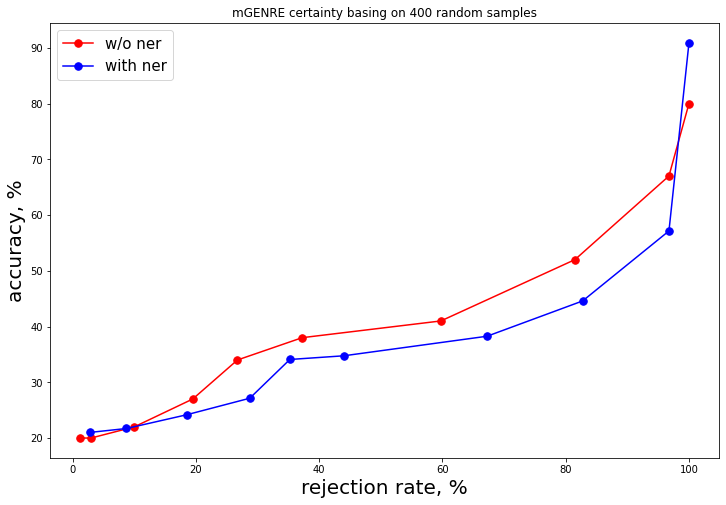

In [85]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.title("mGENRE certainty basing on 400 random samples")
plt.plot(share_of_observations_400_top_1[::-1], accuracy_400_top_1, label = "w/o ner", c = "red", marker = '.', markersize = 15);

plt.plot(share_of_observations_400_ner_top_1[::-1], accuracy_400_ner_top_1, label = "with ner", c = "blue", marker = '.', markersize = 15);
plt.legend(fontsize = 15);


# Another NER models

In [71]:
english_text = ''' I want a person available 7 days and with prompt response all most every time. Only Indian freelancer need I need PHP developer who have strong experience in Laravel and Codeigniter framework for daily 4 hours. I need this work by Monday 27th Jan. should be free from plagiarism . 
Need SAP FICO consultant for support project needs to be work on 6 months on FI AREAWe.  Want a same site to be created as the same as this https://www.facebook.com/?ref=logo, please check the site before contacting to me and i want this site to be ready in 10 days. They will be ready at noon tomorrow .'''

russian_text = '''Власти Москвы выделили 110 млрд рублей на поддержку населения, системы здравоохранения и городского хозяйства. Об этом сообщается на сайте мэра столицы https://www.sobyanin.ru/ в пятницу, 1 мая. По адресу Алтуфьевское шоссе д.51 (основной вид разрешенного использования: производственная деятельность, склады) размещен МПЗ? Подпоручик Киже управляя автомобилем ВАЗ2107 перевозил автомат АК47 с целью ограбления банка ВТБ24, как следует из записей. 
Взыскать c индивидуального предпринимателя Иванова Костантипа Петровича дата рождения 10 января 1970 года, проживающего по адресу город Санкт-Петербург, ул. Крузенштерна, дом 5/1А 8 000 (восемь тысяч) рублей 00 копеек гос. пошлины в пользу бюджета РФ Жители требуют незамедлительной остановки МПЗ и его вывода из района. Решение было принято по поручению мэра города Сергея Собянина в связи с ограничениями из-за коронавируса.'''


## 1) NLTK

In [114]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
for sent in nltk.sent_tokenize(english_text):
   for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
      if hasattr(chunk, 'label'):
         print(chunk)

[nltk_data] Downloading package punkt to /home/petrakov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/petrakov/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/petrakov/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /home/petrakov/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


(GPE Indian/JJ)
(ORGANIZATION PHP/NNP)
(GPE Laravel/NNP)
(PERSON Need/NNP)
(ORGANIZATION SAP/NNP)
(ORGANIZATION FI/NNP)


In [123]:
for i in range(1,100):
    for sent in nltk.sent_tokenize(data.loc[i,"question"]):
       for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
          if hasattr(chunk, 'label'):
             print(chunk)

(GPE Name/NN)
(PERSON Alan/NNP Pierson/NNP)
(GPE Which/NNP)
(GPE Name/NN)
(GPE Which/JJ)
(GPE Which/JJ)
(GPE Queens/NNP University/NNP)
(ORGANIZATION Bangladesh/NNP)
(PERSON Claire/NNP Stansfield/NNP)


## Spacy

In [132]:
import nltk.tag.stanford.StanfordNERTagger as StanfordNERTagger
jar = "stanford-ner-2015-04-20/stanford-ner-3.5.2.jar"
model = "stanford-ner-2015-04-20/classifiers/" 
st_3class = StanfordNERTagger(model + "english.all.3class.distsim.crf.ser.gz", jar, encoding='utf8') 
st_4class = StanfordNERTagger(model + "english.conll.4class.distsim.crf.ser.gz", jar, encoding='utf8') 
st_7class = StanfordNERTagger(model + "english.muc.7class.distsim.crf.ser.gz", jar, encoding='utf8')
for i in [st_3class.tag(english_text.split()), st_4class.tag(english_text.split()), st_7class.tag(english_text.split())]:
  for b in i:
    if b[1] != 'O':
        print(b)

ModuleNotFoundError: No module named 'nltk.tag.stanford.StanfordNERTagger'; 'nltk.tag.stanford' is not a package

In [134]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 14.0 MB/s eta 0:00:0000:0100:01
  Using cached catalogue-2.0.7-py3-none-any.whl (17 kB)
  Using cached pathy-0.6.2-py3-none-any.whl (42 kB)
  Using cached wasabi-0.9.1-py3-none-any.whl (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.9/835.9 kB 10.8 MB/s eta 0:00:0000:01
  Using cached pydantic-1.9.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
  Using cached spacy_loggers-1.0.2-py3-none-any.whl (7.2 kB)
  Using cached srsly-2.4.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (459 kB)
  Using cached spacy_legacy-3.0.9-py2.py3-none-any.whl (20 kB)
  Using cached typer-0.4.2-py3-none-any.whl (27 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached preshed-3.0.6-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (130 kB)
  Using cached cymem-2.0.6-cp

In [139]:
import spacy
import en_core_web_lg


model_sp = en_core_web_lg.load()
for ent in model_sp(english_text).ents:
  print(ent.text.strip(), ent.label_)

7 days DATE
Indian NORP
Laravel GPE
daily DATE
4 hours TIME
Monday 27th Jan. DATE
6 months DATE
https://www.facebook.com/?ref=logo ORG
10 days DATE
noon TIME
tomorrow DATE


In [147]:
for j, question in enumerate(list(data.loc[:100, 'question'])):
    print("question num: ", j, "\n", "question: ", question)
    for ent in model_sp(question).ents:
        print("entity: ", ent.text.strip(), "\n", "label: ", ent.label_, "\n")

question num:  0 
 question:  who is a musician born in detroit
entity:  detroit 
 label:  GPE 

question num:  1 
 question:  what is the language in which mera shikar was filmed in
entity:  mera shikar 
 label:  PERSON 

question num:  2 
 question:  Whats the name of a battle that happened in chicago
entity:  chicago 
 label:  GPE 

question num:  3 
 question:  what player plays the position midfielder?
question num:  4 
 question:  what is the position that  mike twellman plays
entity:  mike twellman 
 label:  PERSON 

question num:  5 
 question:  list some musical films
question num:  6 
 question:  what is ellen swallow richards's nationality?
entity:  richards 
 label:  PERSON 

question num:  7 
 question:  What language is the show elementary broadcast in?
question num:  8 
 question:  what is the gender of james hendry?
entity:  james hendry 
 label:  PERSON 

question num:  9 
 question:  who was a voice actor?
question num:  10 
 question:  What is a member of the 1893 ja

## Flair

In [148]:
from flair.models import SequenceTagger
tagger = SequenceTagger.load('ner')
from flair.data import Sentence
s = Sentence(english_text)
tagger.predict(s)
for entity in s.get_spans('ner'):
    print(entity)

2022-07-13 05:09:48,693 https://nlp.informatik.hu-berlin.de/resources/models/ner/en-ner-conll03-v0.4.pt not found in cache, downloading to /tmp/tmpqsq3oe4z


100%|██████████| 432197603/432197603 [00:38<00:00, 11342440.43B/s]

2022-07-13 05:10:26,989 copying /tmp/tmpqsq3oe4z to cache at /home/petrakov/.flair/models/en-ner-conll03-v0.4.pt


2022-07-13 05:10:27,364 removing temp file /tmp/tmpqsq3oe4z
2022-07-13 05:10:27,422 loading file /home/petrakov/.flair/models/en-ner-conll03-v0.4.pt


RuntimeError: CUDA error: no kernel image is available for execution on the device

## Deeppavlov

In [155]:
!pip install deeppavlov

Defaulting to user installation because normal site-packages is not writeable
  Using cached pydantic-1.3-cp38-cp38-manylinux2010_x86_64.whl (9.4 MB)
  Using cached numpy-1.18.0-cp38-cp38-manylinux1_x86_64.whl (20.6 MB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.9.1
    Uninstalling pydantic-1.9.1:
      Successfully uninstalled pydantic-1.9.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.6.0 which is incompatible.
thinc 8.1.0 requires pydantic!=1.8,!=1.8.1,<1.10.0,>=1.7.4, but you have pydantic 1.3 which is incompatible.
spacy 3.4.0 requires pydantic!=1.8,!=1.8.1,<1.10.0,>=1.7.4, but you have pydantic 1.3 which is i

In [154]:
!python -m deeppavlov install ner_conll2003_bert

/usr/bin/python: No module named deeppavlov


In [149]:
from deeppavlov import configs, build_model
from deeppavlov import build_model, configs

ner_model = build_model(configs.ner.ner_ontonotes_bert, download=True)
result = ner_model([english_text])
for i in range(len(result[0][0])):
     if result [1][0][i] != 'O':
         print(result[0][0][i], result[1][0][i])

2022-07-13 05:11:52.89 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/deeppavlov_data/bert/cased_L-12_H-768_A-12.zip to /home/petrakov/.deeppavlov/downloads/cased_L-12_H-768_A-12.zip
100%|██████████| 404M/404M [00:09<00:00, 40.6MB/s] 
2022-07-13 05:12:02.504 INFO in 'deeppavlov.core.data.utils'['utils'] at line 272: Extracting /home/petrakov/.deeppavlov/downloads/cased_L-12_H-768_A-12.zip archive into /home/petrakov/.deeppavlov/downloads/bert_models
2022-07-13 05:12:06.584 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/deeppavlov_data/ner_ontonotes_bert_v1.tar.gz to /home/petrakov/.deeppavlov/ner_ontonotes_bert_v1.tar.gz
100%|██████████| 805M/805M [00:16<00:00, 49.6MB/s] 
2022-07-13 05:12:23.212 INFO in 'deeppavlov.core.data.utils'['utils'] at line 272: Extracting /home/petrakov/.deeppavlov/ner_ontonotes_bert_v1.tar.gz archive into /home/petrakov/.deeppavlov/models


ModuleNotFoundError: No module named 'bert_dp'

## adaptnlp

In [157]:
!pip install adaptnlp

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 3.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 5.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.9/248.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 3.5 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 15.6 M

In [159]:
from adaptnlp import EasyTokenTagger
tagger = EasyTokenTagger()
sentences = tagger.tag_text(
    text = english_text, model_name_or_path = "ner-ontonotes"
)
spans = sentences[0].get_spans("ner")
for sen in sentences:
    for entity in sen.get_spans("ner"):
        print(entity)

TypeError: __init__() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

In [69]:
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.7/574.7 kB 4.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 32.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.8/407.8 kB 52.0 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=95100c4aaac683a075aa14f8e251caef177f7eda8edd454bc006da33cb88dd89
  Stored in directory: /home/petrakov/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [75]:
import stanza
stanza.download('en')
def stanza_nlp(text):
  nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')
  doc = nlp(text)
  print(*[f'entity: {ent.text}\ttype: {ent.type}' for sent in doc.sentences for ent in sent.ents], sep='\n')


2022-07-14 00:03:26 INFO: Downloading default packages for language: en (English)...
2022-07-14 00:03:27 INFO: File exists: /home/petrakov/stanza_resources/en/default.zip
2022-07-14 00:03:31 INFO: Finished downloading models and saved to /home/petrakov/stanza_resources.


In [84]:
for i in range(10):
    print(i)
    print(stanza_nlp(data.loc[i,"question"]))
    print("\n")

0


2022-07-14 00:06:31 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:31 INFO: Use device: gpu
2022-07-14 00:06:31 INFO: Loading: tokenize
2022-07-14 00:06:31 INFO: Loading: ner
2022-07-14 00:06:31 INFO: Done loading processors!


entity: detroit	type: GPE
None


1


2022-07-14 00:06:32 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:32 INFO: Use device: gpu
2022-07-14 00:06:32 INFO: Loading: tokenize
2022-07-14 00:06:32 INFO: Loading: ner
2022-07-14 00:06:32 INFO: Done loading processors!



None


2


2022-07-14 00:06:33 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:33 INFO: Use device: gpu
2022-07-14 00:06:33 INFO: Loading: tokenize
2022-07-14 00:06:33 INFO: Loading: ner
2022-07-14 00:06:33 INFO: Done loading processors!


entity: chicago	type: GPE
None


3


2022-07-14 00:06:34 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:34 INFO: Use device: gpu
2022-07-14 00:06:34 INFO: Loading: tokenize
2022-07-14 00:06:34 INFO: Loading: ner
2022-07-14 00:06:34 INFO: Done loading processors!



None


4


2022-07-14 00:06:35 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:35 INFO: Use device: gpu
2022-07-14 00:06:35 INFO: Loading: tokenize
2022-07-14 00:06:35 INFO: Loading: ner
2022-07-14 00:06:35 INFO: Done loading processors!



None


5


2022-07-14 00:06:36 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:36 INFO: Use device: gpu
2022-07-14 00:06:36 INFO: Loading: tokenize
2022-07-14 00:06:36 INFO: Loading: ner
2022-07-14 00:06:36 INFO: Done loading processors!



None


6


2022-07-14 00:06:37 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:37 INFO: Use device: gpu
2022-07-14 00:06:37 INFO: Loading: tokenize
2022-07-14 00:06:37 INFO: Loading: ner
2022-07-14 00:06:37 INFO: Done loading processors!



None


7


2022-07-14 00:06:38 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:38 INFO: Use device: gpu
2022-07-14 00:06:38 INFO: Loading: tokenize
2022-07-14 00:06:38 INFO: Loading: ner
2022-07-14 00:06:38 INFO: Done loading processors!



None


8


2022-07-14 00:06:39 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:39 INFO: Use device: gpu
2022-07-14 00:06:39 INFO: Loading: tokenize
2022-07-14 00:06:39 INFO: Loading: ner
2022-07-14 00:06:40 INFO: Done loading processors!



None


9


2022-07-14 00:06:40 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-14 00:06:40 INFO: Use device: gpu
2022-07-14 00:06:40 INFO: Loading: tokenize
2022-07-14 00:06:40 INFO: Loading: ner
2022-07-14 00:06:41 INFO: Done loading processors!



None




In [73]:
!pip install allennlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.6/719.6 kB 4.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 47.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tensorboardX-2.5.1-py2.py3-none-any.whl (125 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.8 MB/s eta 0:00:00a 0:00:01
  Using cached torchvision-0.12.0-cp37-cp37m-manylinux1_x86_64.whl (21.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 31.4 MB/s eta 0:00:00a 0:00:01m
  Using cached torch-1.11.0-cp37-cp37m-manylinux1_x86_64.whl (750.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 62.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 25.3 MB/s eta 0:00:00
    

In [74]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.ner.crf_tagger
predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/ner-model-2020.02.10.tar.gz")
allen_result = predictor.predict(
  sentence=english_text
)
for i in zip(allen_result['tags'], allen_result['words']):
    if (i[0]) != 'O':
      print(i)

ImportError: cannot import name 'AcquireReturnProxy' from 'filelock' (/home/petrakov/anaconda3/lib/python3.7/site-packages/filelock.py)

In [47]:
sentences = NER(text = '¿Quien descubrio America?',
                tokenizer_name = "Babelscape/wikineural-multilingual-ner",
                model_name = "Babelscape/wikineural-multilingual-ner")

sentences

'¿Quien descubrio [START] America [END] ?'

In [48]:
#sentences = ["[START] The founder of the theory of relativity [END] received the Nobel Prize."]
model_mGENRE.sample(
    sentences = [sentences],
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

[[{'id': 'Q828',
   'texts': ['América >> es', 'America >> es'],
   'scores': tensor([-0.1263, -1.3828]),
   'score': tensor(-0.1747)},
  {'id': 'Q29409515',
   'texts': ['América (desambiguación) >> es',
    'América (desambiguação) >> pt'],
   'scores': tensor([-0.3790, -1.0400]),
   'score': tensor(-1.0819)},
  {'id': 'Q18',
   'texts': ['América del Sur >> es'],
   'scores': tensor([-1.0630]),
   'score': tensor(-2.6038)}]]

# New experiment GENRE

## !!! you have to uncomment cells below to load data if it is 1 time

In [23]:
# ## Data and dependencies

# id_p_e_m = "1C2R814tsgZbREaaOk6o9nh3lQn308Wo7"
# gdown.download(id=id_p_e_m, output="prob_yago_crosswikis_wikipedia_p_e_m.txt", quiet=False)

# %mkdir data
# %cd data
# %mkdir dalab
# %cd ..

# %mv prob_yago_crosswikis_wikipedia_p_e_m.txt data/dalab/prob_yago_crosswikis_wikipedia_p_e_m.txt

# ! wget http://resources.mpi-inf.mpg.de/yago-naga/aida/download/aida_means.tsv.bz2
# ! bzip2 -dk aida_means.tsv.bz2

# %cd data 
# %mkdir aida
# %cd ..

# %mv aida_means.tsv data/aida/aida_means.tsv

In [24]:
# def read_dalab_candidates():
#     for line in open("data/dalab/prob_yago_crosswikis_wikipedia_p_e_m.txt"):
#         line = line[:-1]
#         columns = line.split("\t")
#         mention = columns[0]
#         for column in columns[2:]:
#             if len(column.strip()) == 0:
#                 continue
#             values = column.split(",")
#             candidate = ",".join(values[2:])
#             candidate = candidate.replace("_", " ")
#             yield mention, candidate


# def hex2int(hexa: str) -> int:
#     return int(hexa, 16)


# def replace_unicode(u_str):
#     matches = set(re.findall("\\\\u....", u_str))
#     for match in matches:
#         u_str = u_str.replace(match, chr(hex2int(match[2:])))
#     return u_str


# PUNCTUATION_CHARS = set(string.punctuation)


# def filter_mention(mention):
#     if mention[0].islower():
#         return True
#     if mention[0] in PUNCTUATION_CHARS:
#         return True
#     return False


# def read_aida_candidates():
#     for line in open("data/aida/aida_means.tsv"):
#         line = line[:-1]
#         values = line.split("\t")
#         mention = replace_unicode(values[0][1:-1])
#         candidate = replace_unicode(values[1]).replace("_", " ")
#         yield mention, candidate


# #making mention_candidates_dict
# #once done no need to do again

# mention_candidates_dict = {}
# for mention, candidate in itertools.chain(read_dalab_candidates(), read_aida_candidates()):
#     if filter_mention(mention):
#         continue
#     if mention not in mention_candidates_dict:
#         mention_candidates_dict[mention] = set()
#     mention_candidates_dict[mention].add(candidate)
# for mention in mention_candidates_dict:
#     mention_candidates_dict[mention] = sorted(mention_candidates_dict[mention])
# with open("data/mention_candidates_dict.pkl", "wb") as f:
#     pickle.dump(mention_candidates_dict, f)

In [25]:
# %mkdir models

In [26]:
# # making mention_trie
# # once done no need to do again

# sys.setrecursionlimit(10000)
# model_path = "fairseq_e2e_entity_linking_wiki_abs"
# model = GENRE.from_pretrained(model_path).eval()
# with open("data/mention_candidates_dict.pkl", "rb") as f:
#     mention_to_candidates_dict = pickle.load(f)
# mention_trie = Trie()
# for mention in tqdm(mention_to_candidates_dict):
#     encoded = model.encode(" {}".format(mention))[1:].tolist()
#     mention_trie.add(encoded)
# out_file = "data/mention_trie.pkl"
# with open(out_file, "wb") as f:
#     pickle.dump(mention_trie, f)

### example from git

In [27]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown
import pickle
import sys

from GENRE.genre.utils import get_entity_spans_fairseq as get_entity_spans
from GENRE.genre.utils import get_markdown


from GENRE.genre.trie import Trie, MarisaTrie
from GENRE.genre.fairseq_model import mGENRE
from GENRE.genre.fairseq_model import GENRE


model_path_genre = "fairseq_e2e_entity_linking_wiki_abs"
model_path_mgenre = "fairseq_multilingual_entity_disambiguation"
dict_path = "data/mention_candidates_dict.pkl"
trie_path = "data/mention_trie.pkl"

model = GENRE.from_pretrained(model_path_genre).eval()

with open(trie_path, "rb") as f:
    mention_trie = pickle.load(f)
with open(dict_path, "rb") as f:
    mention_to_candidates_dict = pickle.load(f)

text = """Home Depot CEO Nardelli quits Home-improvement retailer's chief executive had been criticized over pay ATLANTA - Bob Nardelli abruptly resigned Wednesday as chairman and chief executive of The Home Depot Inc. after a six-year tenure that saw the world’s largest home improvement store chain post big profits but left investors disheartened by poor stock performance. Nardelli has also been under fire by investors for his hefty pay and is leaving with a severance package valued at about $210 million. He became CEO in December 2000 after being passed over for the top job at General Electric Co., where Nardelli had been a senior executive. Home Depot said Nardelli was being replaced by Frank Blake, its vice chairman, effective immediately. Blake’s appointment is permanent, Home Depot spokesman Jerry Shields said. What he will be paid was not immediately disclosed, Shields said. The company declined to make Blake available for comment, and a message left for Nardelli with his secretary was not immediately returned. Before Wednesday’s news, Home Depot’s stock had been down more than 3 percent on a split-adjusted basis since Nardelli took over. Nardelli’s sudden departure was stunning in that he told The Associated Press as recently as Sept. 1 that he had no intention of leaving, and a key director also said that the board was pleased with Nardelli despite the uproar by some investors. Asked in that interview if he had thought of hanging up his orange apron and leaving Home Depot, Nardelli said unequivocally that he hadn’t. Asked what he thought he would be doing 10 years from now, Nardelli said, “Selling hammers.” For The Home Depot? “Absolutely,” he said at the time. Home Depot said Nardelli’s decision to resign was by mutual agreement with the Atlanta-based company. “We are very grateful to Bob for his strong leadership of The Home Depot over the past six years. Under Bob’s tenure, the company made significant and necessary investments that greatly improved the company’s infrastructure and operations, expanded our markets to include wholesale distribution and new geographies, and undertook key strategic initiatives to strengthen the company’s foundation for the future,” Home Depot’s board said in a statement. Nardelli was a nuts-and-bolts leader, a former college football player and friend of President Bush. He helped increase revenue and profits at Home Depot and increase the number of stores the company operates to more than 2,000. Home Depot’s earnings per share have increased by approximately 150 percent over the last five years."""

sentences = [text]
entity_spans = get_entity_spans(
    model,
    sentences,
    mention_trie=mention_trie,
    mention_to_candidates_dict=mention_to_candidates_dict
)
markdown = get_markdown(sentences, entity_spans)[0]

In [28]:
Markdown(markdown)

[Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) CEO Nardelli quits Home-improvement retailer's chief executive had been criticized over pay ATLANTA - [Bob Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) abruptly resigned Wednesday as chairman and chief executive of [The Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) Inc. after a six-year tenure that saw the world’s largest home improvement store chain post big profits but left investors disheartened by poor stock performance. [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) has also been under fire by investors for his hefty pay and is leaving with a severance package valued at about $210 million. He became CEO in December 2000 after being passed over for the top job at [General Electric](https://en.wikipedia.org/wiki/General_Electric) Co., where [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) had been a senior executive. [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) said [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) was being replaced by [Frank Blake](https://en.wikipedia.org/wiki/Frank_Blake), its vice chairman, effective immediately. [Blake](https://en.wikipedia.org/wiki/Frank_Blake)’s appointment is permanent, [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) spokesman [Jerry Shields](https://en.wikipedia.org/wiki/Jerry_A._Shields) said. [What](https://en.wikipedia.org/wiki/What?_(film)) he will be paid was not immediately disclosed, [Shields](https://en.wikipedia.org/wiki/Jerry_A._Shields) said. [The](https://en.wikipedia.org/wiki/The_Home_Depot) company declined to make [Blake](https://en.wikipedia.org/wiki/Frank_Blake) available for comment, and a message left for [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) with his secretary was not immediately returned. [Before](https://en.wikipedia.org/wiki/Before_(song)) Wednesday’s news, [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot)’s stock had been down more than 3 percent on a split-adjusted basis since [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) took over. [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli)’s sudden departure was stunning in that he told [The](https://en.wikipedia.org/wiki/The_Home_Depot) Associated Press as recently as Sept. 1 that he had no intention of leaving, and a key director also said that the board was pleased with [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) despite the uproar by some investors. Asked in that interview if he had thought of hanging up his orange apron and leaving [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot), [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) said unequivocally that he hadn’t. Asked what he thought he would be doing [10](https://en.wikipedia.org/wiki/10_(film)) years from now, [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) said, “Selling hammers.” For [The](https://en.wikipedia.org/wiki/The_Mr._T_Experience) Home Depot? “Absolutely,” he said at the time. [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) said [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli)’s decision to resign was by mutual agreement with the [Atlanta](https://en.wikipedia.org/wiki/Decatur,_Georgia)-based company. “We are very grateful to [Bob](https://en.wikipedia.org/wiki/Barbecue_Bob) for his strong leadership of [The](https://en.wikipedia.org/wiki/U.S._Department_of_State_Foreign_Affairs_Manual) [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) over the past six years. Under [Bob](https://en.wikipedia.org/wiki/Bank_of_Baroda)’s tenure, the company made significant and necessary investments that greatly improved the company’s infrastructure and operations, expanded our markets to include wholesale distribution and new geographies, and undertook key strategic initiatives to strengthen the company’s foundation for the future,” [Home](https://en.wikipedia.org/wiki/John_Home) [Depot](https://en.wikipedia.org/wiki/Depot)’s board said in a statement. [Nardelli](https://en.wikipedia.org/wiki/Nardelli) was a nuts-and-bolts leader, a former college football player and friend of [President](https://en.wikipedia.org/wiki/Senegalese_presidential_election,_2007) Bush. [He](https://en.wikipedia.org/wiki/J._M._E._McTaggart) helped increase revenue and profits at [Home](https://en.wikipedia.org/wiki/New_Recreation_Ground) [Depot](https://en.wikipedia.org/wiki/Depot) and increase the number of stores the company operates to more than [2](https://en.wikipedia.org/wiki/U.S._Route_2),000. [Home](https://en.wikipedia.org/wiki/New_Recreation_Ground) [Depot](https://en.wikipedia.org/wiki/Depot)’s earnings per share have increased by approximately [150](https://en.wikipedia.org/wiki/U.S._Route_150) percent over the last five years.

### mGENRE case

In [40]:
from GENRE.genre.utils import get_entity_spans_fairseq

In [49]:
model = mGENRE.from_pretrained(model_path_mgenre).eval()

In [52]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model.to(device)

GENREHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(256001, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDro

In [47]:
sentences = ["Moscow is the capital of Russia, where such great people as Kondratiev and Kolmogorov lived in 20 century"]
entity_spans = get_entity_spans_fairseq(
    model,
    sentences,
#    mention_trie=mention_trie,
#    mention_to_candidates_dict=mention_to_candidates_dict
)


TypeError: expected string or bytes-like object

In [53]:
model.

GENREHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(256001, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDro

In [37]:
markdown = get_markdown(sentences, entity_spans)[0]

In [38]:
Markdown(markdown)

[Moscow](https://en.wikipedia.org/wiki/Moscow) is the capital of [Russia](https://en.wikipedia.org/wiki/Russia), where such great people as [Kondratiev](https://en.wikipedia.org/wiki/Mikhail_Kondratiev) and [Kolmogorov](https://en.wikipedia.org/wiki/Andrey_Kolmogorov) lived in 20 century

# Estimate scores

In [29]:
from GENRE.genre.utils import get_entity_spans_fairseq as get_entity_spans

In [30]:
documents = {
    "id_0": "In 1921, Einstein received a Nobel Prize.",
    "id_1": "Armstrong was the first man on the Moon.",
}

gold_entities = [
    ("id_0", 3, 4, "1921"),
    ("id_0", 9, 8, 'Albert_Einstein'),
    ("id_0", 29, 11, 'Nobel_Prize_in_Physics'),
    ("id_1", 0, 9, 'Neil_Armstrong'),
    ("id_1", 35, 4, 'Moon'),
]

In [31]:
guess_entities = get_entity_spans(
    model,
    list(documents.values()),
)
print("guess_entities", guess_entities)
print("#############")

guess_entities = [
    (k,) + x
    for k, e in zip(documents.keys(), guess_entities)
    for x in e
]
print("guess_entities", guess_entities)

guess_entities [[(0, 7, 'List_of_Nobel_laureates_by_year_of_appointment'), (9, 8, 'Albert_Einstein'), (29, 11, 'Nobel_Prize_in_Physiology_or_Medicine'), (40, 1, 'List_of_Nobel_laureates_in_Physiology_or_Medicine_by_year_of_appointment')], [(18, 9, 'First_Man_(film)'), (35, 4, 'Moon_(TV_series)_(1968_TV_series,_season_1)'), (39, 1, 'Moon_(TV_series,_season_1)')]]
#############
guess_entities [('id_0', 0, 7, 'List_of_Nobel_laureates_by_year_of_appointment'), ('id_0', 9, 8, 'Albert_Einstein'), ('id_0', 29, 11, 'Nobel_Prize_in_Physiology_or_Medicine'), ('id_0', 40, 1, 'List_of_Nobel_laureates_in_Physiology_or_Medicine_by_year_of_appointment'), ('id_1', 18, 9, 'First_Man_(film)'), ('id_1', 35, 4, 'Moon_(TV_series)_(1968_TV_series,_season_1)'), ('id_1', 39, 1, 'Moon_(TV_series,_season_1)')]


In [32]:
from GENRE.genre.utils import (
    get_micro_precision,
    get_micro_recall,
    get_micro_f1,
    get_macro_precision,
    get_macro_recall,
    get_macro_f1,
)

micro_p = get_micro_precision(guess_entities, gold_entities)
micro_r = get_micro_recall(guess_entities, gold_entities)
micro_f1 = get_micro_f1(guess_entities, gold_entities)
macro_p = get_macro_precision(guess_entities, gold_entities)
macro_r = get_macro_recall(guess_entities, gold_entities)
macro_f1 = get_macro_f1(guess_entities, gold_entities)

print(
   "micro_p={:.4f} micro_r={:.4f}, micro_f1={:.4f}, macro_p={:.4f}, macro_r={:.4f}, macro_f1={:.4f}".format(
       micro_p, micro_r, micro_f1, macro_p, macro_r, macro_f1
   )
)

micro_p=0.1429 micro_r=0.2000, micro_f1=0.1667, macro_p=0.1250, macro_r=0.1667, macro_f1=0.1429


# load mewsli-9

In [39]:
import pandas as pd
import bz2

In [40]:
#en_df = pd.read_csv('dataset/en/mentions.tsv', sep='\t')
#en_df_doc = pd.read_csv('docs.tsv', sep='\t')
en_df_doc = pd.read_csv('mewsli_9/dense_representations_for_entity_retrieval/mel/mewsli-9/output/dataset/en/docs.tsv', sep='\t')
en_df_men = pd.read_csv('mewsli_9/dense_representations_for_entity_retrieval/mel/mewsli-9/output/dataset/en/mentions.tsv', sep='\t')



In [37]:
%cd mewsli_9/dense_representations_for_entity_retrieval/mel

/home/petrakov/success/mGENRE_MEL/mewsli_9/dense_representations_for_entity_retrieval/mel


In [28]:
with bz2.open("mewsli-9/output/wikiextractor/en/AA/wiki_00.bz2", "rb") as f:
    # Decompress data from file
    en_wiki = f.read()



In [38]:
%cd mewsli-9/output/output/dataset/en/text

/home/petrakov/success/mGENRE_MEL/mewsli_9/dense_representations_for_entity_retrieval/mel/mewsli-9/output/output/dataset/en/text


In [41]:
a = en_df_men[en_df_men['docid'] == "en-106602"]
b = en_df_men[en_df_men["docid"] == "en-106608"].reset_index()
c = en_df_men[en_df_men["docid"] == "en-106610"].reset_index()

In [42]:
%cd $init_dir

/home/petrakov/success/mGENRE_MEL


In [54]:
directory = "mewsli_9/dense_representations_for_entity_retrieval/mel/mewsli-9/output/output/dataset/en/text/"
texts = []
for st in ["en-106602", "en-106608", "en-106610"]:
    with open(directory + st, "r") as f:
        string = f.read()
    
    string = string.replace("\n", " ").replace("\xa0", "")
    string = string.replace("_", " ")
    string = string.replace("\n", " ")
    texts.append(string)


In [44]:
# documents = {
#     "id_0": texts[0],
#     "id_1": texts[1],
#     "id_2": texts[2],
# }

documents = {
    "id_0": "In 1921, Einstein received a Nobel Prize.",
    "id_1": "Armstrong was the first man on the Moon.",
}



gold_entities = [
    ("id_0", 3, 4, "1921"),
    ("id_0", 9, 8, 'Albert_Einstein'),
    ("id_0", 29, 11, 'Nobel_Prize_in_Physics'),
    ("id_1", 0, 9, 'Neil_Armstrong'),
    ("id_1", 35, 4, 'Moon'),
]

In [55]:
documents = {
    "id_0": texts[0],
    "id_1": texts[1],
    "id_2": texts[2],
}

gold_entities = [*[tuple(["id_0", *list(a.loc[i, ["position", "length", "mention"]])]) for i in range(len(a))],
                *[tuple(["id_1", *list(b.loc[i, ["position", "length", "mention"]])]) for i in range(len(b))],
                *[tuple(["id_2", *list(c.loc[i, ["position", "length", "mention"]])]) for i in range(len(c))]]


In [56]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown
import pickle
import sys

from GENRE.genre.utils import get_entity_spans_fairseq as get_entity_spans
from GENRE.genre.utils import get_markdown


from GENRE.genre.trie import Trie, MarisaTrie
from GENRE.genre.fairseq_model import mGENRE
from GENRE.genre.fairseq_model import GENRE


model_path_genre = "fairseq_e2e_entity_linking_wiki_abs"
model_path_mgenre = "fairseq_multilingual_entity_disambiguation"
dict_path = "data/mention_candidates_dict.pkl"
trie_path = "data/mention_trie.pkl"

model = GENRE.from_pretrained(model_path_genre).eval()

In [57]:
guess_entities = get_entity_spans(
    model,
    list(documents.values()),
)

In [58]:
guess_entities_1 = [
    (k,*x)
    for k, e in zip(documents.keys(), guess_entities)
    for x in e
]

In [59]:
from GENRE.genre.utils import (
    get_micro_precision,
    get_micro_recall,
    get_micro_f1,
    get_macro_precision,
    get_macro_recall,
    get_macro_f1,
)

micro_p = get_micro_precision(guess_entities_1, gold_entities)
micro_r = get_micro_recall(guess_entities_1, gold_entities)
micro_f1 = get_micro_f1(guess_entities_1, gold_entities)
macro_p = get_macro_precision(guess_entities_1, gold_entities)
macro_r = get_macro_recall(guess_entities_1, gold_entities)
macro_f1 = get_macro_f1(guess_entities_1, gold_entities)

print(
   "micro_p={:.4f} micro_r={:.4f}, micro_f1={:.4f}, macro_p={:.4f}, macro_r={:.4f}, macro_f1={:.4f}".format(
       micro_p, micro_r, micro_f1, macro_p, macro_r, macro_f1
   )
)

micro_p=0.0000 micro_r=0.0000, micro_f1=0.0000, macro_p=0.0000, macro_r=0.0000, macro_f1=0.0000


In [60]:
from GENRE.genre.utils import (
    get_micro_precision,
    get_micro_recall,
    get_micro_f1,
    get_macro_precision,
    get_macro_recall,
    get_macro_f1,
)

micro_p = get_micro_precision(guess_entities_1, gold_entities)
micro_r = get_micro_recall(guess_entities_1, gold_entities)
micro_f1 = get_micro_f1(guess_entities_1, gold_entities)
macro_p = get_macro_precision(guess_entities_1, gold_entities)
macro_r = get_macro_recall(guess_entities_1, gold_entities)
macro_f1 = get_macro_f1(guess_entities_1, gold_entities)

print(
   "micro_p={:.4f} micro_r={:.4f}, micro_f1={:.4f}, macro_p={:.4f}, macro_r={:.4f}, macro_f1={:.4f}".format(
       micro_p, micro_r, micro_f1, macro_p, macro_r, macro_f1
   )
)

micro_p=0.0000 micro_r=0.0000, micro_f1=0.0000, macro_p=0.0000, macro_r=0.0000, macro_f1=0.0000


In [61]:
gold_entities

[('id_0', 145, 39, 'Pacific Marine Environmental Laboratory'),
 ('id_0', 365, 15, 'Baja California'),
 ('id_0', 1013, 13, 'oceanographer'),
 ('id_0', 1109, 5, 'Earth'),
 ('id_0', 1150, 14, 'carbon dioxide'),
 ('id_0', 1278, 9, 'carbonate'),
 ('id_0', 1385, 13, 'carbonic acid'),
 ('id_0', 1769, 21, 'Industrial Revolution'),
 ('id_1', 118, 33, '2006 Lathen maglev train accident'),
 ('id_1', 231, 6, 'maglev'),
 ('id_1', 358, 11, 'human error'),
 ('id_1', 454, 10, 'Transrapid'),
 ('id_1', 471, 2, 'cm'),
 ('id_1', 583, 9, 'Osnabrück'),
 ('id_1', 643, 4, 'euro'),
 ('id_2', 189, 8, 'asbestos'),
 ('id_2', 423, 16, 'terminal illness'),
 ('id_2', 459, 12, 'mesothelioma'),
 ('id_2', 520, 12, 'James Hardie'),
 ('id_2', 634, 10, 'asbestosis'),
 ('id_2', 693, 13, 'lung scarring'),
 ('id_2', 812, 6, 'cancer'),
 ('id_2', 861, 22, 'lungs and chest cavity'),
 ('id_2', 885, 16, 'abdominal cavity'),
 ('id_2', 910, 25, 'sac surrounding the heart'),
 ('id_2', 1136, 17, 'Victorian Premier'),
 ('id_2', 1154, 

In [68]:
texts[0][365-1:365+15-1]

'Baja California'

In [62]:
guess_entities_1

[('id_0', 0, 4, 'National_Oceanic_and_Atmospheric_Administration'),
 ('id_0', 87, 49, 'National_Oceanic_and_Atmospheric_Administration'),
 ('id_0',
  144,
  39,
  'National_Oceanic_and_Atmospheric_Administration_National_Marine_Environmental_Laboratory'),
 ('id_0', 210, 14, 'World_Ocean'),
 ('id_0', 345, 13, 'Pacific_Ocean'),
 ('id_0', 364, 23, 'Baja_California'),
 ('id_0', 391, 27, 'Vancouver'),
 ('id_0', 491, 17, 'Continental_shelf'),
 ('id_0', 556, 13, 'Marine_life'),
 ('id_0',
  586,
  6,
  'Oceanic_carbonate_marine_life_in_the_United_States_and_Great_Britain_of_Great_Britain_and_Ireland_of_1844–1855'),
 ('id_0', 675, 10, 'California'),
 ('id_0',
  703,
  13,
  'List_of_countries_by_number_of_military_and_paramilitary_personnel_in_the_second_year_of_conflict_with_the_United_States_(1944–46)'),
 ('id_0', 719, 72, 'Ocean_acidification'),
 ('id_0', 819, 11, 'Marine_life'),
 ('id_0',
  838,
  17,
  'Continental_shelf_of_the_United_States_and_Great_Britain_of_Great_Britain_of_1844–1855_

In [56]:
%ls

aida_means.tsv.bz2
data/
dataset/
docs.tsv
fairseq/
fairseq_e2e_entity_linking_wiki_abs/
fairseq_multilingual_entity_disambiguation/
fairseq_multilingual_entity_disambiguation.tar.gz
GENRE/
KILT/
lang_title2wikidataID-normalized_with_redirect.pkl
mentions_test.json
mentions.tsv
mewsli_9/
mgenre_final.ipynb.invalid
mgenre_final_with_mewsli.ipynb
README.md
requirements.txt
titles_lang_all105_marisa_trie_with_redirect.pkl


In [59]:
!pip install hanziconv

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 2.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for hanziconv: filename=hanziconv-0.3.2-py2.py3-none-any.whl size=23225 sha256=800fc8bc3ee5cfe9cacd7ccd8335d3cab8f5284f0eece677b82e7ac0eec312f5
  Stored in directory: /home/petrakov/.cache/pip/wheels/24/bc/5f/95aceeea892d9bf06c29a9effde5908abcefd3fa23244fdaa5
Successfully built hanziconv


In [84]:
from GENRE.scripts_mgenre.evaluate_kilt_dataset import evaluate_kilt_dataset

In [70]:
#!wget http://dl.fbaipublicfiles.com/GENRE/ace2004-test-kilt.jsonl
#!wget http://dl.fbaipublicfiles.com/KILT/fever-dev-kilt.jsonl
#!wget http://dl.fbaipublicfiles.com/GENRE/fairseq_wikipage_retrieval.tar.gz
!wget http://dl.fbaipublicfiles.com/KILT/wned-dev-kilt.jsonl

--2022-07-06 02:07:20--  http://dl.fbaipublicfiles.com/KILT/wned-dev-kilt.jsonl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12868348 (12M) [text/plain]
Saving to: ‘wned-dev-kilt.jsonl’

wned-dev-kilt.jsonl 100%[===================>]  12.27M  7.99MB/s    in 1.5s    

2022-07-06 02:07:22 (7.99 MB/s) - ‘wned-dev-kilt.jsonl’ saved [12868348/12868348]



In [85]:
import json

with open('wned-dev-kilt.jsonl', 'r') as f:
    wned = f.read()

In [86]:
evaluate_kilt_dataset(model = model_mGENRE, dataset = wned)

Evaluating :   0%|          | 0/12852476 [00:00<?, ?it/s]

TypeError: string indices must be integers

In [67]:
fever['meta']

TypeError: list indices must be integers or slices, not str

# Additional info

### Another example

In [24]:
client = Client()  # doctest: +SKIP
entity = client.get('Q20145', load=True)
entity, entity.description

(<wikidata.entity.Entity Q20145 'IU'>,
 m'Korea  singer,actress record producer (2017)')

In [25]:
class bcolors:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Below we present a function that illustrates predicted entity, text, right answer basing on the id as input

In [36]:
def predict_from_test_set(idx=0):
    print(test_set[str(idx)]['mention_its']+"\n")
    start = test_set[str(idx)]['start_index']
    end = test_set[str(idx)]['end_index']
    mention_id = test_set[str(idx)]['mention_id']
    text = test_set[str(idx)]['source_document']['text']
    text = text[:start]+"[START] "+text[start:end]+" [END]"+text[end:]
    print(f'{text[:start]}{bcolors.BOLD}{text[start:end+len("[START] ")+len(" [END]")]}{bcolors.END}{text[end+len("[START] ")+len(" [END]"):]}\n')
    result = model.sample(
    sentences=[text],
    text_to_id=lambda x: sorted(list(lang_title2wikidataID.get(
        tuple(reversed((x.split(" >> ")[0], x.split(" >> ")[1][:2]))), [None])))[0],
    marginalize=True)
    print(result)
    
    entity = client.get(mention_id, load=True)
    print(f'\nCorrect entity : {mention_id, entity.label, entity.description}\n')

    candidates = [(i['id'], client.get(i['id'], load=True)) for i in result[0]]
    print('Predicted entities:')
    for i, entity in candidates:
        if i is not None:
            print(f'{i, entity.label, entity.description}')

In [37]:
predict_from_test_set(2354)

New South Wales

Bathurst Regional Council, the local government responsible for the city of Bathurst and its surrounds in Central Western [START] New South Wales [END], Australia yesterday revealed it had received a development application for the new Bathurst Base Hospital.The new hospital is to be built behind the current hospital on the same site and is expected to cost the New South Wales government AUD96 million. The Bathurst Hospital will be the first in the Bathurst-Orange-Bloomfield redevelopment project.The new hospital will have 149 beds, up from 85 for the current hospital. The hospital will also feature a mental health unit - previously psychiatric patients had to travel to Orange to the Bloomfield Hospital for treatment.The Bathurst Hospital is expected to have state-of-the art facilities and will share some services with the to be constructed Orange Base Hospital.The Bathurst Regional Council has approved the demolition of 12 buildings on the hospital site for enabling w

# Preliminary results:

Language: **fa** (5 out of 61)

Micro average (k=1): **1.0**

Language: **sr** (105 out of 451)

Micro average (k=1): **0.90476**

Language: **ta** (25 out of 366)

Micro average (k=1): **1.0**

### Macro average (k=1): 0.96825

In [28]:
from tqdm import tqdm
from multiprocessing import Pool

In [29]:
from fairseq.data.data_utils import collate_tokens


def compute_results(idx):
    start = test_set[str(idx)]['start_index']
    end = test_set[str(idx)]['end_index']
    mention_id = test_set[str(idx)]['mention_id']
    text = test_set[str(idx)]['source_document']['text']
    text = text[:start]+"[START] "+text[start:end]+" [END]"+text[end:]
    print(start, end, min(start, len(text)-end))
    #encoder = model.encoder(text)
    #print(encoder)

    result = model.sample(
                    sentences=[text],
                   text_to_id=lambda x: sorted(list(lang_title2wikidataID.get(
       tuple(reversed((x.split(" >> ")[0], x.split(" >> ")[1][:2]))), [None])))[0],
                    marginalize=True)
    candidates = [(i['id'], client.get(i['id'], load=True)) for i in result[0] if i['id'] is not None]
    entity = client.get(mention_id, load=True)
    return {
            "correct": mention_id, 
            "predicted": [i for i, _ in candidates]
               }

In [30]:
compute_results(1)

100 109 100


{'correct': 'Q36678', 'predicted': ['Q36678', 'Q2564150', 'Q7834492']}

In [32]:
def compute_scores(lang='en', k_list=[1, 10, 20, 50, 100]):
    scores = []
    
    for idx in tqdm(langs_idx[lang]):
        scores.append(compute_results(idx))
    return scores

In [33]:
langs_idx = {
    'ar':[], 'en':[], 'tr':[]
}
for idx in test_set:
    el = test_set[idx]
    lang = el['document_id'][:2]
    if lang in langs_idx:
        langs_idx[lang].append(int(idx))

In [ ]:
def micro_avg_lang(scores, lang='en', k_list=[1, 10, 20, 50, 100]):    
    print(f'Language: {lang}')
    results = []
    for k in k_list:
        n = 0
        for i, row in enumerate(scores):
            if scores['correct'] in scores['predicted'][:k]:
                n += 1
        results.append(round(n / total_mentions, 5))
    for i, k in enumerate(k_list):
        print(f'Micro average (k={k}):', results[i])
    return results